In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = True

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_0_1_0_0_1_t1t2_normalized_e_n_e_0_0_e_0_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_0_42_n_normalized_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(772408, 828)
(772408, 8)
validation
(101248, 828)
(101248, 8)
test
(98888, 828)
(98888, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1538952 (5.87 MB)


Trainable params: 1538952 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/78 [..............................] - ETA: 1:49 - loss: 1.9626 - STD: 0.0957 - MAE: 0.2106

 4/78 [>.............................] - ETA: 2s - loss: 1.5840 - STD: 0.1486 - MAE: 0.1712  

 5/78 [>.............................] - ETA: 2s - loss: 1.5357 - STD: 0.1637 - MAE: 0.1633

 6/78 [=>............................] - ETA: 3s - loss: 1.5070 - STD: 0.1738 - MAE: 0.1583

 7/78 [=>............................] - ETA: 3s - loss: 1.4836 - STD: 0.1799 - MAE: 0.1552

 8/78 [==>...........................] - ETA: 8s - loss: 1.4780 - STD: 0.1829 - MAE: 0.1533

12/78 [===>..........................] - ETA: 5s - loss: 1.4239 - STD: 0.1815 - MAE: 0.1524

13/78 [====>.........................] - ETA: 5s - loss: 1.4153 - STD: 0.1811 - MAE: 0.1523

14/78 [====>.........................] - ETA: 5s - loss: 1.4084 - STD: 0.1813 - MAE: 0.1520

15/78 [====>.........................] - ETA: 5s - loss: 1.4029 - STD: 0.1821 - MAE: 0.1515

16/78 [=====>........................] - ETA: 4s - loss: 1.3976 - STD: 0.1833 - MAE: 0.1509

17/78 [=====>........................] - ETA: 4s - loss: 1.3956 - STD: 0.1848 - MAE: 0.1503

18/78 [=====>........................] - ETA: 4s - loss: 1.3922 - STD: 0.1863 - MAE: 0.1496

19/78 [======>.......................] - ETA: 4s - loss: 1.3879 - STD: 0.1877 - MAE: 0.1489

20/78 [======>.......................] - ETA: 4s - loss: 1.3855 - STD: 0.1889 - MAE: 0.1483

21/78 [=======>......................] - ETA: 4s - loss: 1.3829 - STD: 0.1898 - MAE: 0.1479

22/78 [=======>......................] - ETA: 4s - loss: 1.3802 - STD: 0.1904 - MAE: 0.1476

23/78 [=======>......................] - ETA: 4s - loss: 1.3776 - STD: 0.1907 - MAE: 0.1474

24/78 [========>.....................] - ETA: 4s - loss: 1.3757 - STD: 0.1907 - MAE: 0.1473

25/78 [========>.....................] - ETA: 3s - loss: 1.3734 - STD: 0.1906 - MAE: 0.1473

26/78 [=========>....................] - ETA: 3s - loss: 1.3712 - STD: 0.1904 - MAE: 0.1473

27/78 [=========>....................] - ETA: 3s - loss: 1.3698 - STD: 0.1901 - MAE: 0.1474

28/78 [=========>....................] - ETA: 3s - loss: 1.3684 - STD: 0.1899 - MAE: 0.1474

29/78 [==========>...................] - ETA: 3s - loss: 1.3667 - STD: 0.1898 - MAE: 0.1474

30/78 [==========>...................] - ETA: 3s - loss: 1.3656 - STD: 0.1898 - MAE: 0.1474

31/78 [==========>...................] - ETA: 3s - loss: 1.3642 - STD: 0.1899 - MAE: 0.1473

32/78 [===========>..................] - ETA: 3s - loss: 1.3625 - STD: 0.1901 - MAE: 0.1472

33/78 [===========>..................] - ETA: 3s - loss: 1.3617 - STD: 0.1903 - MAE: 0.1471

34/78 [============>.................] - ETA: 3s - loss: 1.3607 - STD: 0.1905 - MAE: 0.1470

35/78 [============>.................] - ETA: 3s - loss: 1.3597 - STD: 0.1907 - MAE: 0.1469

36/78 [============>.................] - ETA: 2s - loss: 1.3586 - STD: 0.1909 - MAE: 0.1468

37/78 [=============>................] - ETA: 2s - loss: 1.3574 - STD: 0.1909 - MAE: 0.1468

38/78 [=============>................] - ETA: 2s - loss: 1.3561 - STD: 0.1909 - MAE: 0.1467

39/78 [==============>...............] - ETA: 2s - loss: 1.3546 - STD: 0.1909 - MAE: 0.1467

40/78 [==============>...............] - ETA: 2s - loss: 1.3538 - STD: 0.1909 - MAE: 0.1467

41/78 [==============>...............] - ETA: 2s - loss: 1.3527 - STD: 0.1908 - MAE: 0.1467

42/78 [===============>..............] - ETA: 2s - loss: 1.3518 - STD: 0.1908 - MAE: 0.1466

43/78 [===============>..............] - ETA: 2s - loss: 1.3510 - STD: 0.1908 - MAE: 0.1466

44/78 [===============>..............] - ETA: 2s - loss: 1.3500 - STD: 0.1908 - MAE: 0.1466

45/78 [================>.............] - ETA: 2s - loss: 1.3491 - STD: 0.1909 - MAE: 0.1465

46/78 [================>.............] - ETA: 2s - loss: 1.3483 - STD: 0.1910 - MAE: 0.1465

47/78 [=================>............] - ETA: 2s - loss: 1.3476 - STD: 0.1910 - MAE: 0.1464

48/78 [=================>............] - ETA: 2s - loss: 1.3469 - STD: 0.1911 - MAE: 0.1464

49/78 [=================>............] - ETA: 1s - loss: 1.3462 - STD: 0.1911 - MAE: 0.1464

50/78 [==================>...........] - ETA: 1s - loss: 1.3457 - STD: 0.1911 - MAE: 0.1463

51/78 [==================>...........] - ETA: 1s - loss: 1.3452 - STD: 0.1911 - MAE: 0.1463

52/78 [===================>..........] - ETA: 1s - loss: 1.3446 - STD: 0.1911 - MAE: 0.1463

53/78 [===================>..........] - ETA: 1s - loss: 1.3442 - STD: 0.1910 - MAE: 0.1463

54/78 [===================>..........] - ETA: 1s - loss: 1.3437 - STD: 0.1910 - MAE: 0.1464

55/78 [====================>.........] - ETA: 1s - loss: 1.3430 - STD: 0.1909 - MAE: 0.1464

56/78 [====================>.........] - ETA: 1s - loss: 1.3428 - STD: 0.1908 - MAE: 0.1464

57/78 [====================>.........] - ETA: 1s - loss: 1.3416 - STD: 0.1908 - MAE: 0.1463

58/78 [=====================>........] - ETA: 1s - loss: 1.3413 - STD: 0.1908 - MAE: 0.1463

59/78 [=====================>........] - ETA: 1s - loss: 1.3408 - STD: 0.1908 - MAE: 0.1463

60/78 [======================>.......] - ETA: 1s - loss: 1.3405 - STD: 0.1909 - MAE: 0.1463

61/78 [======================>.......] - ETA: 1s - loss: 1.3404 - STD: 0.1909 - MAE: 0.1463

62/78 [======================>.......] - ETA: 1s - loss: 1.3398 - STD: 0.1910 - MAE: 0.1462

63/78 [=======================>......] - ETA: 0s - loss: 1.3394 - STD: 0.1909 - MAE: 0.1462

64/78 [=======================>......] - ETA: 0s - loss: 1.3387 - STD: 0.1909 - MAE: 0.1462

65/78 [========================>.....] - ETA: 0s - loss: 1.3384 - STD: 0.1909 - MAE: 0.1462

66/78 [========================>.....] - ETA: 0s - loss: 1.3379 - STD: 0.1908 - MAE: 0.1462

67/78 [========================>.....] - ETA: 0s - loss: 1.3373 - STD: 0.1908 - MAE: 0.1462

68/78 [=========================>....] - ETA: 0s - loss: 1.3368 - STD: 0.1908 - MAE: 0.1462

69/78 [=========================>....] - ETA: 0s - loss: 1.3362 - STD: 0.1909 - MAE: 0.1461

70/78 [=========================>....] - ETA: 0s - loss: 1.3358 - STD: 0.1909 - MAE: 0.1461

71/78 [==========================>...] - ETA: 0s - loss: 1.3350 - STD: 0.1909 - MAE: 0.1461

72/78 [==========================>...] - ETA: 0s - loss: 1.3344 - STD: 0.1910 - MAE: 0.1460

73/78 [===========================>..] - ETA: 0s - loss: 1.3336 - STD: 0.1910 - MAE: 0.1460

74/78 [===========================>..] - ETA: 0s - loss: 1.3333 - STD: 0.1910 - MAE: 0.1460

75/78 [===========================>..] - ETA: 0s - loss: 1.3327 - STD: 0.1910 - MAE: 0.1459

76/78 [============================>.] - ETA: 0s - loss: 1.3322 - STD: 0.1910 - MAE: 0.1459

77/78 [============================>.] - ETA: 0s - loss: 1.3315 - STD: 0.1910 - MAE: 0.1459

78/78 [==============================] - ETA: 0s - loss: 1.3307 - STD: 0.1910 - MAE: 0.1458

78/78 [==============================] - 7s 75ms/step - loss: 1.3307 - STD: 0.1910 - MAE: 0.1458 - val_loss: 1.2355 - val_STD: 0.1934 - val_MAE: 0.1417


Epoch 2/10000


 1/78 [..............................] - ETA: 7s - loss: 1.2835 - STD: 0.1954 - MAE: 0.1419

 2/78 [..............................] - ETA: 5s - loss: 1.2823 - STD: 0.1952 - MAE: 0.1420

 3/78 [>.............................] - ETA: 4s - loss: 1.2768 - STD: 0.1944 - MAE: 0.1420

 4/78 [>.............................] - ETA: 4s - loss: 1.2744 - STD: 0.1939 - MAE: 0.1420

 5/78 [>.............................] - ETA: 4s - loss: 1.2746 - STD: 0.1939 - MAE: 0.1420

 6/78 [=>............................] - ETA: 4s - loss: 1.2742 - STD: 0.1943 - MAE: 0.1418

 7/78 [=>............................] - ETA: 4s - loss: 1.2738 - STD: 0.1949 - MAE: 0.1416

 8/78 [==>...........................] - ETA: 4s - loss: 1.2731 - STD: 0.1951 - MAE: 0.1415

 9/78 [==>...........................] - ETA: 4s - loss: 1.2726 - STD: 0.1951 - MAE: 0.1415

10/78 [==>...........................] - ETA: 4s - loss: 1.2732 - STD: 0.1948 - MAE: 0.1416

11/78 [===>..........................] - ETA: 4s - loss: 1.2715 - STD: 0.1949 - MAE: 0.1415

12/78 [===>..........................] - ETA: 4s - loss: 1.2700 - STD: 0.1953 - MAE: 0.1413

13/78 [====>.........................] - ETA: 4s - loss: 1.2699 - STD: 0.1958 - MAE: 0.1411

14/78 [====>.........................] - ETA: 4s - loss: 1.2692 - STD: 0.1960 - MAE: 0.1410

15/78 [====>.........................] - ETA: 4s - loss: 1.2686 - STD: 0.1958 - MAE: 0.1411

16/78 [=====>........................] - ETA: 4s - loss: 1.2687 - STD: 0.1956 - MAE: 0.1412

17/78 [=====>........................] - ETA: 4s - loss: 1.2671 - STD: 0.1955 - MAE: 0.1412

18/78 [=====>........................] - ETA: 3s - loss: 1.2677 - STD: 0.1956 - MAE: 0.1412

19/78 [======>.......................] - ETA: 3s - loss: 1.2662 - STD: 0.1959 - MAE: 0.1410

20/78 [======>.......................] - ETA: 3s - loss: 1.2659 - STD: 0.1961 - MAE: 0.1409

21/78 [=======>......................] - ETA: 3s - loss: 1.2651 - STD: 0.1959 - MAE: 0.1409

22/78 [=======>......................] - ETA: 3s - loss: 1.2640 - STD: 0.1959 - MAE: 0.1409

23/78 [=======>......................] - ETA: 3s - loss: 1.2640 - STD: 0.1961 - MAE: 0.1409

24/78 [========>.....................] - ETA: 3s - loss: 1.2629 - STD: 0.1963 - MAE: 0.1407

25/78 [========>.....................] - ETA: 3s - loss: 1.2632 - STD: 0.1964 - MAE: 0.1407

26/78 [=========>....................] - ETA: 3s - loss: 1.2626 - STD: 0.1964 - MAE: 0.1407

27/78 [=========>....................] - ETA: 3s - loss: 1.2606 - STD: 0.1963 - MAE: 0.1406

28/78 [=========>....................] - ETA: 3s - loss: 1.2596 - STD: 0.1966 - MAE: 0.1405

29/78 [==========>...................] - ETA: 3s - loss: 1.2591 - STD: 0.1968 - MAE: 0.1404

30/78 [==========>...................] - ETA: 3s - loss: 1.2577 - STD: 0.1968 - MAE: 0.1404

31/78 [==========>...................] - ETA: 3s - loss: 1.2565 - STD: 0.1967 - MAE: 0.1404

32/78 [===========>..................] - ETA: 3s - loss: 1.2560 - STD: 0.1967 - MAE: 0.1403

33/78 [===========>..................] - ETA: 2s - loss: 1.2551 - STD: 0.1969 - MAE: 0.1402

34/78 [============>.................] - ETA: 2s - loss: 1.2545 - STD: 0.1970 - MAE: 0.1402

35/78 [============>.................] - ETA: 2s - loss: 1.2536 - STD: 0.1970 - MAE: 0.1402

36/78 [============>.................] - ETA: 2s - loss: 1.2528 - STD: 0.1970 - MAE: 0.1402

37/78 [=============>................] - ETA: 2s - loss: 1.2515 - STD: 0.1971 - MAE: 0.1401

38/78 [=============>................] - ETA: 2s - loss: 1.2504 - STD: 0.1972 - MAE: 0.1400

39/78 [==============>...............] - ETA: 2s - loss: 1.2495 - STD: 0.1972 - MAE: 0.1400

40/78 [==============>...............] - ETA: 2s - loss: 1.2491 - STD: 0.1971 - MAE: 0.1400

41/78 [==============>...............] - ETA: 2s - loss: 1.2483 - STD: 0.1973 - MAE: 0.1399

42/78 [===============>..............] - ETA: 2s - loss: 1.2475 - STD: 0.1974 - MAE: 0.1399

43/78 [===============>..............] - ETA: 2s - loss: 1.2464 - STD: 0.1973 - MAE: 0.1398

44/78 [===============>..............] - ETA: 2s - loss: 1.2454 - STD: 0.1973 - MAE: 0.1398

45/78 [================>.............] - ETA: 2s - loss: 1.2441 - STD: 0.1974 - MAE: 0.1397

46/78 [================>.............] - ETA: 2s - loss: 1.2425 - STD: 0.1975 - MAE: 0.1396

47/78 [=================>............] - ETA: 2s - loss: 1.2411 - STD: 0.1976 - MAE: 0.1395

48/78 [=================>............] - ETA: 1s - loss: 1.2398 - STD: 0.1977 - MAE: 0.1395

49/78 [=================>............] - ETA: 1s - loss: 1.2387 - STD: 0.1978 - MAE: 0.1394

50/78 [==================>...........] - ETA: 1s - loss: 1.2379 - STD: 0.1978 - MAE: 0.1394

51/78 [==================>...........] - ETA: 1s - loss: 1.2366 - STD: 0.1979 - MAE: 0.1393

52/78 [===================>..........] - ETA: 1s - loss: 1.2355 - STD: 0.1979 - MAE: 0.1393

53/78 [===================>..........] - ETA: 1s - loss: 1.2341 - STD: 0.1979 - MAE: 0.1392

54/78 [===================>..........] - ETA: 1s - loss: 1.2333 - STD: 0.1980 - MAE: 0.1392

55/78 [====================>.........] - ETA: 1s - loss: 1.2323 - STD: 0.1981 - MAE: 0.1391

56/78 [====================>.........] - ETA: 1s - loss: 1.2312 - STD: 0.1982 - MAE: 0.1390

57/78 [====================>.........] - ETA: 1s - loss: 1.2301 - STD: 0.1982 - MAE: 0.1390

58/78 [=====================>........] - ETA: 1s - loss: 1.2289 - STD: 0.1982 - MAE: 0.1389

59/78 [=====================>........] - ETA: 1s - loss: 1.2279 - STD: 0.1983 - MAE: 0.1389

60/78 [======================>.......] - ETA: 1s - loss: 1.2267 - STD: 0.1984 - MAE: 0.1388

61/78 [======================>.......] - ETA: 1s - loss: 1.2257 - STD: 0.1985 - MAE: 0.1388

62/78 [======================>.......] - ETA: 1s - loss: 1.2244 - STD: 0.1986 - MAE: 0.1387

63/78 [=======================>......] - ETA: 0s - loss: 1.2233 - STD: 0.1986 - MAE: 0.1386

64/78 [=======================>......] - ETA: 0s - loss: 1.2222 - STD: 0.1987 - MAE: 0.1386

65/78 [========================>.....] - ETA: 0s - loss: 1.2210 - STD: 0.1987 - MAE: 0.1385

66/78 [========================>.....] - ETA: 0s - loss: 1.2197 - STD: 0.1988 - MAE: 0.1384

67/78 [========================>.....] - ETA: 0s - loss: 1.2187 - STD: 0.1989 - MAE: 0.1384

69/78 [=========================>....] - ETA: 0s - loss: 1.2175 - STD: 0.1991 - MAE: 0.1382

70/78 [=========================>....] - ETA: 0s - loss: 1.2163 - STD: 0.1991 - MAE: 0.1382

71/78 [==========================>...] - ETA: 0s - loss: 1.2151 - STD: 0.1991 - MAE: 0.1382

72/78 [==========================>...] - ETA: 0s - loss: 1.2139 - STD: 0.1992 - MAE: 0.1381

73/78 [===========================>..] - ETA: 0s - loss: 1.2126 - STD: 0.1992 - MAE: 0.1380

74/78 [===========================>..] - ETA: 0s - loss: 1.2114 - STD: 0.1993 - MAE: 0.1380

75/78 [===========================>..] - ETA: 0s - loss: 1.2101 - STD: 0.1994 - MAE: 0.1379

76/78 [============================>.] - ETA: 0s - loss: 1.2088 - STD: 0.1994 - MAE: 0.1378

77/78 [============================>.] - ETA: 0s - loss: 1.2077 - STD: 0.1994 - MAE: 0.1378

78/78 [==============================] - ETA: 0s - loss: 1.2064 - STD: 0.1995 - MAE: 0.1377

78/78 [==============================] - 5s 68ms/step - loss: 1.2064 - STD: 0.1995 - MAE: 0.1377 - val_loss: 1.1020 - val_STD: 0.2074 - val_MAE: 0.1310


Epoch 3/10000


 1/78 [..............................] - ETA: 8s - loss: 1.0993 - STD: 0.2059 - MAE: 0.1323

 2/78 [..............................] - ETA: 5s - loss: 1.1041 - STD: 0.2041 - MAE: 0.1330

 3/78 [>.............................] - ETA: 5s - loss: 1.0996 - STD: 0.2029 - MAE: 0.1332

 4/78 [>.............................] - ETA: 5s - loss: 1.0970 - STD: 0.2040 - MAE: 0.1326

 5/78 [>.............................] - ETA: 4s - loss: 1.0938 - STD: 0.2058 - MAE: 0.1317

 6/78 [=>............................] - ETA: 4s - loss: 1.0929 - STD: 0.2055 - MAE: 0.1319

 7/78 [=>............................] - ETA: 4s - loss: 1.0908 - STD: 0.2050 - MAE: 0.1320

 8/78 [==>...........................] - ETA: 4s - loss: 1.0895 - STD: 0.2051 - MAE: 0.1319

 9/78 [==>...........................] - ETA: 4s - loss: 1.0885 - STD: 0.2062 - MAE: 0.1315

10/78 [==>...........................] - ETA: 4s - loss: 1.0886 - STD: 0.2056 - MAE: 0.1318

11/78 [===>..........................] - ETA: 4s - loss: 1.0882 - STD: 0.2046 - MAE: 0.1322

12/78 [===>..........................] - ETA: 4s - loss: 1.0873 - STD: 0.2055 - MAE: 0.1318

13/78 [====>.........................] - ETA: 4s - loss: 1.0875 - STD: 0.2060 - MAE: 0.1316

14/78 [====>.........................] - ETA: 4s - loss: 1.0875 - STD: 0.2053 - MAE: 0.1319

15/78 [====>.........................] - ETA: 4s - loss: 1.0859 - STD: 0.2053 - MAE: 0.1319

16/78 [=====>........................] - ETA: 4s - loss: 1.0844 - STD: 0.2059 - MAE: 0.1316

17/78 [=====>........................] - ETA: 4s - loss: 1.0843 - STD: 0.2065 - MAE: 0.1313

18/78 [=====>........................] - ETA: 4s - loss: 1.0836 - STD: 0.2059 - MAE: 0.1316

19/78 [======>.......................] - ETA: 3s - loss: 1.0816 - STD: 0.2056 - MAE: 0.1316

20/78 [======>.......................] - ETA: 3s - loss: 1.0818 - STD: 0.2067 - MAE: 0.1311

21/78 [=======>......................] - ETA: 3s - loss: 1.0803 - STD: 0.2069 - MAE: 0.1310

22/78 [=======>......................] - ETA: 3s - loss: 1.0797 - STD: 0.2062 - MAE: 0.1313

23/78 [=======>......................] - ETA: 3s - loss: 1.0785 - STD: 0.2062 - MAE: 0.1312

24/78 [========>.....................] - ETA: 3s - loss: 1.0769 - STD: 0.2072 - MAE: 0.1308

25/78 [========>.....................] - ETA: 3s - loss: 1.0754 - STD: 0.2074 - MAE: 0.1306

26/78 [=========>....................] - ETA: 3s - loss: 1.0742 - STD: 0.2069 - MAE: 0.1308

27/78 [=========>....................] - ETA: 3s - loss: 1.0723 - STD: 0.2071 - MAE: 0.1306

28/78 [=========>....................] - ETA: 3s - loss: 1.0710 - STD: 0.2079 - MAE: 0.1302

29/78 [==========>...................] - ETA: 3s - loss: 1.0698 - STD: 0.2083 - MAE: 0.1300

30/78 [==========>...................] - ETA: 3s - loss: 1.0691 - STD: 0.2078 - MAE: 0.1302

31/78 [==========>...................] - ETA: 3s - loss: 1.0679 - STD: 0.2076 - MAE: 0.1302

32/78 [===========>..................] - ETA: 3s - loss: 1.0664 - STD: 0.2083 - MAE: 0.1299

33/78 [===========>..................] - ETA: 3s - loss: 1.0656 - STD: 0.2088 - MAE: 0.1297

34/78 [============>.................] - ETA: 2s - loss: 1.0642 - STD: 0.2086 - MAE: 0.1297

35/78 [============>.................] - ETA: 2s - loss: 1.0636 - STD: 0.2083 - MAE: 0.1298

36/78 [============>.................] - ETA: 2s - loss: 1.0624 - STD: 0.2085 - MAE: 0.1297

37/78 [=============>................] - ETA: 2s - loss: 1.0613 - STD: 0.2091 - MAE: 0.1294

38/78 [=============>................] - ETA: 2s - loss: 1.0605 - STD: 0.2094 - MAE: 0.1292

39/78 [==============>...............] - ETA: 2s - loss: 1.0597 - STD: 0.2092 - MAE: 0.1293

40/78 [==============>...............] - ETA: 2s - loss: 1.0587 - STD: 0.2090 - MAE: 0.1293

41/78 [==============>...............] - ETA: 2s - loss: 1.0577 - STD: 0.2092 - MAE: 0.1292

42/78 [===============>..............] - ETA: 2s - loss: 1.0571 - STD: 0.2096 - MAE: 0.1290

43/78 [===============>..............] - ETA: 2s - loss: 1.0562 - STD: 0.2098 - MAE: 0.1289

44/78 [===============>..............] - ETA: 2s - loss: 1.0552 - STD: 0.2095 - MAE: 0.1290

45/78 [================>.............] - ETA: 2s - loss: 1.0543 - STD: 0.2095 - MAE: 0.1290

46/78 [================>.............] - ETA: 2s - loss: 1.0536 - STD: 0.2098 - MAE: 0.1288

47/78 [=================>............] - ETA: 2s - loss: 1.0526 - STD: 0.2101 - MAE: 0.1286

48/78 [=================>............] - ETA: 2s - loss: 1.0519 - STD: 0.2101 - MAE: 0.1286

49/78 [=================>............] - ETA: 1s - loss: 1.0511 - STD: 0.2100 - MAE: 0.1286

50/78 [==================>...........] - ETA: 1s - loss: 1.0501 - STD: 0.2101 - MAE: 0.1286

51/78 [==================>...........] - ETA: 1s - loss: 1.0494 - STD: 0.2104 - MAE: 0.1284

52/78 [===================>..........] - ETA: 1s - loss: 1.0483 - STD: 0.2106 - MAE: 0.1283

53/78 [===================>..........] - ETA: 1s - loss: 1.0474 - STD: 0.2106 - MAE: 0.1282

54/78 [===================>..........] - ETA: 1s - loss: 1.0466 - STD: 0.2105 - MAE: 0.1282

55/78 [====================>.........] - ETA: 1s - loss: 1.0457 - STD: 0.2106 - MAE: 0.1282

56/78 [====================>.........] - ETA: 1s - loss: 1.0447 - STD: 0.2109 - MAE: 0.1280

57/78 [====================>.........] - ETA: 1s - loss: 1.0441 - STD: 0.2110 - MAE: 0.1280

59/78 [=====================>........] - ETA: 1s - loss: 1.0434 - STD: 0.2108 - MAE: 0.1280

60/78 [======================>.......] - ETA: 1s - loss: 1.0427 - STD: 0.2109 - MAE: 0.1280

61/78 [======================>.......] - ETA: 1s - loss: 1.0421 - STD: 0.2111 - MAE: 0.1278

62/78 [======================>.......] - ETA: 1s - loss: 1.0413 - STD: 0.2112 - MAE: 0.1278

63/78 [=======================>......] - ETA: 1s - loss: 1.0408 - STD: 0.2111 - MAE: 0.1278

64/78 [=======================>......] - ETA: 0s - loss: 1.0403 - STD: 0.2112 - MAE: 0.1278

65/78 [========================>.....] - ETA: 0s - loss: 1.0398 - STD: 0.2112 - MAE: 0.1277

66/78 [========================>.....] - ETA: 0s - loss: 1.0391 - STD: 0.2113 - MAE: 0.1277

67/78 [========================>.....] - ETA: 0s - loss: 1.0380 - STD: 0.2114 - MAE: 0.1276

68/78 [=========================>....] - ETA: 0s - loss: 1.0374 - STD: 0.2114 - MAE: 0.1276

69/78 [=========================>....] - ETA: 0s - loss: 1.0366 - STD: 0.2115 - MAE: 0.1275

70/78 [=========================>....] - ETA: 0s - loss: 1.0356 - STD: 0.2116 - MAE: 0.1274

71/78 [==========================>...] - ETA: 0s - loss: 1.0350 - STD: 0.2117 - MAE: 0.1274

72/78 [==========================>...] - ETA: 0s - loss: 1.0343 - STD: 0.2117 - MAE: 0.1273

73/78 [===========================>..] - ETA: 0s - loss: 1.0336 - STD: 0.2118 - MAE: 0.1273

74/78 [===========================>..] - ETA: 0s - loss: 1.0328 - STD: 0.2119 - MAE: 0.1272

75/78 [===========================>..] - ETA: 0s - loss: 1.0322 - STD: 0.2120 - MAE: 0.1272

76/78 [============================>.] - ETA: 0s - loss: 1.0315 - STD: 0.2120 - MAE: 0.1271

77/78 [============================>.] - ETA: 0s - loss: 1.0307 - STD: 0.2121 - MAE: 0.1270

78/78 [==============================] - ETA: 0s - loss: 1.0299 - STD: 0.2122 - MAE: 0.1270

78/78 [==============================] - 6s 70ms/step - loss: 1.0299 - STD: 0.2122 - MAE: 0.1270 - val_loss: 0.9566 - val_STD: 0.2125 - val_MAE: 0.1238


Epoch 4/10000


 1/78 [..............................] - ETA: 8s - loss: 0.9686 - STD: 0.2166 - MAE: 0.1226

 2/78 [..............................] - ETA: 5s - loss: 0.9651 - STD: 0.2177 - MAE: 0.1220

 3/78 [>.............................] - ETA: 5s - loss: 0.9673 - STD: 0.2180 - MAE: 0.1222

 4/78 [>.............................] - ETA: 5s - loss: 0.9694 - STD: 0.2167 - MAE: 0.1228

 5/78 [>.............................] - ETA: 5s - loss: 0.9699 - STD: 0.2165 - MAE: 0.1228

 6/78 [=>............................] - ETA: 5s - loss: 0.9672 - STD: 0.2176 - MAE: 0.1223

 7/78 [=>............................] - ETA: 5s - loss: 0.9644 - STD: 0.2179 - MAE: 0.1220

 8/78 [==>...........................] - ETA: 4s - loss: 0.9638 - STD: 0.2175 - MAE: 0.1221

 9/78 [==>...........................] - ETA: 4s - loss: 0.9633 - STD: 0.2182 - MAE: 0.1218

10/78 [==>...........................] - ETA: 4s - loss: 0.9643 - STD: 0.2180 - MAE: 0.1220

11/78 [===>..........................] - ETA: 4s - loss: 0.9631 - STD: 0.2175 - MAE: 0.1221

12/78 [===>..........................] - ETA: 4s - loss: 0.9630 - STD: 0.2180 - MAE: 0.1219

13/78 [====>.........................] - ETA: 4s - loss: 0.9627 - STD: 0.2183 - MAE: 0.1218

14/78 [====>.........................] - ETA: 4s - loss: 0.9623 - STD: 0.2178 - MAE: 0.1219

15/78 [====>.........................] - ETA: 4s - loss: 0.9618 - STD: 0.2178 - MAE: 0.1219

16/78 [=====>........................] - ETA: 4s - loss: 0.9603 - STD: 0.2184 - MAE: 0.1216

17/78 [=====>........................] - ETA: 4s - loss: 0.9592 - STD: 0.2181 - MAE: 0.1216

18/78 [=====>........................] - ETA: 4s - loss: 0.9581 - STD: 0.2181 - MAE: 0.1216

19/78 [======>.......................] - ETA: 4s - loss: 0.9568 - STD: 0.2184 - MAE: 0.1214

20/78 [======>.......................] - ETA: 3s - loss: 0.9555 - STD: 0.2186 - MAE: 0.1213

21/78 [=======>......................] - ETA: 3s - loss: 0.9546 - STD: 0.2185 - MAE: 0.1213

22/78 [=======>......................] - ETA: 3s - loss: 0.9540 - STD: 0.2187 - MAE: 0.1211

23/78 [=======>......................] - ETA: 3s - loss: 0.9536 - STD: 0.2188 - MAE: 0.1211

24/78 [========>.....................] - ETA: 3s - loss: 0.9526 - STD: 0.2187 - MAE: 0.1211

25/78 [========>.....................] - ETA: 3s - loss: 0.9515 - STD: 0.2190 - MAE: 0.1209

26/78 [=========>....................] - ETA: 3s - loss: 0.9510 - STD: 0.2190 - MAE: 0.1209

27/78 [=========>....................] - ETA: 3s - loss: 0.9498 - STD: 0.2189 - MAE: 0.1208

28/78 [=========>....................] - ETA: 3s - loss: 0.9496 - STD: 0.2191 - MAE: 0.1207

29/78 [==========>...................] - ETA: 3s - loss: 0.9482 - STD: 0.2192 - MAE: 0.1206

30/78 [==========>...................] - ETA: 3s - loss: 0.9471 - STD: 0.2194 - MAE: 0.1205

31/78 [==========>...................] - ETA: 3s - loss: 0.9463 - STD: 0.2195 - MAE: 0.1204

32/78 [===========>..................] - ETA: 3s - loss: 0.9457 - STD: 0.2195 - MAE: 0.1204

33/78 [===========>..................] - ETA: 3s - loss: 0.9454 - STD: 0.2197 - MAE: 0.1203

34/78 [============>.................] - ETA: 3s - loss: 0.9447 - STD: 0.2198 - MAE: 0.1202

35/78 [============>.................] - ETA: 2s - loss: 0.9438 - STD: 0.2199 - MAE: 0.1201

36/78 [============>.................] - ETA: 2s - loss: 0.9433 - STD: 0.2200 - MAE: 0.1201

37/78 [=============>................] - ETA: 2s - loss: 0.9425 - STD: 0.2201 - MAE: 0.1200

38/78 [=============>................] - ETA: 2s - loss: 0.9417 - STD: 0.2201 - MAE: 0.1199

39/78 [==============>...............] - ETA: 2s - loss: 0.9405 - STD: 0.2204 - MAE: 0.1197

41/78 [==============>...............] - ETA: 2s - loss: 0.9393 - STD: 0.2204 - MAE: 0.1197

42/78 [===============>..............] - ETA: 2s - loss: 0.9385 - STD: 0.2207 - MAE: 0.1195

43/78 [===============>..............] - ETA: 2s - loss: 0.9376 - STD: 0.2207 - MAE: 0.1194

44/78 [===============>..............] - ETA: 2s - loss: 0.9371 - STD: 0.2207 - MAE: 0.1194

45/78 [================>.............] - ETA: 2s - loss: 0.9363 - STD: 0.2209 - MAE: 0.1193

46/78 [================>.............] - ETA: 2s - loss: 0.9358 - STD: 0.2210 - MAE: 0.1192

47/78 [=================>............] - ETA: 2s - loss: 0.9351 - STD: 0.2210 - MAE: 0.1192

48/78 [=================>............] - ETA: 2s - loss: 0.9345 - STD: 0.2211 - MAE: 0.1191

49/78 [=================>............] - ETA: 1s - loss: 0.9340 - STD: 0.2212 - MAE: 0.1190

50/78 [==================>...........] - ETA: 1s - loss: 0.9334 - STD: 0.2213 - MAE: 0.1190

51/78 [==================>...........] - ETA: 1s - loss: 0.9328 - STD: 0.2213 - MAE: 0.1189

52/78 [===================>..........] - ETA: 1s - loss: 0.9322 - STD: 0.2214 - MAE: 0.1189

53/78 [===================>..........] - ETA: 1s - loss: 0.9318 - STD: 0.2215 - MAE: 0.1188

54/78 [===================>..........] - ETA: 1s - loss: 0.9310 - STD: 0.2214 - MAE: 0.1188

55/78 [====================>.........] - ETA: 1s - loss: 0.9310 - STD: 0.2218 - MAE: 0.1187

56/78 [====================>.........] - ETA: 1s - loss: 0.9308 - STD: 0.2215 - MAE: 0.1188

57/78 [====================>.........] - ETA: 1s - loss: 0.9305 - STD: 0.2216 - MAE: 0.1187

58/78 [=====================>........] - ETA: 1s - loss: 0.9300 - STD: 0.2219 - MAE: 0.1186

59/78 [=====================>........] - ETA: 1s - loss: 0.9294 - STD: 0.2219 - MAE: 0.1185

60/78 [======================>.......] - ETA: 1s - loss: 0.9289 - STD: 0.2218 - MAE: 0.1185

61/78 [======================>.......] - ETA: 1s - loss: 0.9283 - STD: 0.2220 - MAE: 0.1184

62/78 [======================>.......] - ETA: 1s - loss: 0.9280 - STD: 0.2221 - MAE: 0.1183

63/78 [=======================>......] - ETA: 1s - loss: 0.9279 - STD: 0.2220 - MAE: 0.1184

64/78 [=======================>......] - ETA: 0s - loss: 0.9272 - STD: 0.2221 - MAE: 0.1183

65/78 [========================>.....] - ETA: 0s - loss: 0.9269 - STD: 0.2224 - MAE: 0.1182

66/78 [========================>.....] - ETA: 0s - loss: 0.9264 - STD: 0.2223 - MAE: 0.1182

67/78 [========================>.....] - ETA: 0s - loss: 0.9260 - STD: 0.2223 - MAE: 0.1182

68/78 [=========================>....] - ETA: 0s - loss: 0.9254 - STD: 0.2224 - MAE: 0.1181

69/78 [=========================>....] - ETA: 0s - loss: 0.9250 - STD: 0.2226 - MAE: 0.1180

70/78 [=========================>....] - ETA: 0s - loss: 0.9248 - STD: 0.2226 - MAE: 0.1180

71/78 [==========================>...] - ETA: 0s - loss: 0.9244 - STD: 0.2226 - MAE: 0.1180

72/78 [==========================>...] - ETA: 0s - loss: 0.9243 - STD: 0.2227 - MAE: 0.1179

73/78 [===========================>..] - ETA: 0s - loss: 0.9238 - STD: 0.2228 - MAE: 0.1178

74/78 [===========================>..] - ETA: 0s - loss: 0.9236 - STD: 0.2227 - MAE: 0.1179

75/78 [===========================>..] - ETA: 0s - loss: 0.9231 - STD: 0.2228 - MAE: 0.1178

76/78 [============================>.] - ETA: 0s - loss: 0.9227 - STD: 0.2229 - MAE: 0.1177

77/78 [============================>.] - ETA: 0s - loss: 0.9222 - STD: 0.2230 - MAE: 0.1177

78/78 [==============================] - ETA: 0s - loss: 0.9219 - STD: 0.2230 - MAE: 0.1177

78/78 [==============================] - 6s 71ms/step - loss: 0.9219 - STD: 0.2230 - MAE: 0.1177 - val_loss: 0.8911 - val_STD: 0.2258 - val_MAE: 0.1149


Epoch 5/10000


 1/78 [..............................] - ETA: 7s - loss: 0.8768 - STD: 0.2299 - MAE: 0.1123

 2/78 [..............................] - ETA: 5s - loss: 0.8897 - STD: 0.2291 - MAE: 0.1132

 3/78 [>.............................] - ETA: 5s - loss: 0.8830 - STD: 0.2293 - MAE: 0.1128

 4/78 [>.............................] - ETA: 4s - loss: 0.8904 - STD: 0.2289 - MAE: 0.1134

 5/78 [>.............................] - ETA: 4s - loss: 0.8891 - STD: 0.2270 - MAE: 0.1142

 6/78 [=>............................] - ETA: 4s - loss: 0.8907 - STD: 0.2279 - MAE: 0.1139

 7/78 [=>............................] - ETA: 4s - loss: 0.8880 - STD: 0.2286 - MAE: 0.1135

 8/78 [==>...........................] - ETA: 4s - loss: 0.8890 - STD: 0.2278 - MAE: 0.1139

 9/78 [==>...........................] - ETA: 4s - loss: 0.8877 - STD: 0.2275 - MAE: 0.1139

10/78 [==>...........................] - ETA: 4s - loss: 0.8886 - STD: 0.2286 - MAE: 0.1134

11/78 [===>..........................] - ETA: 4s - loss: 0.8889 - STD: 0.2280 - MAE: 0.1137

12/78 [===>..........................] - ETA: 4s - loss: 0.8882 - STD: 0.2276 - MAE: 0.1139

13/78 [====>.........................] - ETA: 4s - loss: 0.8876 - STD: 0.2282 - MAE: 0.1136

14/78 [====>.........................] - ETA: 4s - loss: 0.8878 - STD: 0.2281 - MAE: 0.1137

15/78 [====>.........................] - ETA: 4s - loss: 0.8874 - STD: 0.2279 - MAE: 0.1137

16/78 [=====>........................] - ETA: 4s - loss: 0.8871 - STD: 0.2279 - MAE: 0.1138

17/78 [=====>........................] - ETA: 4s - loss: 0.8870 - STD: 0.2279 - MAE: 0.1137

18/78 [=====>........................] - ETA: 4s - loss: 0.8863 - STD: 0.2282 - MAE: 0.1136

19/78 [======>.......................] - ETA: 3s - loss: 0.8863 - STD: 0.2283 - MAE: 0.1135

20/78 [======>.......................] - ETA: 3s - loss: 0.8861 - STD: 0.2281 - MAE: 0.1136

21/78 [=======>......................] - ETA: 3s - loss: 0.8856 - STD: 0.2282 - MAE: 0.1135

22/78 [=======>......................] - ETA: 3s - loss: 0.8852 - STD: 0.2283 - MAE: 0.1135

23/78 [=======>......................] - ETA: 3s - loss: 0.8850 - STD: 0.2281 - MAE: 0.1136

24/78 [========>.....................] - ETA: 3s - loss: 0.8847 - STD: 0.2283 - MAE: 0.1135

25/78 [========>.....................] - ETA: 3s - loss: 0.8849 - STD: 0.2283 - MAE: 0.1135

26/78 [=========>....................] - ETA: 3s - loss: 0.8851 - STD: 0.2281 - MAE: 0.1136

27/78 [=========>....................] - ETA: 3s - loss: 0.8851 - STD: 0.2282 - MAE: 0.1135

28/78 [=========>....................] - ETA: 3s - loss: 0.8848 - STD: 0.2282 - MAE: 0.1135

29/78 [==========>...................] - ETA: 3s - loss: 0.8845 - STD: 0.2281 - MAE: 0.1136

30/78 [==========>...................] - ETA: 3s - loss: 0.8847 - STD: 0.2283 - MAE: 0.1135

31/78 [==========>...................] - ETA: 3s - loss: 0.8840 - STD: 0.2283 - MAE: 0.1134

32/78 [===========>..................] - ETA: 3s - loss: 0.8832 - STD: 0.2282 - MAE: 0.1134

33/78 [===========>..................] - ETA: 3s - loss: 0.8832 - STD: 0.2285 - MAE: 0.1133

34/78 [============>.................] - ETA: 2s - loss: 0.8833 - STD: 0.2283 - MAE: 0.1134

35/78 [============>.................] - ETA: 2s - loss: 0.8825 - STD: 0.2284 - MAE: 0.1133

36/78 [============>.................] - ETA: 2s - loss: 0.8822 - STD: 0.2285 - MAE: 0.1133

37/78 [=============>................] - ETA: 2s - loss: 0.8820 - STD: 0.2284 - MAE: 0.1133

38/78 [=============>................] - ETA: 2s - loss: 0.8813 - STD: 0.2285 - MAE: 0.1132

39/78 [==============>...............] - ETA: 2s - loss: 0.8812 - STD: 0.2287 - MAE: 0.1131

40/78 [==============>...............] - ETA: 2s - loss: 0.8815 - STD: 0.2285 - MAE: 0.1132

41/78 [==============>...............] - ETA: 2s - loss: 0.8812 - STD: 0.2287 - MAE: 0.1131

42/78 [===============>..............] - ETA: 2s - loss: 0.8811 - STD: 0.2287 - MAE: 0.1131

43/78 [===============>..............] - ETA: 2s - loss: 0.8809 - STD: 0.2286 - MAE: 0.1131

44/78 [===============>..............] - ETA: 2s - loss: 0.8805 - STD: 0.2287 - MAE: 0.1131

45/78 [================>.............] - ETA: 2s - loss: 0.8802 - STD: 0.2288 - MAE: 0.1130

46/78 [================>.............] - ETA: 2s - loss: 0.8797 - STD: 0.2287 - MAE: 0.1130

47/78 [=================>............] - ETA: 2s - loss: 0.8798 - STD: 0.2289 - MAE: 0.1130

48/78 [=================>............] - ETA: 2s - loss: 0.8797 - STD: 0.2287 - MAE: 0.1131

49/78 [=================>............] - ETA: 1s - loss: 0.8792 - STD: 0.2288 - MAE: 0.1130

50/78 [==================>...........] - ETA: 1s - loss: 0.8791 - STD: 0.2290 - MAE: 0.1129

51/78 [==================>...........] - ETA: 1s - loss: 0.8789 - STD: 0.2288 - MAE: 0.1130

52/78 [===================>..........] - ETA: 1s - loss: 0.8789 - STD: 0.2289 - MAE: 0.1130

53/78 [===================>..........] - ETA: 1s - loss: 0.8786 - STD: 0.2289 - MAE: 0.1129

54/78 [===================>..........] - ETA: 1s - loss: 0.8782 - STD: 0.2289 - MAE: 0.1129

55/78 [====================>.........] - ETA: 1s - loss: 0.8782 - STD: 0.2291 - MAE: 0.1128

56/78 [====================>.........] - ETA: 1s - loss: 0.8782 - STD: 0.2289 - MAE: 0.1129

57/78 [====================>.........] - ETA: 1s - loss: 0.8780 - STD: 0.2290 - MAE: 0.1129

58/78 [=====================>........] - ETA: 1s - loss: 0.8779 - STD: 0.2291 - MAE: 0.1128

59/78 [=====================>........] - ETA: 1s - loss: 0.8777 - STD: 0.2290 - MAE: 0.1128

60/78 [======================>.......] - ETA: 1s - loss: 0.8778 - STD: 0.2290 - MAE: 0.1128

61/78 [======================>.......] - ETA: 1s - loss: 0.8775 - STD: 0.2291 - MAE: 0.1128

62/78 [======================>.......] - ETA: 1s - loss: 0.8773 - STD: 0.2290 - MAE: 0.1128

64/78 [=======================>......] - ETA: 0s - loss: 0.8772 - STD: 0.2292 - MAE: 0.1128

65/78 [========================>.....] - ETA: 0s - loss: 0.8771 - STD: 0.2290 - MAE: 0.1128

66/78 [========================>.....] - ETA: 0s - loss: 0.8768 - STD: 0.2291 - MAE: 0.1128

67/78 [========================>.....] - ETA: 0s - loss: 0.8770 - STD: 0.2292 - MAE: 0.1127

68/78 [=========================>....] - ETA: 0s - loss: 0.8770 - STD: 0.2291 - MAE: 0.1128

69/78 [=========================>....] - ETA: 0s - loss: 0.8768 - STD: 0.2292 - MAE: 0.1127

70/78 [=========================>....] - ETA: 0s - loss: 0.8767 - STD: 0.2293 - MAE: 0.1127

71/78 [==========================>...] - ETA: 0s - loss: 0.8766 - STD: 0.2292 - MAE: 0.1127

72/78 [==========================>...] - ETA: 0s - loss: 0.8764 - STD: 0.2292 - MAE: 0.1127

73/78 [===========================>..] - ETA: 0s - loss: 0.8763 - STD: 0.2294 - MAE: 0.1126

74/78 [===========================>..] - ETA: 0s - loss: 0.8762 - STD: 0.2293 - MAE: 0.1127

75/78 [===========================>..] - ETA: 0s - loss: 0.8762 - STD: 0.2292 - MAE: 0.1127

76/78 [============================>.] - ETA: 0s - loss: 0.8759 - STD: 0.2294 - MAE: 0.1126

77/78 [============================>.] - ETA: 0s - loss: 0.8757 - STD: 0.2294 - MAE: 0.1126

78/78 [==============================] - ETA: 0s - loss: 0.8758 - STD: 0.2293 - MAE: 0.1127

78/78 [==============================] - 6s 70ms/step - loss: 0.8758 - STD: 0.2293 - MAE: 0.1127 - val_loss: 0.8710 - val_STD: 0.2303 - val_MAE: 0.1119


Epoch 6/10000


 1/78 [..............................] - ETA: 7s - loss: 0.8603 - STD: 0.2328 - MAE: 0.1104

 2/78 [..............................] - ETA: 5s - loss: 0.8627 - STD: 0.2355 - MAE: 0.1091

 3/78 [>.............................] - ETA: 5s - loss: 0.8618 - STD: 0.2318 - MAE: 0.1108

 4/78 [>.............................] - ETA: 5s - loss: 0.8579 - STD: 0.2303 - MAE: 0.1113

 5/78 [>.............................] - ETA: 5s - loss: 0.8572 - STD: 0.2329 - MAE: 0.1100

 6/78 [=>............................] - ETA: 4s - loss: 0.8554 - STD: 0.2327 - MAE: 0.1100

 7/78 [=>............................] - ETA: 4s - loss: 0.8569 - STD: 0.2313 - MAE: 0.1107

 8/78 [==>...........................] - ETA: 4s - loss: 0.8577 - STD: 0.2317 - MAE: 0.1107

 9/78 [==>...........................] - ETA: 4s - loss: 0.8578 - STD: 0.2319 - MAE: 0.1106

10/78 [==>...........................] - ETA: 4s - loss: 0.8571 - STD: 0.2314 - MAE: 0.1108

11/78 [===>..........................] - ETA: 4s - loss: 0.8581 - STD: 0.2313 - MAE: 0.1109

12/78 [===>..........................] - ETA: 4s - loss: 0.8603 - STD: 0.2314 - MAE: 0.1109

13/78 [====>.........................] - ETA: 4s - loss: 0.8605 - STD: 0.2310 - MAE: 0.1112

14/78 [====>.........................] - ETA: 4s - loss: 0.8604 - STD: 0.2308 - MAE: 0.1113

15/78 [====>.........................] - ETA: 4s - loss: 0.8606 - STD: 0.2312 - MAE: 0.1111

16/78 [=====>........................] - ETA: 4s - loss: 0.8602 - STD: 0.2312 - MAE: 0.1111

17/78 [=====>........................] - ETA: 4s - loss: 0.8590 - STD: 0.2310 - MAE: 0.1111

18/78 [=====>........................] - ETA: 4s - loss: 0.8585 - STD: 0.2313 - MAE: 0.1110

19/78 [======>.......................] - ETA: 4s - loss: 0.8588 - STD: 0.2314 - MAE: 0.1109

20/78 [======>.......................] - ETA: 3s - loss: 0.8586 - STD: 0.2310 - MAE: 0.1111

21/78 [=======>......................] - ETA: 3s - loss: 0.8592 - STD: 0.2312 - MAE: 0.1111

22/78 [=======>......................] - ETA: 3s - loss: 0.8592 - STD: 0.2312 - MAE: 0.1111

23/78 [=======>......................] - ETA: 3s - loss: 0.8590 - STD: 0.2311 - MAE: 0.1111

24/78 [========>.....................] - ETA: 3s - loss: 0.8593 - STD: 0.2312 - MAE: 0.1111

25/78 [========>.....................] - ETA: 3s - loss: 0.8597 - STD: 0.2312 - MAE: 0.1111

26/78 [=========>....................] - ETA: 3s - loss: 0.8595 - STD: 0.2309 - MAE: 0.1112

27/78 [=========>....................] - ETA: 3s - loss: 0.8595 - STD: 0.2311 - MAE: 0.1111

28/78 [=========>....................] - ETA: 3s - loss: 0.8594 - STD: 0.2312 - MAE: 0.1111

29/78 [==========>...................] - ETA: 3s - loss: 0.8590 - STD: 0.2310 - MAE: 0.1111

30/78 [==========>...................] - ETA: 3s - loss: 0.8582 - STD: 0.2311 - MAE: 0.1110

31/78 [==========>...................] - ETA: 3s - loss: 0.8580 - STD: 0.2313 - MAE: 0.1109

32/78 [===========>..................] - ETA: 3s - loss: 0.8581 - STD: 0.2312 - MAE: 0.1110

34/78 [============>.................] - ETA: 2s - loss: 0.8578 - STD: 0.2313 - MAE: 0.1109

35/78 [============>.................] - ETA: 2s - loss: 0.8570 - STD: 0.2312 - MAE: 0.1109

36/78 [============>.................] - ETA: 2s - loss: 0.8569 - STD: 0.2313 - MAE: 0.1108

37/78 [=============>................] - ETA: 2s - loss: 0.8571 - STD: 0.2314 - MAE: 0.1108

38/78 [=============>................] - ETA: 2s - loss: 0.8572 - STD: 0.2312 - MAE: 0.1109

39/78 [==============>...............] - ETA: 2s - loss: 0.8569 - STD: 0.2314 - MAE: 0.1108

40/78 [==============>...............] - ETA: 2s - loss: 0.8566 - STD: 0.2314 - MAE: 0.1108

41/78 [==============>...............] - ETA: 2s - loss: 0.8566 - STD: 0.2313 - MAE: 0.1108

42/78 [===============>..............] - ETA: 2s - loss: 0.8565 - STD: 0.2314 - MAE: 0.1108

43/78 [===============>..............] - ETA: 2s - loss: 0.8565 - STD: 0.2315 - MAE: 0.1107

44/78 [===============>..............] - ETA: 2s - loss: 0.8561 - STD: 0.2314 - MAE: 0.1108

45/78 [================>.............] - ETA: 2s - loss: 0.8559 - STD: 0.2315 - MAE: 0.1107

46/78 [================>.............] - ETA: 2s - loss: 0.8554 - STD: 0.2316 - MAE: 0.1107

47/78 [=================>............] - ETA: 2s - loss: 0.8554 - STD: 0.2316 - MAE: 0.1107

48/78 [=================>............] - ETA: 1s - loss: 0.8548 - STD: 0.2315 - MAE: 0.1107

49/78 [=================>............] - ETA: 1s - loss: 0.8550 - STD: 0.2317 - MAE: 0.1106

50/78 [==================>...........] - ETA: 1s - loss: 0.8547 - STD: 0.2316 - MAE: 0.1106

51/78 [==================>...........] - ETA: 1s - loss: 0.8544 - STD: 0.2315 - MAE: 0.1107

52/78 [===================>..........] - ETA: 1s - loss: 0.8544 - STD: 0.2317 - MAE: 0.1106

53/78 [===================>..........] - ETA: 1s - loss: 0.8544 - STD: 0.2316 - MAE: 0.1106

54/78 [===================>..........] - ETA: 1s - loss: 0.8539 - STD: 0.2315 - MAE: 0.1106

55/78 [====================>.........] - ETA: 1s - loss: 0.8540 - STD: 0.2318 - MAE: 0.1105

56/78 [====================>.........] - ETA: 1s - loss: 0.8541 - STD: 0.2317 - MAE: 0.1106

57/78 [====================>.........] - ETA: 1s - loss: 0.8542 - STD: 0.2316 - MAE: 0.1106

58/78 [=====================>........] - ETA: 1s - loss: 0.8544 - STD: 0.2318 - MAE: 0.1105

59/78 [=====================>........] - ETA: 1s - loss: 0.8542 - STD: 0.2318 - MAE: 0.1105

60/78 [======================>.......] - ETA: 1s - loss: 0.8540 - STD: 0.2316 - MAE: 0.1106

61/78 [======================>.......] - ETA: 1s - loss: 0.8543 - STD: 0.2318 - MAE: 0.1106

62/78 [======================>.......] - ETA: 1s - loss: 0.8540 - STD: 0.2318 - MAE: 0.1105

63/78 [=======================>......] - ETA: 0s - loss: 0.8541 - STD: 0.2317 - MAE: 0.1106

64/78 [=======================>......] - ETA: 0s - loss: 0.8540 - STD: 0.2317 - MAE: 0.1106

65/78 [========================>.....] - ETA: 0s - loss: 0.8539 - STD: 0.2318 - MAE: 0.1105

66/78 [========================>.....] - ETA: 0s - loss: 0.8537 - STD: 0.2318 - MAE: 0.1105

67/78 [========================>.....] - ETA: 0s - loss: 0.8536 - STD: 0.2317 - MAE: 0.1106

68/78 [=========================>....] - ETA: 0s - loss: 0.8535 - STD: 0.2318 - MAE: 0.1105

69/78 [=========================>....] - ETA: 0s - loss: 0.8532 - STD: 0.2318 - MAE: 0.1105

70/78 [=========================>....] - ETA: 0s - loss: 0.8534 - STD: 0.2318 - MAE: 0.1105

71/78 [==========================>...] - ETA: 0s - loss: 0.8533 - STD: 0.2317 - MAE: 0.1105

72/78 [==========================>...] - ETA: 0s - loss: 0.8533 - STD: 0.2318 - MAE: 0.1105

73/78 [===========================>..] - ETA: 0s - loss: 0.8532 - STD: 0.2318 - MAE: 0.1105

74/78 [===========================>..] - ETA: 0s - loss: 0.8534 - STD: 0.2317 - MAE: 0.1105

75/78 [===========================>..] - ETA: 0s - loss: 0.8535 - STD: 0.2319 - MAE: 0.1105

76/78 [============================>.] - ETA: 0s - loss: 0.8534 - STD: 0.2318 - MAE: 0.1105

77/78 [============================>.] - ETA: 0s - loss: 0.8535 - STD: 0.2318 - MAE: 0.1105

78/78 [==============================] - ETA: 0s - loss: 0.8533 - STD: 0.2319 - MAE: 0.1105

78/78 [==============================] - 5s 70ms/step - loss: 0.8533 - STD: 0.2319 - MAE: 0.1105 - val_loss: 0.8412 - val_STD: 0.2271 - val_MAE: 0.1121


Epoch 7/10000


 1/78 [..............................] - ETA: 8s - loss: 0.8346 - STD: 0.2311 - MAE: 0.1101

 2/78 [..............................] - ETA: 5s - loss: 0.8502 - STD: 0.2295 - MAE: 0.1116

 3/78 [>.............................] - ETA: 5s - loss: 0.8438 - STD: 0.2323 - MAE: 0.1100

 4/78 [>.............................] - ETA: 5s - loss: 0.8457 - STD: 0.2330 - MAE: 0.1098

 5/78 [>.............................] - ETA: 5s - loss: 0.8464 - STD: 0.2319 - MAE: 0.1103

 6/78 [=>............................] - ETA: 4s - loss: 0.8452 - STD: 0.2327 - MAE: 0.1098

 7/78 [=>............................] - ETA: 4s - loss: 0.8461 - STD: 0.2334 - MAE: 0.1095

 8/78 [==>...........................] - ETA: 4s - loss: 0.8443 - STD: 0.2328 - MAE: 0.1096

 9/78 [==>...........................] - ETA: 4s - loss: 0.8448 - STD: 0.2327 - MAE: 0.1097

10/78 [==>...........................] - ETA: 4s - loss: 0.8456 - STD: 0.2331 - MAE: 0.1095

11/78 [===>..........................] - ETA: 4s - loss: 0.8461 - STD: 0.2329 - MAE: 0.1096

12/78 [===>..........................] - ETA: 4s - loss: 0.8482 - STD: 0.2324 - MAE: 0.1100

13/78 [====>.........................] - ETA: 4s - loss: 0.8477 - STD: 0.2323 - MAE: 0.1100

14/78 [====>.........................] - ETA: 4s - loss: 0.8483 - STD: 0.2325 - MAE: 0.1100

15/78 [====>.........................] - ETA: 4s - loss: 0.8481 - STD: 0.2323 - MAE: 0.1101

16/78 [=====>........................] - ETA: 4s - loss: 0.8481 - STD: 0.2322 - MAE: 0.1101

17/78 [=====>........................] - ETA: 4s - loss: 0.8468 - STD: 0.2325 - MAE: 0.1099

18/78 [=====>........................] - ETA: 4s - loss: 0.8471 - STD: 0.2327 - MAE: 0.1099

19/78 [======>.......................] - ETA: 4s - loss: 0.8476 - STD: 0.2324 - MAE: 0.1100

20/78 [======>.......................] - ETA: 3s - loss: 0.8466 - STD: 0.2324 - MAE: 0.1100

21/78 [=======>......................] - ETA: 3s - loss: 0.8465 - STD: 0.2328 - MAE: 0.1098

22/78 [=======>......................] - ETA: 3s - loss: 0.8461 - STD: 0.2328 - MAE: 0.1098

23/78 [=======>......................] - ETA: 3s - loss: 0.8462 - STD: 0.2326 - MAE: 0.1099

24/78 [========>.....................] - ETA: 3s - loss: 0.8458 - STD: 0.2328 - MAE: 0.1098

25/78 [========>.....................] - ETA: 3s - loss: 0.8453 - STD: 0.2330 - MAE: 0.1097

26/78 [=========>....................] - ETA: 3s - loss: 0.8456 - STD: 0.2328 - MAE: 0.1098

27/78 [=========>....................] - ETA: 3s - loss: 0.8451 - STD: 0.2327 - MAE: 0.1098

28/78 [=========>....................] - ETA: 3s - loss: 0.8456 - STD: 0.2328 - MAE: 0.1098

29/78 [==========>...................] - ETA: 3s - loss: 0.8455 - STD: 0.2327 - MAE: 0.1098

30/78 [==========>...................] - ETA: 3s - loss: 0.8452 - STD: 0.2327 - MAE: 0.1098

31/78 [==========>...................] - ETA: 3s - loss: 0.8447 - STD: 0.2328 - MAE: 0.1097

32/78 [===========>..................] - ETA: 3s - loss: 0.8441 - STD: 0.2328 - MAE: 0.1097

33/78 [===========>..................] - ETA: 3s - loss: 0.8440 - STD: 0.2327 - MAE: 0.1097

34/78 [============>.................] - ETA: 2s - loss: 0.8439 - STD: 0.2328 - MAE: 0.1097

35/78 [============>.................] - ETA: 2s - loss: 0.8431 - STD: 0.2329 - MAE: 0.1096

36/78 [============>.................] - ETA: 2s - loss: 0.8425 - STD: 0.2329 - MAE: 0.1096

37/78 [=============>................] - ETA: 2s - loss: 0.8423 - STD: 0.2329 - MAE: 0.1095

38/78 [=============>................] - ETA: 2s - loss: 0.8421 - STD: 0.2330 - MAE: 0.1095

39/78 [==============>...............] - ETA: 2s - loss: 0.8418 - STD: 0.2329 - MAE: 0.1095

40/78 [==============>...............] - ETA: 2s - loss: 0.8418 - STD: 0.2329 - MAE: 0.1095

41/78 [==============>...............] - ETA: 2s - loss: 0.8416 - STD: 0.2331 - MAE: 0.1094

42/78 [===============>..............] - ETA: 2s - loss: 0.8413 - STD: 0.2330 - MAE: 0.1094

43/78 [===============>..............] - ETA: 2s - loss: 0.8411 - STD: 0.2330 - MAE: 0.1094

44/78 [===============>..............] - ETA: 2s - loss: 0.8405 - STD: 0.2331 - MAE: 0.1094

45/78 [================>.............] - ETA: 2s - loss: 0.8406 - STD: 0.2332 - MAE: 0.1093

46/78 [================>.............] - ETA: 2s - loss: 0.8402 - STD: 0.2331 - MAE: 0.1093

47/78 [=================>............] - ETA: 2s - loss: 0.8401 - STD: 0.2331 - MAE: 0.1093

48/78 [=================>............] - ETA: 2s - loss: 0.8398 - STD: 0.2332 - MAE: 0.1093

49/78 [=================>............] - ETA: 1s - loss: 0.8396 - STD: 0.2332 - MAE: 0.1093

51/78 [==================>...........] - ETA: 1s - loss: 0.8393 - STD: 0.2333 - MAE: 0.1092

52/78 [===================>..........] - ETA: 1s - loss: 0.8392 - STD: 0.2334 - MAE: 0.1091

53/78 [===================>..........] - ETA: 1s - loss: 0.8393 - STD: 0.2332 - MAE: 0.1092

54/78 [===================>..........] - ETA: 1s - loss: 0.8392 - STD: 0.2333 - MAE: 0.1092

55/78 [====================>.........] - ETA: 1s - loss: 0.8392 - STD: 0.2334 - MAE: 0.1091

56/78 [====================>.........] - ETA: 1s - loss: 0.8392 - STD: 0.2333 - MAE: 0.1092

57/78 [====================>.........] - ETA: 1s - loss: 0.8387 - STD: 0.2332 - MAE: 0.1092

58/78 [=====================>........] - ETA: 1s - loss: 0.8393 - STD: 0.2335 - MAE: 0.1091

59/78 [=====================>........] - ETA: 1s - loss: 0.8395 - STD: 0.2333 - MAE: 0.1092

60/78 [======================>.......] - ETA: 1s - loss: 0.8392 - STD: 0.2332 - MAE: 0.1093

61/78 [======================>.......] - ETA: 1s - loss: 0.8392 - STD: 0.2335 - MAE: 0.1091

62/78 [======================>.......] - ETA: 1s - loss: 0.8388 - STD: 0.2335 - MAE: 0.1091

63/78 [=======================>......] - ETA: 0s - loss: 0.8389 - STD: 0.2333 - MAE: 0.1092

64/78 [=======================>......] - ETA: 0s - loss: 0.8387 - STD: 0.2334 - MAE: 0.1091

65/78 [========================>.....] - ETA: 0s - loss: 0.8387 - STD: 0.2336 - MAE: 0.1091

66/78 [========================>.....] - ETA: 0s - loss: 0.8385 - STD: 0.2335 - MAE: 0.1091

67/78 [========================>.....] - ETA: 0s - loss: 0.8383 - STD: 0.2334 - MAE: 0.1091

68/78 [=========================>....] - ETA: 0s - loss: 0.8381 - STD: 0.2336 - MAE: 0.1090

69/78 [=========================>....] - ETA: 0s - loss: 0.8380 - STD: 0.2336 - MAE: 0.1090

70/78 [=========================>....] - ETA: 0s - loss: 0.8381 - STD: 0.2335 - MAE: 0.1091

71/78 [==========================>...] - ETA: 0s - loss: 0.8381 - STD: 0.2335 - MAE: 0.1091

72/78 [==========================>...] - ETA: 0s - loss: 0.8382 - STD: 0.2335 - MAE: 0.1091

73/78 [===========================>..] - ETA: 0s - loss: 0.8380 - STD: 0.2334 - MAE: 0.1091

74/78 [===========================>..] - ETA: 0s - loss: 0.8382 - STD: 0.2335 - MAE: 0.1091

75/78 [===========================>..] - ETA: 0s - loss: 0.8381 - STD: 0.2335 - MAE: 0.1091

76/78 [============================>.] - ETA: 0s - loss: 0.8378 - STD: 0.2335 - MAE: 0.1091

77/78 [============================>.] - ETA: 0s - loss: 0.8376 - STD: 0.2335 - MAE: 0.1090

78/78 [==============================] - ETA: 0s - loss: 0.8376 - STD: 0.2336 - MAE: 0.1090

78/78 [==============================] - 5s 70ms/step - loss: 0.8376 - STD: 0.2336 - MAE: 0.1090 - val_loss: 0.8299 - val_STD: 0.2284 - val_MAE: 0.1109


Epoch 8/10000


 1/78 [..............................] - ETA: 7s - loss: 0.8162 - STD: 0.2329 - MAE: 0.1086

 2/78 [..............................] - ETA: 5s - loss: 0.8154 - STD: 0.2330 - MAE: 0.1083

 3/78 [>.............................] - ETA: 4s - loss: 0.8167 - STD: 0.2345 - MAE: 0.1076

 4/78 [>.............................] - ETA: 4s - loss: 0.8165 - STD: 0.2347 - MAE: 0.1075

 5/78 [>.............................] - ETA: 4s - loss: 0.8166 - STD: 0.2345 - MAE: 0.1076

 6/78 [=>............................] - ETA: 4s - loss: 0.8196 - STD: 0.2341 - MAE: 0.1079

 7/78 [=>............................] - ETA: 4s - loss: 0.8208 - STD: 0.2344 - MAE: 0.1078

 8/78 [==>...........................] - ETA: 4s - loss: 0.8189 - STD: 0.2345 - MAE: 0.1076

 9/78 [==>...........................] - ETA: 4s - loss: 0.8198 - STD: 0.2347 - MAE: 0.1076

10/78 [==>...........................] - ETA: 4s - loss: 0.8201 - STD: 0.2345 - MAE: 0.1077

11/78 [===>..........................] - ETA: 4s - loss: 0.8205 - STD: 0.2343 - MAE: 0.1078

12/78 [===>..........................] - ETA: 4s - loss: 0.8209 - STD: 0.2349 - MAE: 0.1076

13/78 [====>.........................] - ETA: 4s - loss: 0.8198 - STD: 0.2348 - MAE: 0.1076

14/78 [====>.........................] - ETA: 4s - loss: 0.8214 - STD: 0.2343 - MAE: 0.1079

15/78 [====>.........................] - ETA: 4s - loss: 0.8231 - STD: 0.2345 - MAE: 0.1078

16/78 [=====>........................] - ETA: 4s - loss: 0.8245 - STD: 0.2348 - MAE: 0.1078

17/78 [=====>........................] - ETA: 3s - loss: 0.8245 - STD: 0.2345 - MAE: 0.1080

18/78 [=====>........................] - ETA: 3s - loss: 0.8254 - STD: 0.2343 - MAE: 0.1081

19/78 [======>.......................] - ETA: 3s - loss: 0.8265 - STD: 0.2347 - MAE: 0.1080

20/78 [======>.......................] - ETA: 3s - loss: 0.8262 - STD: 0.2345 - MAE: 0.1080

21/78 [=======>......................] - ETA: 3s - loss: 0.8257 - STD: 0.2343 - MAE: 0.1081

22/78 [=======>......................] - ETA: 3s - loss: 0.8268 - STD: 0.2347 - MAE: 0.1080

23/78 [=======>......................] - ETA: 3s - loss: 0.8260 - STD: 0.2347 - MAE: 0.1079

24/78 [========>.....................] - ETA: 3s - loss: 0.8266 - STD: 0.2344 - MAE: 0.1081

25/78 [========>.....................] - ETA: 3s - loss: 0.8266 - STD: 0.2346 - MAE: 0.1080

26/78 [=========>....................] - ETA: 3s - loss: 0.8264 - STD: 0.2346 - MAE: 0.1080

27/78 [=========>....................] - ETA: 3s - loss: 0.8273 - STD: 0.2344 - MAE: 0.1082

28/78 [=========>....................] - ETA: 3s - loss: 0.8267 - STD: 0.2345 - MAE: 0.1081

29/78 [==========>...................] - ETA: 3s - loss: 0.8265 - STD: 0.2347 - MAE: 0.1080

30/78 [==========>...................] - ETA: 3s - loss: 0.8265 - STD: 0.2346 - MAE: 0.1080

31/78 [==========>...................] - ETA: 3s - loss: 0.8262 - STD: 0.2345 - MAE: 0.1081

32/78 [===========>..................] - ETA: 3s - loss: 0.8265 - STD: 0.2346 - MAE: 0.1080

33/78 [===========>..................] - ETA: 2s - loss: 0.8266 - STD: 0.2346 - MAE: 0.1080

34/78 [============>.................] - ETA: 2s - loss: 0.8264 - STD: 0.2344 - MAE: 0.1081

35/78 [============>.................] - ETA: 2s - loss: 0.8266 - STD: 0.2346 - MAE: 0.1080

36/78 [============>.................] - ETA: 2s - loss: 0.8263 - STD: 0.2345 - MAE: 0.1080

37/78 [=============>................] - ETA: 2s - loss: 0.8258 - STD: 0.2344 - MAE: 0.1081

38/78 [=============>................] - ETA: 2s - loss: 0.8258 - STD: 0.2347 - MAE: 0.1079

39/78 [==============>...............] - ETA: 2s - loss: 0.8251 - STD: 0.2347 - MAE: 0.1079

40/78 [==============>...............] - ETA: 2s - loss: 0.8249 - STD: 0.2345 - MAE: 0.1080

41/78 [==============>...............] - ETA: 2s - loss: 0.8250 - STD: 0.2346 - MAE: 0.1080

43/78 [===============>..............] - ETA: 2s - loss: 0.8250 - STD: 0.2346 - MAE: 0.1080

44/78 [===============>..............] - ETA: 2s - loss: 0.8251 - STD: 0.2346 - MAE: 0.1080

45/78 [================>.............] - ETA: 2s - loss: 0.8249 - STD: 0.2347 - MAE: 0.1079

46/78 [================>.............] - ETA: 2s - loss: 0.8246 - STD: 0.2346 - MAE: 0.1079

47/78 [=================>............] - ETA: 2s - loss: 0.8245 - STD: 0.2347 - MAE: 0.1079

48/78 [=================>............] - ETA: 1s - loss: 0.8244 - STD: 0.2348 - MAE: 0.1078

49/78 [=================>............] - ETA: 1s - loss: 0.8242 - STD: 0.2347 - MAE: 0.1079

50/78 [==================>...........] - ETA: 1s - loss: 0.8238 - STD: 0.2347 - MAE: 0.1078

51/78 [==================>...........] - ETA: 1s - loss: 0.8238 - STD: 0.2349 - MAE: 0.1078

52/78 [===================>..........] - ETA: 1s - loss: 0.8235 - STD: 0.2348 - MAE: 0.1078

53/78 [===================>..........] - ETA: 1s - loss: 0.8234 - STD: 0.2348 - MAE: 0.1078

54/78 [===================>..........] - ETA: 1s - loss: 0.8233 - STD: 0.2349 - MAE: 0.1077

55/78 [====================>.........] - ETA: 1s - loss: 0.8233 - STD: 0.2349 - MAE: 0.1077

56/78 [====================>.........] - ETA: 1s - loss: 0.8229 - STD: 0.2348 - MAE: 0.1077

57/78 [====================>.........] - ETA: 1s - loss: 0.8231 - STD: 0.2350 - MAE: 0.1077

58/78 [=====================>........] - ETA: 1s - loss: 0.8230 - STD: 0.2349 - MAE: 0.1077

59/78 [=====================>........] - ETA: 1s - loss: 0.8227 - STD: 0.2349 - MAE: 0.1077

60/78 [======================>.......] - ETA: 1s - loss: 0.8225 - STD: 0.2350 - MAE: 0.1076

61/78 [======================>.......] - ETA: 1s - loss: 0.8225 - STD: 0.2350 - MAE: 0.1076

62/78 [======================>.......] - ETA: 1s - loss: 0.8223 - STD: 0.2349 - MAE: 0.1077

63/78 [=======================>......] - ETA: 0s - loss: 0.8225 - STD: 0.2351 - MAE: 0.1076

64/78 [=======================>......] - ETA: 0s - loss: 0.8226 - STD: 0.2350 - MAE: 0.1076

65/78 [========================>.....] - ETA: 0s - loss: 0.8223 - STD: 0.2349 - MAE: 0.1077

66/78 [========================>.....] - ETA: 0s - loss: 0.8222 - STD: 0.2351 - MAE: 0.1076

67/78 [========================>.....] - ETA: 0s - loss: 0.8220 - STD: 0.2351 - MAE: 0.1076

68/78 [=========================>....] - ETA: 0s - loss: 0.8222 - STD: 0.2350 - MAE: 0.1076

69/78 [=========================>....] - ETA: 0s - loss: 0.8222 - STD: 0.2350 - MAE: 0.1076

70/78 [=========================>....] - ETA: 0s - loss: 0.8220 - STD: 0.2351 - MAE: 0.1076

71/78 [==========================>...] - ETA: 0s - loss: 0.8220 - STD: 0.2351 - MAE: 0.1076

72/78 [==========================>...] - ETA: 0s - loss: 0.8219 - STD: 0.2351 - MAE: 0.1076

73/78 [===========================>..] - ETA: 0s - loss: 0.8216 - STD: 0.2351 - MAE: 0.1076

74/78 [===========================>..] - ETA: 0s - loss: 0.8214 - STD: 0.2351 - MAE: 0.1075

75/78 [===========================>..] - ETA: 0s - loss: 0.8215 - STD: 0.2351 - MAE: 0.1075

76/78 [============================>.] - ETA: 0s - loss: 0.8214 - STD: 0.2350 - MAE: 0.1076

77/78 [============================>.] - ETA: 0s - loss: 0.8212 - STD: 0.2351 - MAE: 0.1075

78/78 [==============================] - ETA: 0s - loss: 0.8208 - STD: 0.2352 - MAE: 0.1075

78/78 [==============================] - 5s 70ms/step - loss: 0.8208 - STD: 0.2352 - MAE: 0.1075 - val_loss: 0.8250 - val_STD: 0.2286 - val_MAE: 0.1108


Epoch 9/10000


 1/78 [..............................] - ETA: 7s - loss: 0.8325 - STD: 0.2329 - MAE: 0.1089

 2/78 [..............................] - ETA: 5s - loss: 0.8202 - STD: 0.2330 - MAE: 0.1083

 3/78 [>.............................] - ETA: 5s - loss: 0.8242 - STD: 0.2362 - MAE: 0.1071

 4/78 [>.............................] - ETA: 5s - loss: 0.8243 - STD: 0.2360 - MAE: 0.1073

 5/78 [>.............................] - ETA: 4s - loss: 0.8304 - STD: 0.2357 - MAE: 0.1077

 6/78 [=>............................] - ETA: 4s - loss: 0.8260 - STD: 0.2363 - MAE: 0.1073

 7/78 [=>............................] - ETA: 4s - loss: 0.8282 - STD: 0.2359 - MAE: 0.1075

 8/78 [==>...........................] - ETA: 4s - loss: 0.8292 - STD: 0.2362 - MAE: 0.1075

 9/78 [==>...........................] - ETA: 4s - loss: 0.8267 - STD: 0.2361 - MAE: 0.1074

10/78 [==>...........................] - ETA: 4s - loss: 0.8256 - STD: 0.2362 - MAE: 0.1073

11/78 [===>..........................] - ETA: 4s - loss: 0.8244 - STD: 0.2366 - MAE: 0.1070

12/78 [===>..........................] - ETA: 4s - loss: 0.8224 - STD: 0.2366 - MAE: 0.1069

13/78 [====>.........................] - ETA: 4s - loss: 0.8223 - STD: 0.2364 - MAE: 0.1070

14/78 [====>.........................] - ETA: 4s - loss: 0.8214 - STD: 0.2364 - MAE: 0.1069

15/78 [====>.........................] - ETA: 4s - loss: 0.8206 - STD: 0.2365 - MAE: 0.1069

16/78 [=====>........................] - ETA: 4s - loss: 0.8212 - STD: 0.2364 - MAE: 0.1069

17/78 [=====>........................] - ETA: 4s - loss: 0.8207 - STD: 0.2364 - MAE: 0.1069

18/78 [=====>........................] - ETA: 4s - loss: 0.8203 - STD: 0.2365 - MAE: 0.1069

19/78 [======>.......................] - ETA: 3s - loss: 0.8207 - STD: 0.2362 - MAE: 0.1070

20/78 [======>.......................] - ETA: 3s - loss: 0.8203 - STD: 0.2362 - MAE: 0.1070

21/78 [=======>......................] - ETA: 3s - loss: 0.8201 - STD: 0.2363 - MAE: 0.1069

22/78 [=======>......................] - ETA: 3s - loss: 0.8203 - STD: 0.2360 - MAE: 0.1071

23/78 [=======>......................] - ETA: 3s - loss: 0.8195 - STD: 0.2360 - MAE: 0.1071

24/78 [========>.....................] - ETA: 3s - loss: 0.8188 - STD: 0.2362 - MAE: 0.1069

25/78 [========>.....................] - ETA: 3s - loss: 0.8191 - STD: 0.2361 - MAE: 0.1070

26/78 [=========>....................] - ETA: 3s - loss: 0.8190 - STD: 0.2358 - MAE: 0.1071

27/78 [=========>....................] - ETA: 3s - loss: 0.8193 - STD: 0.2361 - MAE: 0.1070

28/78 [=========>....................] - ETA: 3s - loss: 0.8193 - STD: 0.2359 - MAE: 0.1071

29/78 [==========>...................] - ETA: 3s - loss: 0.8190 - STD: 0.2357 - MAE: 0.1072

30/78 [==========>...................] - ETA: 3s - loss: 0.8190 - STD: 0.2359 - MAE: 0.1071

31/78 [==========>...................] - ETA: 3s - loss: 0.8189 - STD: 0.2358 - MAE: 0.1072

32/78 [===========>..................] - ETA: 3s - loss: 0.8190 - STD: 0.2356 - MAE: 0.1073

33/78 [===========>..................] - ETA: 3s - loss: 0.8182 - STD: 0.2358 - MAE: 0.1071

34/78 [============>.................] - ETA: 2s - loss: 0.8178 - STD: 0.2360 - MAE: 0.1070

35/78 [============>.................] - ETA: 2s - loss: 0.8174 - STD: 0.2357 - MAE: 0.1071

36/78 [============>.................] - ETA: 2s - loss: 0.8178 - STD: 0.2359 - MAE: 0.1071

37/78 [=============>................] - ETA: 2s - loss: 0.8174 - STD: 0.2358 - MAE: 0.1071

38/78 [=============>................] - ETA: 2s - loss: 0.8170 - STD: 0.2358 - MAE: 0.1071

39/78 [==============>...............] - ETA: 2s - loss: 0.8166 - STD: 0.2360 - MAE: 0.1070

40/78 [==============>...............] - ETA: 2s - loss: 0.8160 - STD: 0.2360 - MAE: 0.1069

41/78 [==============>...............] - ETA: 2s - loss: 0.8157 - STD: 0.2359 - MAE: 0.1069

42/78 [===============>..............] - ETA: 2s - loss: 0.8152 - STD: 0.2360 - MAE: 0.1069

43/78 [===============>..............] - ETA: 2s - loss: 0.8148 - STD: 0.2360 - MAE: 0.1068

44/78 [===============>..............] - ETA: 2s - loss: 0.8144 - STD: 0.2360 - MAE: 0.1068

45/78 [================>.............] - ETA: 2s - loss: 0.8142 - STD: 0.2360 - MAE: 0.1069

46/78 [================>.............] - ETA: 2s - loss: 0.8142 - STD: 0.2360 - MAE: 0.1068

47/78 [=================>............] - ETA: 2s - loss: 0.8140 - STD: 0.2361 - MAE: 0.1068

48/78 [=================>............] - ETA: 2s - loss: 0.8141 - STD: 0.2360 - MAE: 0.1068

49/78 [=================>............] - ETA: 1s - loss: 0.8133 - STD: 0.2361 - MAE: 0.1067

50/78 [==================>...........] - ETA: 1s - loss: 0.8133 - STD: 0.2362 - MAE: 0.1067

51/78 [==================>...........] - ETA: 1s - loss: 0.8131 - STD: 0.2361 - MAE: 0.1067

52/78 [===================>..........] - ETA: 1s - loss: 0.8131 - STD: 0.2361 - MAE: 0.1067

53/78 [===================>..........] - ETA: 1s - loss: 0.8130 - STD: 0.2363 - MAE: 0.1066

54/78 [===================>..........] - ETA: 1s - loss: 0.8126 - STD: 0.2362 - MAE: 0.1066

55/78 [====================>.........] - ETA: 1s - loss: 0.8123 - STD: 0.2362 - MAE: 0.1066

56/78 [====================>.........] - ETA: 1s - loss: 0.8121 - STD: 0.2363 - MAE: 0.1066

57/78 [====================>.........] - ETA: 1s - loss: 0.8119 - STD: 0.2363 - MAE: 0.1066

58/78 [=====================>........] - ETA: 1s - loss: 0.8119 - STD: 0.2362 - MAE: 0.1066

59/78 [=====================>........] - ETA: 1s - loss: 0.8116 - STD: 0.2364 - MAE: 0.1065

60/78 [======================>.......] - ETA: 1s - loss: 0.8116 - STD: 0.2364 - MAE: 0.1065

61/78 [======================>.......] - ETA: 1s - loss: 0.8115 - STD: 0.2363 - MAE: 0.1065

62/78 [======================>.......] - ETA: 1s - loss: 0.8113 - STD: 0.2364 - MAE: 0.1065

63/78 [=======================>......] - ETA: 1s - loss: 0.8111 - STD: 0.2364 - MAE: 0.1065

64/78 [=======================>......] - ETA: 0s - loss: 0.8110 - STD: 0.2363 - MAE: 0.1065

65/78 [========================>.....] - ETA: 0s - loss: 0.8108 - STD: 0.2364 - MAE: 0.1065

66/78 [========================>.....] - ETA: 0s - loss: 0.8106 - STD: 0.2364 - MAE: 0.1064

67/78 [========================>.....] - ETA: 0s - loss: 0.8105 - STD: 0.2364 - MAE: 0.1065

68/78 [=========================>....] - ETA: 0s - loss: 0.8101 - STD: 0.2364 - MAE: 0.1064

69/78 [=========================>....] - ETA: 0s - loss: 0.8097 - STD: 0.2365 - MAE: 0.1063

71/78 [==========================>...] - ETA: 0s - loss: 0.8097 - STD: 0.2365 - MAE: 0.1064

72/78 [==========================>...] - ETA: 0s - loss: 0.8095 - STD: 0.2365 - MAE: 0.1064

73/78 [===========================>..] - ETA: 0s - loss: 0.8094 - STD: 0.2365 - MAE: 0.1063

74/78 [===========================>..] - ETA: 0s - loss: 0.8093 - STD: 0.2365 - MAE: 0.1063

75/78 [===========================>..] - ETA: 0s - loss: 0.8091 - STD: 0.2365 - MAE: 0.1063

76/78 [============================>.] - ETA: 0s - loss: 0.8089 - STD: 0.2365 - MAE: 0.1063

77/78 [============================>.] - ETA: 0s - loss: 0.8087 - STD: 0.2365 - MAE: 0.1063

78/78 [==============================] - ETA: 0s - loss: 0.8086 - STD: 0.2365 - MAE: 0.1063

78/78 [==============================] - 5s 70ms/step - loss: 0.8086 - STD: 0.2365 - MAE: 0.1063 - val_loss: 0.8138 - val_STD: 0.2365 - val_MAE: 0.1065


Epoch 10/10000


 1/78 [..............................] - ETA: 7s - loss: 0.8007 - STD: 0.2407 - MAE: 0.1041

 2/78 [..............................] - ETA: 5s - loss: 0.8028 - STD: 0.2382 - MAE: 0.1053

 3/78 [>.............................] - ETA: 5s - loss: 0.7984 - STD: 0.2367 - MAE: 0.1058

 4/78 [>.............................] - ETA: 5s - loss: 0.8003 - STD: 0.2378 - MAE: 0.1054

 5/78 [>.............................] - ETA: 4s - loss: 0.7999 - STD: 0.2369 - MAE: 0.1058

 6/78 [=>............................] - ETA: 4s - loss: 0.8002 - STD: 0.2370 - MAE: 0.1057

 7/78 [=>............................] - ETA: 4s - loss: 0.8052 - STD: 0.2373 - MAE: 0.1058

 8/78 [==>...........................] - ETA: 4s - loss: 0.8061 - STD: 0.2372 - MAE: 0.1058

 9/78 [==>...........................] - ETA: 4s - loss: 0.8065 - STD: 0.2370 - MAE: 0.1059

10/78 [==>...........................] - ETA: 4s - loss: 0.8067 - STD: 0.2377 - MAE: 0.1056

11/78 [===>..........................] - ETA: 4s - loss: 0.8065 - STD: 0.2373 - MAE: 0.1058

12/78 [===>..........................] - ETA: 4s - loss: 0.8076 - STD: 0.2369 - MAE: 0.1061

13/78 [====>.........................] - ETA: 4s - loss: 0.8089 - STD: 0.2378 - MAE: 0.1058

14/78 [====>.........................] - ETA: 4s - loss: 0.8080 - STD: 0.2374 - MAE: 0.1059

15/78 [====>.........................] - ETA: 4s - loss: 0.8081 - STD: 0.2369 - MAE: 0.1061

16/78 [=====>........................] - ETA: 4s - loss: 0.8085 - STD: 0.2374 - MAE: 0.1059

17/78 [=====>........................] - ETA: 4s - loss: 0.8076 - STD: 0.2375 - MAE: 0.1058

19/78 [======>.......................] - ETA: 3s - loss: 0.8064 - STD: 0.2374 - MAE: 0.1058

20/78 [======>.......................] - ETA: 3s - loss: 0.8070 - STD: 0.2378 - MAE: 0.1056

21/78 [=======>......................] - ETA: 3s - loss: 0.8076 - STD: 0.2372 - MAE: 0.1060

22/78 [=======>......................] - ETA: 3s - loss: 0.8083 - STD: 0.2371 - MAE: 0.1060

23/78 [=======>......................] - ETA: 3s - loss: 0.8096 - STD: 0.2376 - MAE: 0.1058

24/78 [========>.....................] - ETA: 3s - loss: 0.8094 - STD: 0.2373 - MAE: 0.1060

25/78 [========>.....................] - ETA: 3s - loss: 0.8082 - STD: 0.2370 - MAE: 0.1061

26/78 [=========>....................] - ETA: 3s - loss: 0.8096 - STD: 0.2375 - MAE: 0.1059

27/78 [=========>....................] - ETA: 3s - loss: 0.8091 - STD: 0.2374 - MAE: 0.1059

28/78 [=========>....................] - ETA: 3s - loss: 0.8093 - STD: 0.2370 - MAE: 0.1061

29/78 [==========>...................] - ETA: 3s - loss: 0.8086 - STD: 0.2372 - MAE: 0.1060

30/78 [==========>...................] - ETA: 3s - loss: 0.8083 - STD: 0.2375 - MAE: 0.1059

31/78 [==========>...................] - ETA: 3s - loss: 0.8078 - STD: 0.2373 - MAE: 0.1059

32/78 [===========>..................] - ETA: 3s - loss: 0.8076 - STD: 0.2372 - MAE: 0.1060

33/78 [===========>..................] - ETA: 2s - loss: 0.8065 - STD: 0.2373 - MAE: 0.1059

34/78 [============>.................] - ETA: 2s - loss: 0.8061 - STD: 0.2375 - MAE: 0.1057

35/78 [============>.................] - ETA: 2s - loss: 0.8059 - STD: 0.2374 - MAE: 0.1058

36/78 [============>.................] - ETA: 2s - loss: 0.8054 - STD: 0.2373 - MAE: 0.1058

37/78 [=============>................] - ETA: 2s - loss: 0.8057 - STD: 0.2374 - MAE: 0.1058

38/78 [=============>................] - ETA: 2s - loss: 0.8050 - STD: 0.2374 - MAE: 0.1057

39/78 [==============>...............] - ETA: 2s - loss: 0.8049 - STD: 0.2373 - MAE: 0.1058

40/78 [==============>...............] - ETA: 2s - loss: 0.8042 - STD: 0.2374 - MAE: 0.1057

41/78 [==============>...............] - ETA: 2s - loss: 0.8040 - STD: 0.2374 - MAE: 0.1057

42/78 [===============>..............] - ETA: 2s - loss: 0.8037 - STD: 0.2373 - MAE: 0.1057

43/78 [===============>..............] - ETA: 2s - loss: 0.8037 - STD: 0.2373 - MAE: 0.1057

44/78 [===============>..............] - ETA: 2s - loss: 0.8032 - STD: 0.2375 - MAE: 0.1056

45/78 [================>.............] - ETA: 2s - loss: 0.8027 - STD: 0.2374 - MAE: 0.1056

46/78 [================>.............] - ETA: 2s - loss: 0.8024 - STD: 0.2374 - MAE: 0.1056

47/78 [=================>............] - ETA: 2s - loss: 0.8020 - STD: 0.2375 - MAE: 0.1055

48/78 [=================>............] - ETA: 1s - loss: 0.8019 - STD: 0.2376 - MAE: 0.1055

49/78 [=================>............] - ETA: 1s - loss: 0.8016 - STD: 0.2375 - MAE: 0.1055

50/78 [==================>...........] - ETA: 1s - loss: 0.8012 - STD: 0.2375 - MAE: 0.1055

51/78 [==================>...........] - ETA: 1s - loss: 0.8013 - STD: 0.2377 - MAE: 0.1054

52/78 [===================>..........] - ETA: 1s - loss: 0.8013 - STD: 0.2375 - MAE: 0.1055

53/78 [===================>..........] - ETA: 1s - loss: 0.8011 - STD: 0.2375 - MAE: 0.1055

54/78 [===================>..........] - ETA: 1s - loss: 0.8008 - STD: 0.2376 - MAE: 0.1054

55/78 [====================>.........] - ETA: 1s - loss: 0.8008 - STD: 0.2375 - MAE: 0.1055

56/78 [====================>.........] - ETA: 1s - loss: 0.8007 - STD: 0.2375 - MAE: 0.1055

57/78 [====================>.........] - ETA: 1s - loss: 0.8008 - STD: 0.2376 - MAE: 0.1054

58/78 [=====================>........] - ETA: 1s - loss: 0.8005 - STD: 0.2376 - MAE: 0.1054

59/78 [=====================>........] - ETA: 1s - loss: 0.8003 - STD: 0.2375 - MAE: 0.1054

60/78 [======================>.......] - ETA: 1s - loss: 0.8001 - STD: 0.2376 - MAE: 0.1054

61/78 [======================>.......] - ETA: 1s - loss: 0.8000 - STD: 0.2376 - MAE: 0.1054

62/78 [======================>.......] - ETA: 1s - loss: 0.7999 - STD: 0.2376 - MAE: 0.1054

63/78 [=======================>......] - ETA: 1s - loss: 0.7998 - STD: 0.2375 - MAE: 0.1054

64/78 [=======================>......] - ETA: 0s - loss: 0.8000 - STD: 0.2376 - MAE: 0.1054

65/78 [========================>.....] - ETA: 0s - loss: 0.7997 - STD: 0.2376 - MAE: 0.1054

66/78 [========================>.....] - ETA: 0s - loss: 0.7994 - STD: 0.2375 - MAE: 0.1054

67/78 [========================>.....] - ETA: 0s - loss: 0.7991 - STD: 0.2376 - MAE: 0.1054

68/78 [=========================>....] - ETA: 0s - loss: 0.7988 - STD: 0.2376 - MAE: 0.1053

69/78 [=========================>....] - ETA: 0s - loss: 0.7985 - STD: 0.2376 - MAE: 0.1053

70/78 [=========================>....] - ETA: 0s - loss: 0.7984 - STD: 0.2376 - MAE: 0.1053

71/78 [==========================>...] - ETA: 0s - loss: 0.7981 - STD: 0.2376 - MAE: 0.1053

72/78 [==========================>...] - ETA: 0s - loss: 0.7981 - STD: 0.2376 - MAE: 0.1053

73/78 [===========================>..] - ETA: 0s - loss: 0.7979 - STD: 0.2377 - MAE: 0.1053

74/78 [===========================>..] - ETA: 0s - loss: 0.7978 - STD: 0.2377 - MAE: 0.1053

75/78 [===========================>..] - ETA: 0s - loss: 0.7977 - STD: 0.2376 - MAE: 0.1053

76/78 [============================>.] - ETA: 0s - loss: 0.7976 - STD: 0.2377 - MAE: 0.1053

77/78 [============================>.] - ETA: 0s - loss: 0.7974 - STD: 0.2377 - MAE: 0.1052

78/78 [==============================] - ETA: 0s - loss: 0.7977 - STD: 0.2377 - MAE: 0.1052

78/78 [==============================] - 5s 70ms/step - loss: 0.7977 - STD: 0.2377 - MAE: 0.1052 - val_loss: 0.8493 - val_STD: 0.2300 - val_MAE: 0.1119


Epoch 11/10000


 1/78 [..............................] - ETA: 7s - loss: 0.8155 - STD: 0.2325 - MAE: 0.1093

 2/78 [..............................] - ETA: 5s - loss: 0.8167 - STD: 0.2390 - MAE: 0.1060

 3/78 [>.............................] - ETA: 5s - loss: 0.8096 - STD: 0.2388 - MAE: 0.1056

 4/78 [>.............................] - ETA: 5s - loss: 0.8032 - STD: 0.2372 - MAE: 0.1061

 5/78 [>.............................] - ETA: 5s - loss: 0.8014 - STD: 0.2386 - MAE: 0.1053

 6/78 [=>............................] - ETA: 4s - loss: 0.7995 - STD: 0.2390 - MAE: 0.1049

 7/78 [=>............................] - ETA: 4s - loss: 0.7960 - STD: 0.2385 - MAE: 0.1049

 8/78 [==>...........................] - ETA: 4s - loss: 0.7927 - STD: 0.2386 - MAE: 0.1047

 9/78 [==>...........................] - ETA: 4s - loss: 0.7926 - STD: 0.2389 - MAE: 0.1044

10/78 [==>...........................] - ETA: 4s - loss: 0.7930 - STD: 0.2384 - MAE: 0.1048

11/78 [===>..........................] - ETA: 4s - loss: 0.7941 - STD: 0.2382 - MAE: 0.1049

12/78 [===>..........................] - ETA: 4s - loss: 0.7950 - STD: 0.2386 - MAE: 0.1048

13/78 [====>.........................] - ETA: 4s - loss: 0.7934 - STD: 0.2383 - MAE: 0.1048

14/78 [====>.........................] - ETA: 4s - loss: 0.7930 - STD: 0.2383 - MAE: 0.1048

15/78 [====>.........................] - ETA: 4s - loss: 0.7933 - STD: 0.2388 - MAE: 0.1046

16/78 [=====>........................] - ETA: 4s - loss: 0.7922 - STD: 0.2385 - MAE: 0.1047

17/78 [=====>........................] - ETA: 4s - loss: 0.7923 - STD: 0.2382 - MAE: 0.1048

18/78 [=====>........................] - ETA: 4s - loss: 0.7927 - STD: 0.2387 - MAE: 0.1046

19/78 [======>.......................] - ETA: 4s - loss: 0.7932 - STD: 0.2384 - MAE: 0.1048

20/78 [======>.......................] - ETA: 3s - loss: 0.7931 - STD: 0.2381 - MAE: 0.1050

21/78 [=======>......................] - ETA: 3s - loss: 0.7930 - STD: 0.2385 - MAE: 0.1048

22/78 [=======>......................] - ETA: 3s - loss: 0.7927 - STD: 0.2384 - MAE: 0.1048

23/78 [=======>......................] - ETA: 3s - loss: 0.7915 - STD: 0.2381 - MAE: 0.1048

24/78 [========>.....................] - ETA: 3s - loss: 0.7908 - STD: 0.2383 - MAE: 0.1047

25/78 [========>.....................] - ETA: 3s - loss: 0.7899 - STD: 0.2385 - MAE: 0.1046

26/78 [=========>....................] - ETA: 3s - loss: 0.7898 - STD: 0.2383 - MAE: 0.1047

27/78 [=========>....................] - ETA: 3s - loss: 0.7892 - STD: 0.2383 - MAE: 0.1046

28/78 [=========>....................] - ETA: 3s - loss: 0.7884 - STD: 0.2385 - MAE: 0.1045

29/78 [==========>...................] - ETA: 3s - loss: 0.7878 - STD: 0.2384 - MAE: 0.1045

30/78 [==========>...................] - ETA: 3s - loss: 0.7878 - STD: 0.2383 - MAE: 0.1046

31/78 [==========>...................] - ETA: 3s - loss: 0.7882 - STD: 0.2385 - MAE: 0.1045

32/78 [===========>..................] - ETA: 3s - loss: 0.7883 - STD: 0.2384 - MAE: 0.1045

33/78 [===========>..................] - ETA: 3s - loss: 0.7887 - STD: 0.2384 - MAE: 0.1046

34/78 [============>.................] - ETA: 2s - loss: 0.7890 - STD: 0.2385 - MAE: 0.1046

35/78 [============>.................] - ETA: 2s - loss: 0.7889 - STD: 0.2385 - MAE: 0.1046

36/78 [============>.................] - ETA: 2s - loss: 0.7888 - STD: 0.2385 - MAE: 0.1046

37/78 [=============>................] - ETA: 2s - loss: 0.7888 - STD: 0.2384 - MAE: 0.1046

38/78 [=============>................] - ETA: 2s - loss: 0.7885 - STD: 0.2385 - MAE: 0.1046

39/78 [==============>...............] - ETA: 2s - loss: 0.7883 - STD: 0.2384 - MAE: 0.1046

40/78 [==============>...............] - ETA: 2s - loss: 0.7877 - STD: 0.2385 - MAE: 0.1045

41/78 [==============>...............] - ETA: 2s - loss: 0.7872 - STD: 0.2385 - MAE: 0.1045

42/78 [===============>..............] - ETA: 2s - loss: 0.7871 - STD: 0.2385 - MAE: 0.1045

43/78 [===============>..............] - ETA: 2s - loss: 0.7874 - STD: 0.2385 - MAE: 0.1045

44/78 [===============>..............] - ETA: 2s - loss: 0.7870 - STD: 0.2384 - MAE: 0.1045

45/78 [================>.............] - ETA: 2s - loss: 0.7869 - STD: 0.2386 - MAE: 0.1044

46/78 [================>.............] - ETA: 2s - loss: 0.7869 - STD: 0.2385 - MAE: 0.1044

47/78 [=================>............] - ETA: 2s - loss: 0.7871 - STD: 0.2385 - MAE: 0.1045

48/78 [=================>............] - ETA: 2s - loss: 0.7876 - STD: 0.2387 - MAE: 0.1044

49/78 [=================>............] - ETA: 1s - loss: 0.7876 - STD: 0.2385 - MAE: 0.1045

50/78 [==================>...........] - ETA: 1s - loss: 0.7872 - STD: 0.2385 - MAE: 0.1045

52/78 [===================>..........] - ETA: 1s - loss: 0.7877 - STD: 0.2386 - MAE: 0.1045

53/78 [===================>..........] - ETA: 1s - loss: 0.7878 - STD: 0.2385 - MAE: 0.1045

54/78 [===================>..........] - ETA: 1s - loss: 0.7879 - STD: 0.2386 - MAE: 0.1045

55/78 [====================>.........] - ETA: 1s - loss: 0.7875 - STD: 0.2386 - MAE: 0.1044

56/78 [====================>.........] - ETA: 1s - loss: 0.7874 - STD: 0.2385 - MAE: 0.1045

57/78 [====================>.........] - ETA: 1s - loss: 0.7878 - STD: 0.2386 - MAE: 0.1044

58/78 [=====================>........] - ETA: 1s - loss: 0.7876 - STD: 0.2387 - MAE: 0.1044

59/78 [=====================>........] - ETA: 1s - loss: 0.7873 - STD: 0.2386 - MAE: 0.1044

60/78 [======================>.......] - ETA: 1s - loss: 0.7875 - STD: 0.2386 - MAE: 0.1044

61/78 [======================>.......] - ETA: 1s - loss: 0.7878 - STD: 0.2387 - MAE: 0.1044

62/78 [======================>.......] - ETA: 1s - loss: 0.7880 - STD: 0.2387 - MAE: 0.1044

63/78 [=======================>......] - ETA: 0s - loss: 0.7878 - STD: 0.2386 - MAE: 0.1044

64/78 [=======================>......] - ETA: 0s - loss: 0.7880 - STD: 0.2386 - MAE: 0.1044

65/78 [========================>.....] - ETA: 0s - loss: 0.7882 - STD: 0.2387 - MAE: 0.1044

66/78 [========================>.....] - ETA: 0s - loss: 0.7879 - STD: 0.2387 - MAE: 0.1044

67/78 [========================>.....] - ETA: 0s - loss: 0.7880 - STD: 0.2386 - MAE: 0.1044

68/78 [=========================>....] - ETA: 0s - loss: 0.7885 - STD: 0.2387 - MAE: 0.1044

69/78 [=========================>....] - ETA: 0s - loss: 0.7883 - STD: 0.2387 - MAE: 0.1044

70/78 [=========================>....] - ETA: 0s - loss: 0.7882 - STD: 0.2387 - MAE: 0.1044

71/78 [==========================>...] - ETA: 0s - loss: 0.7883 - STD: 0.2387 - MAE: 0.1044

72/78 [==========================>...] - ETA: 0s - loss: 0.7885 - STD: 0.2388 - MAE: 0.1044

73/78 [===========================>..] - ETA: 0s - loss: 0.7886 - STD: 0.2387 - MAE: 0.1044

74/78 [===========================>..] - ETA: 0s - loss: 0.7890 - STD: 0.2387 - MAE: 0.1044

75/78 [===========================>..] - ETA: 0s - loss: 0.7888 - STD: 0.2388 - MAE: 0.1044

76/78 [============================>.] - ETA: 0s - loss: 0.7891 - STD: 0.2388 - MAE: 0.1044

77/78 [============================>.] - ETA: 0s - loss: 0.7892 - STD: 0.2387 - MAE: 0.1044

78/78 [==============================] - ETA: 0s - loss: 0.7893 - STD: 0.2387 - MAE: 0.1044

78/78 [==============================] - 5s 70ms/step - loss: 0.7893 - STD: 0.2387 - MAE: 0.1044 - val_loss: 0.7850 - val_STD: 0.2348 - val_MAE: 0.1070


Epoch 12/10000


 1/78 [..............................] - ETA: 6s - loss: 0.8099 - STD: 0.2381 - MAE: 0.1058

 2/78 [..............................] - ETA: 5s - loss: 0.7971 - STD: 0.2353 - MAE: 0.1066

 3/78 [>.............................] - ETA: 5s - loss: 0.7954 - STD: 0.2372 - MAE: 0.1055

 4/78 [>.............................] - ETA: 5s - loss: 0.7931 - STD: 0.2387 - MAE: 0.1047

 5/78 [>.............................] - ETA: 5s - loss: 0.7882 - STD: 0.2375 - MAE: 0.1051

 6/78 [=>............................] - ETA: 4s - loss: 0.7883 - STD: 0.2371 - MAE: 0.1052

 7/78 [=>............................] - ETA: 4s - loss: 0.7884 - STD: 0.2384 - MAE: 0.1047

 8/78 [==>...........................] - ETA: 4s - loss: 0.7888 - STD: 0.2380 - MAE: 0.1048

 9/78 [==>...........................] - ETA: 4s - loss: 0.7866 - STD: 0.2375 - MAE: 0.1050

10/78 [==>...........................] - ETA: 4s - loss: 0.7864 - STD: 0.2383 - MAE: 0.1046

11/78 [===>..........................] - ETA: 4s - loss: 0.7869 - STD: 0.2384 - MAE: 0.1046

12/78 [===>..........................] - ETA: 4s - loss: 0.7868 - STD: 0.2377 - MAE: 0.1049

13/78 [====>.........................] - ETA: 4s - loss: 0.7852 - STD: 0.2379 - MAE: 0.1048

14/78 [====>.........................] - ETA: 4s - loss: 0.7841 - STD: 0.2387 - MAE: 0.1043

15/78 [====>.........................] - ETA: 4s - loss: 0.7839 - STD: 0.2383 - MAE: 0.1045

16/78 [=====>........................] - ETA: 4s - loss: 0.7838 - STD: 0.2378 - MAE: 0.1047

17/78 [=====>........................] - ETA: 4s - loss: 0.7832 - STD: 0.2382 - MAE: 0.1045

18/78 [=====>........................] - ETA: 4s - loss: 0.7820 - STD: 0.2383 - MAE: 0.1044

19/78 [======>.......................] - ETA: 3s - loss: 0.7816 - STD: 0.2382 - MAE: 0.1044

20/78 [======>.......................] - ETA: 3s - loss: 0.7812 - STD: 0.2381 - MAE: 0.1044

21/78 [=======>......................] - ETA: 3s - loss: 0.7810 - STD: 0.2383 - MAE: 0.1043

22/78 [=======>......................] - ETA: 3s - loss: 0.7805 - STD: 0.2383 - MAE: 0.1043

23/78 [=======>......................] - ETA: 3s - loss: 0.7807 - STD: 0.2382 - MAE: 0.1043

24/78 [========>.....................] - ETA: 3s - loss: 0.7806 - STD: 0.2383 - MAE: 0.1042

25/78 [========>.....................] - ETA: 3s - loss: 0.7797 - STD: 0.2384 - MAE: 0.1042

26/78 [=========>....................] - ETA: 3s - loss: 0.7799 - STD: 0.2383 - MAE: 0.1042

27/78 [=========>....................] - ETA: 3s - loss: 0.7797 - STD: 0.2384 - MAE: 0.1042

28/78 [=========>....................] - ETA: 3s - loss: 0.7793 - STD: 0.2385 - MAE: 0.1041

29/78 [==========>...................] - ETA: 3s - loss: 0.7789 - STD: 0.2386 - MAE: 0.1040

30/78 [==========>...................] - ETA: 3s - loss: 0.7787 - STD: 0.2386 - MAE: 0.1040

31/78 [==========>...................] - ETA: 3s - loss: 0.7788 - STD: 0.2387 - MAE: 0.1039

32/78 [===========>..................] - ETA: 3s - loss: 0.7787 - STD: 0.2388 - MAE: 0.1039

33/78 [===========>..................] - ETA: 3s - loss: 0.7781 - STD: 0.2388 - MAE: 0.1038

34/78 [============>.................] - ETA: 2s - loss: 0.7786 - STD: 0.2389 - MAE: 0.1038

35/78 [============>.................] - ETA: 2s - loss: 0.7786 - STD: 0.2389 - MAE: 0.1038

36/78 [============>.................] - ETA: 2s - loss: 0.7784 - STD: 0.2388 - MAE: 0.1039

37/78 [=============>................] - ETA: 2s - loss: 0.7787 - STD: 0.2390 - MAE: 0.1038

38/78 [=============>................] - ETA: 2s - loss: 0.7787 - STD: 0.2390 - MAE: 0.1038

39/78 [==============>...............] - ETA: 2s - loss: 0.7786 - STD: 0.2390 - MAE: 0.1038

40/78 [==============>...............] - ETA: 2s - loss: 0.7785 - STD: 0.2390 - MAE: 0.1038

41/78 [==============>...............] - ETA: 2s - loss: 0.7788 - STD: 0.2390 - MAE: 0.1038

42/78 [===============>..............] - ETA: 2s - loss: 0.7782 - STD: 0.2391 - MAE: 0.1037

43/78 [===============>..............] - ETA: 2s - loss: 0.7781 - STD: 0.2391 - MAE: 0.1037

44/78 [===============>..............] - ETA: 2s - loss: 0.7781 - STD: 0.2391 - MAE: 0.1037

45/78 [================>.............] - ETA: 2s - loss: 0.7781 - STD: 0.2393 - MAE: 0.1037

46/78 [================>.............] - ETA: 2s - loss: 0.7781 - STD: 0.2392 - MAE: 0.1037

47/78 [=================>............] - ETA: 2s - loss: 0.7783 - STD: 0.2391 - MAE: 0.1037

48/78 [=================>............] - ETA: 2s - loss: 0.7784 - STD: 0.2392 - MAE: 0.1037

49/78 [=================>............] - ETA: 1s - loss: 0.7782 - STD: 0.2393 - MAE: 0.1036

50/78 [==================>...........] - ETA: 1s - loss: 0.7779 - STD: 0.2392 - MAE: 0.1037

51/78 [==================>...........] - ETA: 1s - loss: 0.7780 - STD: 0.2392 - MAE: 0.1037

52/78 [===================>..........] - ETA: 1s - loss: 0.7783 - STD: 0.2393 - MAE: 0.1037

53/78 [===================>..........] - ETA: 1s - loss: 0.7785 - STD: 0.2392 - MAE: 0.1037

54/78 [===================>..........] - ETA: 1s - loss: 0.7782 - STD: 0.2391 - MAE: 0.1037

55/78 [====================>.........] - ETA: 1s - loss: 0.7783 - STD: 0.2392 - MAE: 0.1037

56/78 [====================>.........] - ETA: 1s - loss: 0.7782 - STD: 0.2392 - MAE: 0.1037

57/78 [====================>.........] - ETA: 1s - loss: 0.7782 - STD: 0.2392 - MAE: 0.1037

58/78 [=====================>........] - ETA: 1s - loss: 0.7782 - STD: 0.2393 - MAE: 0.1036

59/78 [=====================>........] - ETA: 1s - loss: 0.7782 - STD: 0.2393 - MAE: 0.1037

60/78 [======================>.......] - ETA: 1s - loss: 0.7785 - STD: 0.2392 - MAE: 0.1037

61/78 [======================>.......] - ETA: 1s - loss: 0.7784 - STD: 0.2392 - MAE: 0.1037

62/78 [======================>.......] - ETA: 1s - loss: 0.7786 - STD: 0.2393 - MAE: 0.1037

63/78 [=======================>......] - ETA: 1s - loss: 0.7786 - STD: 0.2392 - MAE: 0.1037

64/78 [=======================>......] - ETA: 0s - loss: 0.7785 - STD: 0.2392 - MAE: 0.1037

65/78 [========================>.....] - ETA: 0s - loss: 0.7785 - STD: 0.2392 - MAE: 0.1037

66/78 [========================>.....] - ETA: 0s - loss: 0.7785 - STD: 0.2392 - MAE: 0.1037

67/78 [========================>.....] - ETA: 0s - loss: 0.7783 - STD: 0.2392 - MAE: 0.1037

68/78 [=========================>....] - ETA: 0s - loss: 0.7782 - STD: 0.2393 - MAE: 0.1037

69/78 [=========================>....] - ETA: 0s - loss: 0.7781 - STD: 0.2393 - MAE: 0.1036

70/78 [=========================>....] - ETA: 0s - loss: 0.7779 - STD: 0.2392 - MAE: 0.1037

71/78 [==========================>...] - ETA: 0s - loss: 0.7779 - STD: 0.2393 - MAE: 0.1036

73/78 [===========================>..] - ETA: 0s - loss: 0.7780 - STD: 0.2392 - MAE: 0.1037

74/78 [===========================>..] - ETA: 0s - loss: 0.7778 - STD: 0.2393 - MAE: 0.1036

75/78 [===========================>..] - ETA: 0s - loss: 0.7777 - STD: 0.2394 - MAE: 0.1036

76/78 [============================>.] - ETA: 0s - loss: 0.7778 - STD: 0.2393 - MAE: 0.1036

77/78 [============================>.] - ETA: 0s - loss: 0.7776 - STD: 0.2393 - MAE: 0.1036

78/78 [==============================] - ETA: 0s - loss: 0.7775 - STD: 0.2394 - MAE: 0.1036

78/78 [==============================] - 5s 70ms/step - loss: 0.7775 - STD: 0.2394 - MAE: 0.1036 - val_loss: 0.7699 - val_STD: 0.2334 - val_MAE: 0.1067


Epoch 13/10000


 1/78 [..............................] - ETA: 7s - loss: 0.7669 - STD: 0.2386 - MAE: 0.1038

 2/78 [..............................] - ETA: 5s - loss: 0.7663 - STD: 0.2348 - MAE: 0.1053

 3/78 [>.............................] - ETA: 5s - loss: 0.7722 - STD: 0.2388 - MAE: 0.1037

 4/78 [>.............................] - ETA: 4s - loss: 0.7750 - STD: 0.2387 - MAE: 0.1039

 5/78 [>.............................] - ETA: 4s - loss: 0.7729 - STD: 0.2375 - MAE: 0.1043

 6/78 [=>............................] - ETA: 4s - loss: 0.7728 - STD: 0.2384 - MAE: 0.1039

 7/78 [=>............................] - ETA: 4s - loss: 0.7741 - STD: 0.2392 - MAE: 0.1036

 8/78 [==>...........................] - ETA: 4s - loss: 0.7735 - STD: 0.2385 - MAE: 0.1039

 9/78 [==>...........................] - ETA: 4s - loss: 0.7728 - STD: 0.2389 - MAE: 0.1036

10/78 [==>...........................] - ETA: 4s - loss: 0.7744 - STD: 0.2395 - MAE: 0.1035

11/78 [===>..........................] - ETA: 4s - loss: 0.7744 - STD: 0.2388 - MAE: 0.1038

12/78 [===>..........................] - ETA: 4s - loss: 0.7736 - STD: 0.2386 - MAE: 0.1039

13/78 [====>.........................] - ETA: 4s - loss: 0.7739 - STD: 0.2395 - MAE: 0.1034

14/78 [====>.........................] - ETA: 4s - loss: 0.7731 - STD: 0.2392 - MAE: 0.1035

15/78 [====>.........................] - ETA: 4s - loss: 0.7726 - STD: 0.2389 - MAE: 0.1036

16/78 [=====>........................] - ETA: 4s - loss: 0.7728 - STD: 0.2394 - MAE: 0.1034

17/78 [=====>........................] - ETA: 4s - loss: 0.7725 - STD: 0.2394 - MAE: 0.1034

18/78 [=====>........................] - ETA: 3s - loss: 0.7724 - STD: 0.2392 - MAE: 0.1035

19/78 [======>.......................] - ETA: 3s - loss: 0.7717 - STD: 0.2396 - MAE: 0.1032

20/78 [======>.......................] - ETA: 3s - loss: 0.7723 - STD: 0.2398 - MAE: 0.1032

21/78 [=======>......................] - ETA: 3s - loss: 0.7722 - STD: 0.2395 - MAE: 0.1033

22/78 [=======>......................] - ETA: 3s - loss: 0.7724 - STD: 0.2395 - MAE: 0.1033

23/78 [=======>......................] - ETA: 3s - loss: 0.7736 - STD: 0.2397 - MAE: 0.1033

24/78 [========>.....................] - ETA: 3s - loss: 0.7763 - STD: 0.2397 - MAE: 0.1034

25/78 [========>.....................] - ETA: 3s - loss: 0.7768 - STD: 0.2396 - MAE: 0.1035

26/78 [=========>....................] - ETA: 3s - loss: 0.7766 - STD: 0.2397 - MAE: 0.1034

27/78 [=========>....................] - ETA: 3s - loss: 0.7788 - STD: 0.2397 - MAE: 0.1035

28/78 [=========>....................] - ETA: 3s - loss: 0.7785 - STD: 0.2398 - MAE: 0.1035

29/78 [==========>...................] - ETA: 3s - loss: 0.7784 - STD: 0.2397 - MAE: 0.1035

30/78 [==========>...................] - ETA: 3s - loss: 0.7782 - STD: 0.2397 - MAE: 0.1035

31/78 [==========>...................] - ETA: 3s - loss: 0.7782 - STD: 0.2398 - MAE: 0.1034

32/78 [===========>..................] - ETA: 3s - loss: 0.7778 - STD: 0.2397 - MAE: 0.1035

33/78 [===========>..................] - ETA: 2s - loss: 0.7774 - STD: 0.2397 - MAE: 0.1034

34/78 [============>.................] - ETA: 2s - loss: 0.7774 - STD: 0.2397 - MAE: 0.1034

35/78 [============>.................] - ETA: 2s - loss: 0.7770 - STD: 0.2398 - MAE: 0.1034

36/78 [============>.................] - ETA: 2s - loss: 0.7764 - STD: 0.2398 - MAE: 0.1034

37/78 [=============>................] - ETA: 2s - loss: 0.7763 - STD: 0.2398 - MAE: 0.1033

38/78 [=============>................] - ETA: 2s - loss: 0.7757 - STD: 0.2398 - MAE: 0.1033

39/78 [==============>...............] - ETA: 2s - loss: 0.7758 - STD: 0.2399 - MAE: 0.1033

40/78 [==============>...............] - ETA: 2s - loss: 0.7756 - STD: 0.2398 - MAE: 0.1033

41/78 [==============>...............] - ETA: 2s - loss: 0.7753 - STD: 0.2399 - MAE: 0.1033

43/78 [===============>..............] - ETA: 2s - loss: 0.7752 - STD: 0.2398 - MAE: 0.1033

44/78 [===============>..............] - ETA: 2s - loss: 0.7753 - STD: 0.2398 - MAE: 0.1033

45/78 [================>.............] - ETA: 2s - loss: 0.7754 - STD: 0.2400 - MAE: 0.1032

46/78 [================>.............] - ETA: 2s - loss: 0.7755 - STD: 0.2398 - MAE: 0.1033

47/78 [=================>............] - ETA: 2s - loss: 0.7754 - STD: 0.2397 - MAE: 0.1033

48/78 [=================>............] - ETA: 1s - loss: 0.7755 - STD: 0.2400 - MAE: 0.1032

49/78 [=================>............] - ETA: 1s - loss: 0.7754 - STD: 0.2400 - MAE: 0.1032

50/78 [==================>...........] - ETA: 1s - loss: 0.7754 - STD: 0.2398 - MAE: 0.1033

51/78 [==================>...........] - ETA: 1s - loss: 0.7756 - STD: 0.2399 - MAE: 0.1033

52/78 [===================>..........] - ETA: 1s - loss: 0.7752 - STD: 0.2400 - MAE: 0.1032

53/78 [===================>..........] - ETA: 1s - loss: 0.7753 - STD: 0.2399 - MAE: 0.1033

54/78 [===================>..........] - ETA: 1s - loss: 0.7750 - STD: 0.2399 - MAE: 0.1033

55/78 [====================>.........] - ETA: 1s - loss: 0.7753 - STD: 0.2400 - MAE: 0.1032

56/78 [====================>.........] - ETA: 1s - loss: 0.7750 - STD: 0.2400 - MAE: 0.1032

57/78 [====================>.........] - ETA: 1s - loss: 0.7747 - STD: 0.2399 - MAE: 0.1032

58/78 [=====================>........] - ETA: 1s - loss: 0.7743 - STD: 0.2399 - MAE: 0.1032

59/78 [=====================>........] - ETA: 1s - loss: 0.7739 - STD: 0.2400 - MAE: 0.1031

60/78 [======================>.......] - ETA: 1s - loss: 0.7737 - STD: 0.2400 - MAE: 0.1032

61/78 [======================>.......] - ETA: 1s - loss: 0.7734 - STD: 0.2400 - MAE: 0.1031

62/78 [======================>.......] - ETA: 1s - loss: 0.7736 - STD: 0.2400 - MAE: 0.1031

63/78 [=======================>......] - ETA: 0s - loss: 0.7735 - STD: 0.2400 - MAE: 0.1031

64/78 [=======================>......] - ETA: 0s - loss: 0.7733 - STD: 0.2400 - MAE: 0.1031

65/78 [========================>.....] - ETA: 0s - loss: 0.7730 - STD: 0.2400 - MAE: 0.1031

66/78 [========================>.....] - ETA: 0s - loss: 0.7727 - STD: 0.2401 - MAE: 0.1031

67/78 [========================>.....] - ETA: 0s - loss: 0.7726 - STD: 0.2400 - MAE: 0.1031

68/78 [=========================>....] - ETA: 0s - loss: 0.7723 - STD: 0.2400 - MAE: 0.1031

69/78 [=========================>....] - ETA: 0s - loss: 0.7722 - STD: 0.2401 - MAE: 0.1030

70/78 [=========================>....] - ETA: 0s - loss: 0.7718 - STD: 0.2401 - MAE: 0.1030

71/78 [==========================>...] - ETA: 0s - loss: 0.7718 - STD: 0.2400 - MAE: 0.1030

72/78 [==========================>...] - ETA: 0s - loss: 0.7716 - STD: 0.2401 - MAE: 0.1030

73/78 [===========================>..] - ETA: 0s - loss: 0.7718 - STD: 0.2401 - MAE: 0.1030

74/78 [===========================>..] - ETA: 0s - loss: 0.7718 - STD: 0.2400 - MAE: 0.1030

75/78 [===========================>..] - ETA: 0s - loss: 0.7715 - STD: 0.2401 - MAE: 0.1030

76/78 [============================>.] - ETA: 0s - loss: 0.7714 - STD: 0.2401 - MAE: 0.1030

77/78 [============================>.] - ETA: 0s - loss: 0.7711 - STD: 0.2401 - MAE: 0.1030

78/78 [==============================] - ETA: 0s - loss: 0.7709 - STD: 0.2401 - MAE: 0.1030

78/78 [==============================] - 5s 69ms/step - loss: 0.7709 - STD: 0.2401 - MAE: 0.1030 - val_loss: 0.7801 - val_STD: 0.2390 - val_MAE: 0.1043


Epoch 14/10000


 1/78 [..............................] - ETA: 7s - loss: 0.7774 - STD: 0.2434 - MAE: 0.1018

 2/78 [..............................] - ETA: 5s - loss: 0.7664 - STD: 0.2410 - MAE: 0.1025

 3/78 [>.............................] - ETA: 5s - loss: 0.7684 - STD: 0.2409 - MAE: 0.1026

 4/78 [>.............................] - ETA: 5s - loss: 0.7665 - STD: 0.2411 - MAE: 0.1023

 5/78 [>.............................] - ETA: 4s - loss: 0.7644 - STD: 0.2419 - MAE: 0.1018

 6/78 [=>............................] - ETA: 4s - loss: 0.7667 - STD: 0.2410 - MAE: 0.1023

 7/78 [=>............................] - ETA: 4s - loss: 0.7690 - STD: 0.2404 - MAE: 0.1027

 8/78 [==>...........................] - ETA: 4s - loss: 0.7706 - STD: 0.2419 - MAE: 0.1021

 9/78 [==>...........................] - ETA: 4s - loss: 0.7690 - STD: 0.2413 - MAE: 0.1023

10/78 [==>...........................] - ETA: 4s - loss: 0.7685 - STD: 0.2408 - MAE: 0.1026

11/78 [===>..........................] - ETA: 4s - loss: 0.7687 - STD: 0.2415 - MAE: 0.1023

12/78 [===>..........................] - ETA: 4s - loss: 0.7679 - STD: 0.2415 - MAE: 0.1022

13/78 [====>.........................] - ETA: 4s - loss: 0.7666 - STD: 0.2410 - MAE: 0.1024

14/78 [====>.........................] - ETA: 4s - loss: 0.7674 - STD: 0.2409 - MAE: 0.1025

15/78 [====>.........................] - ETA: 4s - loss: 0.7676 - STD: 0.2413 - MAE: 0.1023

16/78 [=====>........................] - ETA: 4s - loss: 0.7676 - STD: 0.2410 - MAE: 0.1024

17/78 [=====>........................] - ETA: 4s - loss: 0.7671 - STD: 0.2407 - MAE: 0.1025

18/78 [=====>........................] - ETA: 4s - loss: 0.7662 - STD: 0.2411 - MAE: 0.1023

19/78 [======>.......................] - ETA: 3s - loss: 0.7663 - STD: 0.2411 - MAE: 0.1023

20/78 [======>.......................] - ETA: 3s - loss: 0.7661 - STD: 0.2408 - MAE: 0.1024

21/78 [=======>......................] - ETA: 3s - loss: 0.7649 - STD: 0.2408 - MAE: 0.1024

22/78 [=======>......................] - ETA: 3s - loss: 0.7642 - STD: 0.2410 - MAE: 0.1022

23/78 [=======>......................] - ETA: 3s - loss: 0.7644 - STD: 0.2410 - MAE: 0.1023

24/78 [========>.....................] - ETA: 3s - loss: 0.7645 - STD: 0.2408 - MAE: 0.1023

25/78 [========>.....................] - ETA: 3s - loss: 0.7640 - STD: 0.2409 - MAE: 0.1023

26/78 [=========>....................] - ETA: 3s - loss: 0.7643 - STD: 0.2411 - MAE: 0.1022

27/78 [=========>....................] - ETA: 3s - loss: 0.7649 - STD: 0.2409 - MAE: 0.1023

28/78 [=========>....................] - ETA: 3s - loss: 0.7649 - STD: 0.2407 - MAE: 0.1024

29/78 [==========>...................] - ETA: 3s - loss: 0.7649 - STD: 0.2409 - MAE: 0.1023

30/78 [==========>...................] - ETA: 3s - loss: 0.7647 - STD: 0.2409 - MAE: 0.1023

31/78 [==========>...................] - ETA: 3s - loss: 0.7647 - STD: 0.2407 - MAE: 0.1024

32/78 [===========>..................] - ETA: 3s - loss: 0.7647 - STD: 0.2408 - MAE: 0.1023

33/78 [===========>..................] - ETA: 3s - loss: 0.7648 - STD: 0.2409 - MAE: 0.1023

34/78 [============>.................] - ETA: 2s - loss: 0.7640 - STD: 0.2407 - MAE: 0.1024

35/78 [============>.................] - ETA: 2s - loss: 0.7640 - STD: 0.2407 - MAE: 0.1024

36/78 [============>.................] - ETA: 2s - loss: 0.7638 - STD: 0.2408 - MAE: 0.1023

37/78 [=============>................] - ETA: 2s - loss: 0.7637 - STD: 0.2407 - MAE: 0.1023

38/78 [=============>................] - ETA: 2s - loss: 0.7641 - STD: 0.2407 - MAE: 0.1023

39/78 [==============>...............] - ETA: 2s - loss: 0.7648 - STD: 0.2409 - MAE: 0.1023

41/78 [==============>...............] - ETA: 2s - loss: 0.7642 - STD: 0.2409 - MAE: 0.1022

42/78 [===============>..............] - ETA: 2s - loss: 0.7643 - STD: 0.2410 - MAE: 0.1022

43/78 [===============>..............] - ETA: 2s - loss: 0.7651 - STD: 0.2408 - MAE: 0.1023

44/78 [===============>..............] - ETA: 2s - loss: 0.7656 - STD: 0.2409 - MAE: 0.1023

45/78 [================>.............] - ETA: 2s - loss: 0.7656 - STD: 0.2410 - MAE: 0.1023

46/78 [================>.............] - ETA: 2s - loss: 0.7657 - STD: 0.2409 - MAE: 0.1023

47/78 [=================>............] - ETA: 2s - loss: 0.7665 - STD: 0.2409 - MAE: 0.1023

48/78 [=================>............] - ETA: 1s - loss: 0.7666 - STD: 0.2410 - MAE: 0.1023

49/78 [=================>............] - ETA: 1s - loss: 0.7665 - STD: 0.2409 - MAE: 0.1024

50/78 [==================>...........] - ETA: 1s - loss: 0.7670 - STD: 0.2409 - MAE: 0.1024

51/78 [==================>...........] - ETA: 1s - loss: 0.7674 - STD: 0.2409 - MAE: 0.1024

52/78 [===================>..........] - ETA: 1s - loss: 0.7671 - STD: 0.2409 - MAE: 0.1024

53/78 [===================>..........] - ETA: 1s - loss: 0.7674 - STD: 0.2409 - MAE: 0.1024

54/78 [===================>..........] - ETA: 1s - loss: 0.7674 - STD: 0.2409 - MAE: 0.1024

55/78 [====================>.........] - ETA: 1s - loss: 0.7673 - STD: 0.2410 - MAE: 0.1024

56/78 [====================>.........] - ETA: 1s - loss: 0.7671 - STD: 0.2410 - MAE: 0.1023

57/78 [====================>.........] - ETA: 1s - loss: 0.7669 - STD: 0.2409 - MAE: 0.1023

58/78 [=====================>........] - ETA: 1s - loss: 0.7669 - STD: 0.2410 - MAE: 0.1023

59/78 [=====================>........] - ETA: 1s - loss: 0.7668 - STD: 0.2410 - MAE: 0.1023

60/78 [======================>.......] - ETA: 1s - loss: 0.7663 - STD: 0.2409 - MAE: 0.1023

61/78 [======================>.......] - ETA: 1s - loss: 0.7664 - STD: 0.2409 - MAE: 0.1023

62/78 [======================>.......] - ETA: 1s - loss: 0.7665 - STD: 0.2409 - MAE: 0.1023

63/78 [=======================>......] - ETA: 0s - loss: 0.7664 - STD: 0.2408 - MAE: 0.1024

64/78 [=======================>......] - ETA: 0s - loss: 0.7664 - STD: 0.2409 - MAE: 0.1024

65/78 [========================>.....] - ETA: 0s - loss: 0.7662 - STD: 0.2409 - MAE: 0.1023

66/78 [========================>.....] - ETA: 0s - loss: 0.7659 - STD: 0.2409 - MAE: 0.1023

67/78 [========================>.....] - ETA: 0s - loss: 0.7659 - STD: 0.2409 - MAE: 0.1024

68/78 [=========================>....] - ETA: 0s - loss: 0.7657 - STD: 0.2409 - MAE: 0.1023

69/78 [=========================>....] - ETA: 0s - loss: 0.7653 - STD: 0.2409 - MAE: 0.1023

70/78 [=========================>....] - ETA: 0s - loss: 0.7654 - STD: 0.2408 - MAE: 0.1023

71/78 [==========================>...] - ETA: 0s - loss: 0.7654 - STD: 0.2409 - MAE: 0.1023

72/78 [==========================>...] - ETA: 0s - loss: 0.7654 - STD: 0.2409 - MAE: 0.1023

73/78 [===========================>..] - ETA: 0s - loss: 0.7652 - STD: 0.2408 - MAE: 0.1023

74/78 [===========================>..] - ETA: 0s - loss: 0.7650 - STD: 0.2409 - MAE: 0.1023

75/78 [===========================>..] - ETA: 0s - loss: 0.7650 - STD: 0.2409 - MAE: 0.1023

76/78 [============================>.] - ETA: 0s - loss: 0.7648 - STD: 0.2409 - MAE: 0.1023

77/78 [============================>.] - ETA: 0s - loss: 0.7646 - STD: 0.2409 - MAE: 0.1023

78/78 [==============================] - ETA: 0s - loss: 0.7644 - STD: 0.2409 - MAE: 0.1022

78/78 [==============================] - 5s 70ms/step - loss: 0.7644 - STD: 0.2409 - MAE: 0.1022 - val_loss: 0.7605 - val_STD: 0.2381 - val_MAE: 0.1042


Epoch 15/10000


 1/78 [..............................] - ETA: 7s - loss: 0.7555 - STD: 0.2426 - MAE: 0.1011

 2/78 [..............................] - ETA: 4s - loss: 0.7560 - STD: 0.2409 - MAE: 0.1020

 3/78 [>.............................] - ETA: 5s - loss: 0.7545 - STD: 0.2408 - MAE: 0.1019

 4/78 [>.............................] - ETA: 5s - loss: 0.7553 - STD: 0.2416 - MAE: 0.1015

 5/78 [>.............................] - ETA: 5s - loss: 0.7550 - STD: 0.2415 - MAE: 0.1015

 6/78 [=>............................] - ETA: 4s - loss: 0.7571 - STD: 0.2409 - MAE: 0.1018

 7/78 [=>............................] - ETA: 4s - loss: 0.7550 - STD: 0.2412 - MAE: 0.1016

 8/78 [==>...........................] - ETA: 4s - loss: 0.7553 - STD: 0.2415 - MAE: 0.1015

 9/78 [==>...........................] - ETA: 4s - loss: 0.7547 - STD: 0.2411 - MAE: 0.1016

10/78 [==>...........................] - ETA: 4s - loss: 0.7554 - STD: 0.2411 - MAE: 0.1017

11/78 [===>..........................] - ETA: 4s - loss: 0.7557 - STD: 0.2415 - MAE: 0.1015

12/78 [===>..........................] - ETA: 4s - loss: 0.7551 - STD: 0.2415 - MAE: 0.1015

13/78 [====>.........................] - ETA: 4s - loss: 0.7550 - STD: 0.2412 - MAE: 0.1016

14/78 [====>.........................] - ETA: 4s - loss: 0.7558 - STD: 0.2413 - MAE: 0.1016

15/78 [====>.........................] - ETA: 4s - loss: 0.7561 - STD: 0.2416 - MAE: 0.1015

16/78 [=====>........................] - ETA: 4s - loss: 0.7551 - STD: 0.2414 - MAE: 0.1016

17/78 [=====>........................] - ETA: 4s - loss: 0.7562 - STD: 0.2414 - MAE: 0.1016

18/78 [=====>........................] - ETA: 4s - loss: 0.7566 - STD: 0.2419 - MAE: 0.1014

19/78 [======>.......................] - ETA: 4s - loss: 0.7573 - STD: 0.2416 - MAE: 0.1016

20/78 [======>.......................] - ETA: 3s - loss: 0.7586 - STD: 0.2413 - MAE: 0.1018

21/78 [=======>......................] - ETA: 3s - loss: 0.7597 - STD: 0.2419 - MAE: 0.1016

22/78 [=======>......................] - ETA: 3s - loss: 0.7591 - STD: 0.2418 - MAE: 0.1016

23/78 [=======>......................] - ETA: 3s - loss: 0.7596 - STD: 0.2414 - MAE: 0.1018

24/78 [========>.....................] - ETA: 3s - loss: 0.7591 - STD: 0.2417 - MAE: 0.1016

25/78 [========>.....................] - ETA: 3s - loss: 0.7588 - STD: 0.2418 - MAE: 0.1016

26/78 [=========>....................] - ETA: 3s - loss: 0.7585 - STD: 0.2415 - MAE: 0.1017

27/78 [=========>....................] - ETA: 3s - loss: 0.7584 - STD: 0.2416 - MAE: 0.1017

28/78 [=========>....................] - ETA: 3s - loss: 0.7586 - STD: 0.2417 - MAE: 0.1016

29/78 [==========>...................] - ETA: 3s - loss: 0.7586 - STD: 0.2414 - MAE: 0.1018

30/78 [==========>...................] - ETA: 3s - loss: 0.7584 - STD: 0.2414 - MAE: 0.1018

31/78 [==========>...................] - ETA: 3s - loss: 0.7590 - STD: 0.2416 - MAE: 0.1017

32/78 [===========>..................] - ETA: 3s - loss: 0.7590 - STD: 0.2414 - MAE: 0.1018

33/78 [===========>..................] - ETA: 3s - loss: 0.7587 - STD: 0.2413 - MAE: 0.1018

34/78 [============>.................] - ETA: 2s - loss: 0.7585 - STD: 0.2415 - MAE: 0.1017

35/78 [============>.................] - ETA: 2s - loss: 0.7584 - STD: 0.2416 - MAE: 0.1017

36/78 [============>.................] - ETA: 2s - loss: 0.7585 - STD: 0.2413 - MAE: 0.1018

37/78 [=============>................] - ETA: 2s - loss: 0.7583 - STD: 0.2413 - MAE: 0.1018

38/78 [=============>................] - ETA: 2s - loss: 0.7583 - STD: 0.2416 - MAE: 0.1017

39/78 [==============>...............] - ETA: 2s - loss: 0.7581 - STD: 0.2414 - MAE: 0.1017

40/78 [==============>...............] - ETA: 2s - loss: 0.7583 - STD: 0.2413 - MAE: 0.1018

42/78 [===============>..............] - ETA: 2s - loss: 0.7582 - STD: 0.2414 - MAE: 0.1018

43/78 [===============>..............] - ETA: 2s - loss: 0.7582 - STD: 0.2414 - MAE: 0.1018

44/78 [===============>..............] - ETA: 2s - loss: 0.7578 - STD: 0.2413 - MAE: 0.1018

45/78 [================>.............] - ETA: 2s - loss: 0.7572 - STD: 0.2415 - MAE: 0.1017

46/78 [================>.............] - ETA: 2s - loss: 0.7567 - STD: 0.2415 - MAE: 0.1017

47/78 [=================>............] - ETA: 2s - loss: 0.7566 - STD: 0.2414 - MAE: 0.1017

48/78 [=================>............] - ETA: 2s - loss: 0.7564 - STD: 0.2415 - MAE: 0.1016

49/78 [=================>............] - ETA: 1s - loss: 0.7562 - STD: 0.2415 - MAE: 0.1016

50/78 [==================>...........] - ETA: 1s - loss: 0.7563 - STD: 0.2415 - MAE: 0.1016

51/78 [==================>...........] - ETA: 1s - loss: 0.7563 - STD: 0.2415 - MAE: 0.1017

52/78 [===================>..........] - ETA: 1s - loss: 0.7568 - STD: 0.2414 - MAE: 0.1017

53/78 [===================>..........] - ETA: 1s - loss: 0.7567 - STD: 0.2415 - MAE: 0.1017

54/78 [===================>..........] - ETA: 1s - loss: 0.7565 - STD: 0.2415 - MAE: 0.1017

55/78 [====================>.........] - ETA: 1s - loss: 0.7564 - STD: 0.2414 - MAE: 0.1017

56/78 [====================>.........] - ETA: 1s - loss: 0.7562 - STD: 0.2415 - MAE: 0.1017

57/78 [====================>.........] - ETA: 1s - loss: 0.7563 - STD: 0.2415 - MAE: 0.1017

58/78 [=====================>........] - ETA: 1s - loss: 0.7562 - STD: 0.2414 - MAE: 0.1017

59/78 [=====================>........] - ETA: 1s - loss: 0.7563 - STD: 0.2414 - MAE: 0.1017

60/78 [======================>.......] - ETA: 1s - loss: 0.7563 - STD: 0.2414 - MAE: 0.1017

61/78 [======================>.......] - ETA: 1s - loss: 0.7560 - STD: 0.2414 - MAE: 0.1017

62/78 [======================>.......] - ETA: 1s - loss: 0.7559 - STD: 0.2414 - MAE: 0.1017

63/78 [=======================>......] - ETA: 1s - loss: 0.7557 - STD: 0.2415 - MAE: 0.1016

64/78 [=======================>......] - ETA: 0s - loss: 0.7557 - STD: 0.2414 - MAE: 0.1017

65/78 [========================>.....] - ETA: 0s - loss: 0.7555 - STD: 0.2414 - MAE: 0.1017

66/78 [========================>.....] - ETA: 0s - loss: 0.7554 - STD: 0.2414 - MAE: 0.1016

67/78 [========================>.....] - ETA: 0s - loss: 0.7553 - STD: 0.2415 - MAE: 0.1016

68/78 [=========================>....] - ETA: 0s - loss: 0.7551 - STD: 0.2414 - MAE: 0.1016

69/78 [=========================>....] - ETA: 0s - loss: 0.7549 - STD: 0.2415 - MAE: 0.1016

70/78 [=========================>....] - ETA: 0s - loss: 0.7547 - STD: 0.2415 - MAE: 0.1015

71/78 [==========================>...] - ETA: 0s - loss: 0.7544 - STD: 0.2415 - MAE: 0.1015

72/78 [==========================>...] - ETA: 0s - loss: 0.7541 - STD: 0.2415 - MAE: 0.1015

73/78 [===========================>..] - ETA: 0s - loss: 0.7540 - STD: 0.2416 - MAE: 0.1014

74/78 [===========================>..] - ETA: 0s - loss: 0.7539 - STD: 0.2416 - MAE: 0.1015

75/78 [===========================>..] - ETA: 0s - loss: 0.7538 - STD: 0.2415 - MAE: 0.1015

76/78 [============================>.] - ETA: 0s - loss: 0.7536 - STD: 0.2416 - MAE: 0.1014

77/78 [============================>.] - ETA: 0s - loss: 0.7535 - STD: 0.2417 - MAE: 0.1014

78/78 [==============================] - ETA: 0s - loss: 0.7534 - STD: 0.2416 - MAE: 0.1014

78/78 [==============================] - 6s 71ms/step - loss: 0.7534 - STD: 0.2416 - MAE: 0.1014 - val_loss: 0.7760 - val_STD: 0.2396 - val_MAE: 0.1038


Epoch 16/10000


 1/78 [..............................] - ETA: 7s - loss: 0.7663 - STD: 0.2432 - MAE: 0.1016

 2/78 [..............................] - ETA: 5s - loss: 0.7489 - STD: 0.2441 - MAE: 0.1003

 3/78 [>.............................] - ETA: 5s - loss: 0.7465 - STD: 0.2431 - MAE: 0.1005

 4/78 [>.............................] - ETA: 5s - loss: 0.7481 - STD: 0.2429 - MAE: 0.1006

 5/78 [>.............................] - ETA: 5s - loss: 0.7477 - STD: 0.2433 - MAE: 0.1004

 6/78 [=>............................] - ETA: 4s - loss: 0.7455 - STD: 0.2430 - MAE: 0.1004

 7/78 [=>............................] - ETA: 4s - loss: 0.7448 - STD: 0.2430 - MAE: 0.1003

 8/78 [==>...........................] - ETA: 4s - loss: 0.7446 - STD: 0.2430 - MAE: 0.1003

 9/78 [==>...........................] - ETA: 4s - loss: 0.7449 - STD: 0.2429 - MAE: 0.1003

10/78 [==>...........................] - ETA: 4s - loss: 0.7455 - STD: 0.2428 - MAE: 0.1004

11/78 [===>..........................] - ETA: 4s - loss: 0.7437 - STD: 0.2430 - MAE: 0.1003

12/78 [===>..........................] - ETA: 4s - loss: 0.7443 - STD: 0.2428 - MAE: 0.1004

13/78 [====>.........................] - ETA: 4s - loss: 0.7450 - STD: 0.2431 - MAE: 0.1003

14/78 [====>.........................] - ETA: 4s - loss: 0.7460 - STD: 0.2433 - MAE: 0.1002

15/78 [====>.........................] - ETA: 4s - loss: 0.7469 - STD: 0.2430 - MAE: 0.1004

16/78 [=====>........................] - ETA: 4s - loss: 0.7483 - STD: 0.2426 - MAE: 0.1007

17/78 [=====>........................] - ETA: 4s - loss: 0.7473 - STD: 0.2431 - MAE: 0.1004

18/78 [=====>........................] - ETA: 4s - loss: 0.7476 - STD: 0.2431 - MAE: 0.1004

20/78 [======>.......................] - ETA: 3s - loss: 0.7487 - STD: 0.2430 - MAE: 0.1005

21/78 [=======>......................] - ETA: 3s - loss: 0.7486 - STD: 0.2430 - MAE: 0.1005

22/78 [=======>......................] - ETA: 3s - loss: 0.7487 - STD: 0.2427 - MAE: 0.1007

23/78 [=======>......................] - ETA: 3s - loss: 0.7489 - STD: 0.2429 - MAE: 0.1006

24/78 [========>.....................] - ETA: 3s - loss: 0.7496 - STD: 0.2429 - MAE: 0.1006

25/78 [========>.....................] - ETA: 3s - loss: 0.7492 - STD: 0.2426 - MAE: 0.1007

26/78 [=========>....................] - ETA: 3s - loss: 0.7489 - STD: 0.2427 - MAE: 0.1007

27/78 [=========>....................] - ETA: 3s - loss: 0.7489 - STD: 0.2430 - MAE: 0.1005

28/78 [=========>....................] - ETA: 3s - loss: 0.7489 - STD: 0.2427 - MAE: 0.1007

29/78 [==========>...................] - ETA: 3s - loss: 0.7488 - STD: 0.2425 - MAE: 0.1007

30/78 [==========>...................] - ETA: 3s - loss: 0.7492 - STD: 0.2430 - MAE: 0.1005

31/78 [==========>...................] - ETA: 3s - loss: 0.7486 - STD: 0.2430 - MAE: 0.1005

32/78 [===========>..................] - ETA: 3s - loss: 0.7483 - STD: 0.2427 - MAE: 0.1006

33/78 [===========>..................] - ETA: 2s - loss: 0.7489 - STD: 0.2429 - MAE: 0.1006

34/78 [============>.................] - ETA: 2s - loss: 0.7488 - STD: 0.2429 - MAE: 0.1005

35/78 [============>.................] - ETA: 2s - loss: 0.7488 - STD: 0.2427 - MAE: 0.1006

36/78 [============>.................] - ETA: 2s - loss: 0.7485 - STD: 0.2427 - MAE: 0.1006

37/78 [=============>................] - ETA: 2s - loss: 0.7484 - STD: 0.2430 - MAE: 0.1005

38/78 [=============>................] - ETA: 2s - loss: 0.7483 - STD: 0.2428 - MAE: 0.1006

39/78 [==============>...............] - ETA: 2s - loss: 0.7485 - STD: 0.2427 - MAE: 0.1007

40/78 [==============>...............] - ETA: 2s - loss: 0.7485 - STD: 0.2427 - MAE: 0.1006

41/78 [==============>...............] - ETA: 2s - loss: 0.7484 - STD: 0.2428 - MAE: 0.1006

42/78 [===============>..............] - ETA: 2s - loss: 0.7487 - STD: 0.2426 - MAE: 0.1007

43/78 [===============>..............] - ETA: 2s - loss: 0.7490 - STD: 0.2425 - MAE: 0.1007

44/78 [===============>..............] - ETA: 2s - loss: 0.7494 - STD: 0.2428 - MAE: 0.1007

45/78 [================>.............] - ETA: 2s - loss: 0.7496 - STD: 0.2427 - MAE: 0.1007

46/78 [================>.............] - ETA: 2s - loss: 0.7499 - STD: 0.2426 - MAE: 0.1008

47/78 [=================>............] - ETA: 2s - loss: 0.7505 - STD: 0.2426 - MAE: 0.1008

48/78 [=================>............] - ETA: 1s - loss: 0.7517 - STD: 0.2427 - MAE: 0.1008

49/78 [=================>............] - ETA: 1s - loss: 0.7517 - STD: 0.2426 - MAE: 0.1009

50/78 [==================>...........] - ETA: 1s - loss: 0.7521 - STD: 0.2425 - MAE: 0.1009

51/78 [==================>...........] - ETA: 1s - loss: 0.7529 - STD: 0.2425 - MAE: 0.1009

52/78 [===================>..........] - ETA: 1s - loss: 0.7534 - STD: 0.2426 - MAE: 0.1009

53/78 [===================>..........] - ETA: 1s - loss: 0.7531 - STD: 0.2425 - MAE: 0.1010

54/78 [===================>..........] - ETA: 1s - loss: 0.7535 - STD: 0.2424 - MAE: 0.1010

55/78 [====================>.........] - ETA: 1s - loss: 0.7539 - STD: 0.2426 - MAE: 0.1010

56/78 [====================>.........] - ETA: 1s - loss: 0.7539 - STD: 0.2425 - MAE: 0.1010

57/78 [====================>.........] - ETA: 1s - loss: 0.7541 - STD: 0.2424 - MAE: 0.1011

58/78 [=====================>........] - ETA: 1s - loss: 0.7542 - STD: 0.2425 - MAE: 0.1011

59/78 [=====================>........] - ETA: 1s - loss: 0.7545 - STD: 0.2425 - MAE: 0.1011

60/78 [======================>.......] - ETA: 1s - loss: 0.7543 - STD: 0.2424 - MAE: 0.1011

61/78 [======================>.......] - ETA: 1s - loss: 0.7544 - STD: 0.2424 - MAE: 0.1011

62/78 [======================>.......] - ETA: 1s - loss: 0.7542 - STD: 0.2425 - MAE: 0.1011

63/78 [=======================>......] - ETA: 0s - loss: 0.7546 - STD: 0.2424 - MAE: 0.1011

64/78 [=======================>......] - ETA: 0s - loss: 0.7544 - STD: 0.2424 - MAE: 0.1011

65/78 [========================>.....] - ETA: 0s - loss: 0.7545 - STD: 0.2424 - MAE: 0.1011

66/78 [========================>.....] - ETA: 0s - loss: 0.7545 - STD: 0.2424 - MAE: 0.1011

67/78 [========================>.....] - ETA: 0s - loss: 0.7547 - STD: 0.2423 - MAE: 0.1012

68/78 [=========================>....] - ETA: 0s - loss: 0.7545 - STD: 0.2423 - MAE: 0.1012

69/78 [=========================>....] - ETA: 0s - loss: 0.7547 - STD: 0.2423 - MAE: 0.1012

70/78 [=========================>....] - ETA: 0s - loss: 0.7548 - STD: 0.2423 - MAE: 0.1012

71/78 [==========================>...] - ETA: 0s - loss: 0.7549 - STD: 0.2422 - MAE: 0.1013

72/78 [==========================>...] - ETA: 0s - loss: 0.7551 - STD: 0.2422 - MAE: 0.1013

73/78 [===========================>..] - ETA: 0s - loss: 0.7549 - STD: 0.2422 - MAE: 0.1013

74/78 [===========================>..] - ETA: 0s - loss: 0.7547 - STD: 0.2422 - MAE: 0.1013

75/78 [===========================>..] - ETA: 0s - loss: 0.7546 - STD: 0.2421 - MAE: 0.1013

76/78 [============================>.] - ETA: 0s - loss: 0.7546 - STD: 0.2422 - MAE: 0.1012

77/78 [============================>.] - ETA: 0s - loss: 0.7544 - STD: 0.2422 - MAE: 0.1012

78/78 [==============================] - ETA: 0s - loss: 0.7543 - STD: 0.2421 - MAE: 0.1012

78/78 [==============================] - 5s 69ms/step - loss: 0.7543 - STD: 0.2421 - MAE: 0.1012 - val_loss: 0.7676 - val_STD: 0.2360 - val_MAE: 0.1052


Epoch 17/10000


 1/78 [..............................] - ETA: 7s - loss: 0.7519 - STD: 0.2408 - MAE: 0.1020

 2/78 [..............................] - ETA: 5s - loss: 0.7415 - STD: 0.2416 - MAE: 0.1011

 3/78 [>.............................] - ETA: 4s - loss: 0.7445 - STD: 0.2422 - MAE: 0.1008

 4/78 [>.............................] - ETA: 4s - loss: 0.7445 - STD: 0.2422 - MAE: 0.1007

 5/78 [>.............................] - ETA: 4s - loss: 0.7473 - STD: 0.2423 - MAE: 0.1007

 6/78 [=>............................] - ETA: 4s - loss: 0.7460 - STD: 0.2423 - MAE: 0.1007

 7/78 [=>............................] - ETA: 4s - loss: 0.7443 - STD: 0.2423 - MAE: 0.1006

 8/78 [==>...........................] - ETA: 4s - loss: 0.7426 - STD: 0.2426 - MAE: 0.1003

 9/78 [==>...........................] - ETA: 4s - loss: 0.7427 - STD: 0.2425 - MAE: 0.1004

10/78 [==>...........................] - ETA: 4s - loss: 0.7422 - STD: 0.2425 - MAE: 0.1004

11/78 [===>..........................] - ETA: 4s - loss: 0.7435 - STD: 0.2423 - MAE: 0.1006

12/78 [===>..........................] - ETA: 4s - loss: 0.7437 - STD: 0.2426 - MAE: 0.1005

13/78 [====>.........................] - ETA: 4s - loss: 0.7425 - STD: 0.2425 - MAE: 0.1004

14/78 [====>.........................] - ETA: 4s - loss: 0.7432 - STD: 0.2426 - MAE: 0.1004

15/78 [====>.........................] - ETA: 4s - loss: 0.7443 - STD: 0.2427 - MAE: 0.1004

16/78 [=====>........................] - ETA: 4s - loss: 0.7460 - STD: 0.2424 - MAE: 0.1007

17/78 [=====>........................] - ETA: 4s - loss: 0.7472 - STD: 0.2427 - MAE: 0.1006

18/78 [=====>........................] - ETA: 4s - loss: 0.7478 - STD: 0.2426 - MAE: 0.1007

19/78 [======>.......................] - ETA: 3s - loss: 0.7469 - STD: 0.2424 - MAE: 0.1007

20/78 [======>.......................] - ETA: 3s - loss: 0.7474 - STD: 0.2429 - MAE: 0.1005

21/78 [=======>......................] - ETA: 3s - loss: 0.7474 - STD: 0.2427 - MAE: 0.1007

22/78 [=======>......................] - ETA: 3s - loss: 0.7469 - STD: 0.2425 - MAE: 0.1007

23/78 [=======>......................] - ETA: 3s - loss: 0.7487 - STD: 0.2429 - MAE: 0.1006

24/78 [========>.....................] - ETA: 3s - loss: 0.7509 - STD: 0.2427 - MAE: 0.1008

25/78 [========>.....................] - ETA: 3s - loss: 0.7514 - STD: 0.2425 - MAE: 0.1009

26/78 [=========>....................] - ETA: 3s - loss: 0.7510 - STD: 0.2426 - MAE: 0.1009

27/78 [=========>....................] - ETA: 3s - loss: 0.7509 - STD: 0.2427 - MAE: 0.1008

28/78 [=========>....................] - ETA: 3s - loss: 0.7504 - STD: 0.2426 - MAE: 0.1008

29/78 [==========>...................] - ETA: 3s - loss: 0.7506 - STD: 0.2425 - MAE: 0.1009

30/78 [==========>...................] - ETA: 3s - loss: 0.7512 - STD: 0.2425 - MAE: 0.1009

31/78 [==========>...................] - ETA: 3s - loss: 0.7503 - STD: 0.2426 - MAE: 0.1008

32/78 [===========>..................] - ETA: 3s - loss: 0.7499 - STD: 0.2425 - MAE: 0.1008

34/78 [============>.................] - ETA: 2s - loss: 0.7496 - STD: 0.2425 - MAE: 0.1009

35/78 [============>.................] - ETA: 2s - loss: 0.7494 - STD: 0.2425 - MAE: 0.1008

36/78 [============>.................] - ETA: 2s - loss: 0.7487 - STD: 0.2425 - MAE: 0.1008

37/78 [=============>................] - ETA: 2s - loss: 0.7485 - STD: 0.2425 - MAE: 0.1008

38/78 [=============>................] - ETA: 2s - loss: 0.7484 - STD: 0.2425 - MAE: 0.1008

39/78 [==============>...............] - ETA: 2s - loss: 0.7482 - STD: 0.2424 - MAE: 0.1008

40/78 [==============>...............] - ETA: 2s - loss: 0.7482 - STD: 0.2424 - MAE: 0.1008

41/78 [==============>...............] - ETA: 2s - loss: 0.7476 - STD: 0.2425 - MAE: 0.1008

42/78 [===============>..............] - ETA: 2s - loss: 0.7477 - STD: 0.2424 - MAE: 0.1008

43/78 [===============>..............] - ETA: 2s - loss: 0.7475 - STD: 0.2424 - MAE: 0.1008

44/78 [===============>..............] - ETA: 2s - loss: 0.7476 - STD: 0.2425 - MAE: 0.1008

45/78 [================>.............] - ETA: 2s - loss: 0.7471 - STD: 0.2425 - MAE: 0.1007

46/78 [================>.............] - ETA: 2s - loss: 0.7472 - STD: 0.2425 - MAE: 0.1007

47/78 [=================>............] - ETA: 2s - loss: 0.7474 - STD: 0.2424 - MAE: 0.1008

48/78 [=================>............] - ETA: 1s - loss: 0.7470 - STD: 0.2425 - MAE: 0.1007

49/78 [=================>............] - ETA: 1s - loss: 0.7467 - STD: 0.2425 - MAE: 0.1007

50/78 [==================>...........] - ETA: 1s - loss: 0.7468 - STD: 0.2425 - MAE: 0.1007

51/78 [==================>...........] - ETA: 1s - loss: 0.7466 - STD: 0.2425 - MAE: 0.1007

52/78 [===================>..........] - ETA: 1s - loss: 0.7465 - STD: 0.2426 - MAE: 0.1006

53/78 [===================>..........] - ETA: 1s - loss: 0.7465 - STD: 0.2426 - MAE: 0.1007

54/78 [===================>..........] - ETA: 1s - loss: 0.7463 - STD: 0.2426 - MAE: 0.1006

55/78 [====================>.........] - ETA: 1s - loss: 0.7462 - STD: 0.2426 - MAE: 0.1006

56/78 [====================>.........] - ETA: 1s - loss: 0.7459 - STD: 0.2426 - MAE: 0.1006

57/78 [====================>.........] - ETA: 1s - loss: 0.7458 - STD: 0.2426 - MAE: 0.1006

58/78 [=====================>........] - ETA: 1s - loss: 0.7460 - STD: 0.2426 - MAE: 0.1006

59/78 [=====================>........] - ETA: 1s - loss: 0.7462 - STD: 0.2426 - MAE: 0.1006

60/78 [======================>.......] - ETA: 1s - loss: 0.7462 - STD: 0.2426 - MAE: 0.1006

61/78 [======================>.......] - ETA: 1s - loss: 0.7461 - STD: 0.2426 - MAE: 0.1006

62/78 [======================>.......] - ETA: 1s - loss: 0.7461 - STD: 0.2426 - MAE: 0.1006

63/78 [=======================>......] - ETA: 1s - loss: 0.7461 - STD: 0.2426 - MAE: 0.1006

64/78 [=======================>......] - ETA: 0s - loss: 0.7457 - STD: 0.2425 - MAE: 0.1006

65/78 [========================>.....] - ETA: 0s - loss: 0.7455 - STD: 0.2426 - MAE: 0.1006

66/78 [========================>.....] - ETA: 0s - loss: 0.7456 - STD: 0.2426 - MAE: 0.1006

67/78 [========================>.....] - ETA: 0s - loss: 0.7456 - STD: 0.2425 - MAE: 0.1006

68/78 [=========================>....] - ETA: 0s - loss: 0.7454 - STD: 0.2425 - MAE: 0.1006

69/78 [=========================>....] - ETA: 0s - loss: 0.7454 - STD: 0.2426 - MAE: 0.1006

70/78 [=========================>....] - ETA: 0s - loss: 0.7455 - STD: 0.2425 - MAE: 0.1006

71/78 [==========================>...] - ETA: 0s - loss: 0.7456 - STD: 0.2425 - MAE: 0.1006

72/78 [==========================>...] - ETA: 0s - loss: 0.7455 - STD: 0.2426 - MAE: 0.1006

73/78 [===========================>..] - ETA: 0s - loss: 0.7452 - STD: 0.2426 - MAE: 0.1006

74/78 [===========================>..] - ETA: 0s - loss: 0.7453 - STD: 0.2426 - MAE: 0.1006

75/78 [===========================>..] - ETA: 0s - loss: 0.7452 - STD: 0.2426 - MAE: 0.1006

76/78 [============================>.] - ETA: 0s - loss: 0.7451 - STD: 0.2426 - MAE: 0.1006

77/78 [============================>.] - ETA: 0s - loss: 0.7448 - STD: 0.2426 - MAE: 0.1006

78/78 [==============================] - ETA: 0s - loss: 0.7446 - STD: 0.2427 - MAE: 0.1005

78/78 [==============================] - 5s 70ms/step - loss: 0.7446 - STD: 0.2427 - MAE: 0.1005 - val_loss: 0.7589 - val_STD: 0.2423 - val_MAE: 0.1024


Epoch 18/10000


 1/78 [..............................] - ETA: 7s - loss: 0.7403 - STD: 0.2469 - MAE: 0.0981

 2/78 [..............................] - ETA: 5s - loss: 0.7353 - STD: 0.2425 - MAE: 0.0999

 3/78 [>.............................] - ETA: 5s - loss: 0.7365 - STD: 0.2437 - MAE: 0.0995

 4/78 [>.............................] - ETA: 4s - loss: 0.7375 - STD: 0.2446 - MAE: 0.0991

 5/78 [>.............................] - ETA: 4s - loss: 0.7404 - STD: 0.2431 - MAE: 0.1001

 6/78 [=>............................] - ETA: 4s - loss: 0.7420 - STD: 0.2429 - MAE: 0.1003

 7/78 [=>............................] - ETA: 4s - loss: 0.7428 - STD: 0.2434 - MAE: 0.1001

 8/78 [==>...........................] - ETA: 4s - loss: 0.7422 - STD: 0.2432 - MAE: 0.1002

 9/78 [==>...........................] - ETA: 4s - loss: 0.7417 - STD: 0.2427 - MAE: 0.1004

10/78 [==>...........................] - ETA: 4s - loss: 0.7427 - STD: 0.2432 - MAE: 0.1002

11/78 [===>..........................] - ETA: 4s - loss: 0.7430 - STD: 0.2433 - MAE: 0.1002

12/78 [===>..........................] - ETA: 4s - loss: 0.7426 - STD: 0.2426 - MAE: 0.1005

13/78 [====>.........................] - ETA: 4s - loss: 0.7423 - STD: 0.2428 - MAE: 0.1004

14/78 [====>.........................] - ETA: 4s - loss: 0.7416 - STD: 0.2433 - MAE: 0.1001

15/78 [====>.........................] - ETA: 4s - loss: 0.7417 - STD: 0.2430 - MAE: 0.1003

16/78 [=====>........................] - ETA: 4s - loss: 0.7412 - STD: 0.2427 - MAE: 0.1004

17/78 [=====>........................] - ETA: 4s - loss: 0.7407 - STD: 0.2431 - MAE: 0.1001

18/78 [=====>........................] - ETA: 4s - loss: 0.7407 - STD: 0.2430 - MAE: 0.1002

19/78 [======>.......................] - ETA: 4s - loss: 0.7418 - STD: 0.2428 - MAE: 0.1004

20/78 [======>.......................] - ETA: 3s - loss: 0.7421 - STD: 0.2429 - MAE: 0.1004

21/78 [=======>......................] - ETA: 3s - loss: 0.7420 - STD: 0.2430 - MAE: 0.1003

22/78 [=======>......................] - ETA: 3s - loss: 0.7415 - STD: 0.2429 - MAE: 0.1003

23/78 [=======>......................] - ETA: 3s - loss: 0.7411 - STD: 0.2428 - MAE: 0.1004

24/78 [========>.....................] - ETA: 3s - loss: 0.7413 - STD: 0.2430 - MAE: 0.1003

25/78 [========>.....................] - ETA: 3s - loss: 0.7414 - STD: 0.2429 - MAE: 0.1003

26/78 [=========>....................] - ETA: 3s - loss: 0.7410 - STD: 0.2428 - MAE: 0.1004

27/78 [=========>....................] - ETA: 3s - loss: 0.7413 - STD: 0.2431 - MAE: 0.1002

28/78 [=========>....................] - ETA: 3s - loss: 0.7410 - STD: 0.2430 - MAE: 0.1002

29/78 [==========>...................] - ETA: 3s - loss: 0.7406 - STD: 0.2429 - MAE: 0.1003

30/78 [==========>...................] - ETA: 3s - loss: 0.7406 - STD: 0.2431 - MAE: 0.1002

31/78 [==========>...................] - ETA: 3s - loss: 0.7402 - STD: 0.2432 - MAE: 0.1001

32/78 [===========>..................] - ETA: 3s - loss: 0.7397 - STD: 0.2430 - MAE: 0.1001

33/78 [===========>..................] - ETA: 3s - loss: 0.7395 - STD: 0.2430 - MAE: 0.1001

34/78 [============>.................] - ETA: 2s - loss: 0.7393 - STD: 0.2432 - MAE: 0.1001

35/78 [============>.................] - ETA: 2s - loss: 0.7388 - STD: 0.2432 - MAE: 0.1000

36/78 [============>.................] - ETA: 2s - loss: 0.7390 - STD: 0.2431 - MAE: 0.1001

37/78 [=============>................] - ETA: 2s - loss: 0.7388 - STD: 0.2432 - MAE: 0.1000

38/78 [=============>................] - ETA: 2s - loss: 0.7390 - STD: 0.2432 - MAE: 0.1000

39/78 [==============>...............] - ETA: 2s - loss: 0.7394 - STD: 0.2431 - MAE: 0.1001

40/78 [==============>...............] - ETA: 2s - loss: 0.7396 - STD: 0.2432 - MAE: 0.1001

41/78 [==============>...............] - ETA: 2s - loss: 0.7392 - STD: 0.2432 - MAE: 0.1000

42/78 [===============>..............] - ETA: 2s - loss: 0.7393 - STD: 0.2432 - MAE: 0.1000

43/78 [===============>..............] - ETA: 2s - loss: 0.7395 - STD: 0.2431 - MAE: 0.1001

44/78 [===============>..............] - ETA: 2s - loss: 0.7395 - STD: 0.2432 - MAE: 0.1000

45/78 [================>.............] - ETA: 2s - loss: 0.7395 - STD: 0.2433 - MAE: 0.1000

46/78 [================>.............] - ETA: 2s - loss: 0.7396 - STD: 0.2432 - MAE: 0.1000

47/78 [=================>............] - ETA: 2s - loss: 0.7394 - STD: 0.2431 - MAE: 0.1000

48/78 [=================>............] - ETA: 2s - loss: 0.7392 - STD: 0.2434 - MAE: 0.0999

49/78 [=================>............] - ETA: 1s - loss: 0.7391 - STD: 0.2433 - MAE: 0.0999

50/78 [==================>...........] - ETA: 1s - loss: 0.7393 - STD: 0.2431 - MAE: 0.1000

51/78 [==================>...........] - ETA: 1s - loss: 0.7395 - STD: 0.2432 - MAE: 0.1000

52/78 [===================>..........] - ETA: 1s - loss: 0.7399 - STD: 0.2432 - MAE: 0.1000

53/78 [===================>..........] - ETA: 1s - loss: 0.7400 - STD: 0.2432 - MAE: 0.1000

54/78 [===================>..........] - ETA: 1s - loss: 0.7399 - STD: 0.2432 - MAE: 0.1000

55/78 [====================>.........] - ETA: 1s - loss: 0.7405 - STD: 0.2431 - MAE: 0.1001

56/78 [====================>.........] - ETA: 1s - loss: 0.7407 - STD: 0.2432 - MAE: 0.1001

57/78 [====================>.........] - ETA: 1s - loss: 0.7405 - STD: 0.2432 - MAE: 0.1001

58/78 [=====================>........] - ETA: 1s - loss: 0.7410 - STD: 0.2431 - MAE: 0.1002

59/78 [=====================>........] - ETA: 1s - loss: 0.7418 - STD: 0.2433 - MAE: 0.1001

60/78 [======================>.......] - ETA: 1s - loss: 0.7416 - STD: 0.2433 - MAE: 0.1001

61/78 [======================>.......] - ETA: 1s - loss: 0.7416 - STD: 0.2432 - MAE: 0.1001

62/78 [======================>.......] - ETA: 1s - loss: 0.7423 - STD: 0.2432 - MAE: 0.1001

63/78 [=======================>......] - ETA: 1s - loss: 0.7423 - STD: 0.2433 - MAE: 0.1001

64/78 [=======================>......] - ETA: 0s - loss: 0.7424 - STD: 0.2432 - MAE: 0.1001

65/78 [========================>.....] - ETA: 0s - loss: 0.7428 - STD: 0.2432 - MAE: 0.1002

66/78 [========================>.....] - ETA: 0s - loss: 0.7427 - STD: 0.2433 - MAE: 0.1001

67/78 [========================>.....] - ETA: 0s - loss: 0.7426 - STD: 0.2432 - MAE: 0.1001

68/78 [=========================>....] - ETA: 0s - loss: 0.7426 - STD: 0.2432 - MAE: 0.1002

69/78 [=========================>....] - ETA: 0s - loss: 0.7427 - STD: 0.2432 - MAE: 0.1002

70/78 [=========================>....] - ETA: 0s - loss: 0.7427 - STD: 0.2432 - MAE: 0.1001

71/78 [==========================>...] - ETA: 0s - loss: 0.7427 - STD: 0.2432 - MAE: 0.1002

72/78 [==========================>...] - ETA: 0s - loss: 0.7426 - STD: 0.2432 - MAE: 0.1002

73/78 [===========================>..] - ETA: 0s - loss: 0.7423 - STD: 0.2432 - MAE: 0.1001

74/78 [===========================>..] - ETA: 0s - loss: 0.7423 - STD: 0.2432 - MAE: 0.1002

75/78 [===========================>..] - ETA: 0s - loss: 0.7421 - STD: 0.2432 - MAE: 0.1002

76/78 [============================>.] - ETA: 0s - loss: 0.7421 - STD: 0.2432 - MAE: 0.1002

77/78 [============================>.] - ETA: 0s - loss: 0.7420 - STD: 0.2431 - MAE: 0.1002

78/78 [==============================] - 5s 70ms/step - loss: 0.7420 - STD: 0.2431 - MAE: 0.1002 - val_loss: 0.7641 - val_STD: 0.2368 - val_MAE: 0.1049


Epoch 19/10000


 1/78 [..............................] - ETA: 7s - loss: 0.7214 - STD: 0.2409 - MAE: 0.0997

 2/78 [..............................] - ETA: 5s - loss: 0.7259 - STD: 0.2438 - MAE: 0.0988

 3/78 [>.............................] - ETA: 4s - loss: 0.7276 - STD: 0.2435 - MAE: 0.0991

 4/78 [>.............................] - ETA: 4s - loss: 0.7330 - STD: 0.2419 - MAE: 0.1002

 5/78 [>.............................] - ETA: 4s - loss: 0.7348 - STD: 0.2431 - MAE: 0.0998

 6/78 [=>............................] - ETA: 4s - loss: 0.7346 - STD: 0.2437 - MAE: 0.0994

 7/78 [=>............................] - ETA: 4s - loss: 0.7347 - STD: 0.2430 - MAE: 0.0998

 8/78 [==>...........................] - ETA: 4s - loss: 0.7351 - STD: 0.2433 - MAE: 0.0997

 9/78 [==>...........................] - ETA: 4s - loss: 0.7367 - STD: 0.2437 - MAE: 0.0995

10/78 [==>...........................] - ETA: 4s - loss: 0.7365 - STD: 0.2432 - MAE: 0.0998

11/78 [===>..........................] - ETA: 4s - loss: 0.7368 - STD: 0.2432 - MAE: 0.0998

12/78 [===>..........................] - ETA: 4s - loss: 0.7371 - STD: 0.2436 - MAE: 0.0996

13/78 [====>.........................] - ETA: 4s - loss: 0.7370 - STD: 0.2437 - MAE: 0.0996

14/78 [====>.........................] - ETA: 4s - loss: 0.7377 - STD: 0.2433 - MAE: 0.0997

15/78 [====>.........................] - ETA: 4s - loss: 0.7373 - STD: 0.2433 - MAE: 0.0997

16/78 [=====>........................] - ETA: 4s - loss: 0.7381 - STD: 0.2437 - MAE: 0.0996

17/78 [=====>........................] - ETA: 4s - loss: 0.7387 - STD: 0.2434 - MAE: 0.0997

18/78 [=====>........................] - ETA: 3s - loss: 0.7394 - STD: 0.2432 - MAE: 0.0999

19/78 [======>.......................] - ETA: 3s - loss: 0.7395 - STD: 0.2438 - MAE: 0.0996

20/78 [======>.......................] - ETA: 3s - loss: 0.7390 - STD: 0.2437 - MAE: 0.0997

21/78 [=======>......................] - ETA: 3s - loss: 0.7401 - STD: 0.2433 - MAE: 0.0999

22/78 [=======>......................] - ETA: 3s - loss: 0.7400 - STD: 0.2436 - MAE: 0.0998

23/78 [=======>......................] - ETA: 3s - loss: 0.7399 - STD: 0.2437 - MAE: 0.0998

24/78 [========>.....................] - ETA: 3s - loss: 0.7397 - STD: 0.2433 - MAE: 0.0999

25/78 [========>.....................] - ETA: 3s - loss: 0.7388 - STD: 0.2434 - MAE: 0.0998

26/78 [=========>....................] - ETA: 3s - loss: 0.7390 - STD: 0.2436 - MAE: 0.0998

27/78 [=========>....................] - ETA: 3s - loss: 0.7389 - STD: 0.2434 - MAE: 0.0998

28/78 [=========>....................] - ETA: 3s - loss: 0.7391 - STD: 0.2433 - MAE: 0.0999

29/78 [==========>...................] - ETA: 3s - loss: 0.7387 - STD: 0.2434 - MAE: 0.0998

30/78 [==========>...................] - ETA: 3s - loss: 0.7389 - STD: 0.2435 - MAE: 0.0998

31/78 [==========>...................] - ETA: 3s - loss: 0.7386 - STD: 0.2435 - MAE: 0.0998

32/78 [===========>..................] - ETA: 3s - loss: 0.7383 - STD: 0.2434 - MAE: 0.0998

33/78 [===========>..................] - ETA: 2s - loss: 0.7384 - STD: 0.2435 - MAE: 0.0998

34/78 [============>.................] - ETA: 2s - loss: 0.7376 - STD: 0.2435 - MAE: 0.0997

35/78 [============>.................] - ETA: 2s - loss: 0.7378 - STD: 0.2434 - MAE: 0.0998

36/78 [============>.................] - ETA: 2s - loss: 0.7380 - STD: 0.2435 - MAE: 0.0997

37/78 [=============>................] - ETA: 2s - loss: 0.7379 - STD: 0.2435 - MAE: 0.0997

38/78 [=============>................] - ETA: 2s - loss: 0.7376 - STD: 0.2435 - MAE: 0.0998

39/78 [==============>...............] - ETA: 2s - loss: 0.7374 - STD: 0.2436 - MAE: 0.0997

40/78 [==============>...............] - ETA: 2s - loss: 0.7369 - STD: 0.2436 - MAE: 0.0997

41/78 [==============>...............] - ETA: 2s - loss: 0.7369 - STD: 0.2436 - MAE: 0.0997

42/78 [===============>..............] - ETA: 2s - loss: 0.7370 - STD: 0.2436 - MAE: 0.0997

43/78 [===============>..............] - ETA: 2s - loss: 0.7373 - STD: 0.2435 - MAE: 0.0998

44/78 [===============>..............] - ETA: 2s - loss: 0.7368 - STD: 0.2435 - MAE: 0.0997

45/78 [================>.............] - ETA: 2s - loss: 0.7369 - STD: 0.2436 - MAE: 0.0997

46/78 [================>.............] - ETA: 2s - loss: 0.7372 - STD: 0.2436 - MAE: 0.0997

47/78 [=================>............] - ETA: 2s - loss: 0.7372 - STD: 0.2435 - MAE: 0.0997

48/78 [=================>............] - ETA: 1s - loss: 0.7370 - STD: 0.2436 - MAE: 0.0997

49/78 [=================>............] - ETA: 1s - loss: 0.7367 - STD: 0.2436 - MAE: 0.0997

50/78 [==================>...........] - ETA: 1s - loss: 0.7365 - STD: 0.2435 - MAE: 0.0997

51/78 [==================>...........] - ETA: 1s - loss: 0.7366 - STD: 0.2436 - MAE: 0.0997

52/78 [===================>..........] - ETA: 1s - loss: 0.7364 - STD: 0.2436 - MAE: 0.0997

54/78 [===================>..........] - ETA: 1s - loss: 0.7360 - STD: 0.2436 - MAE: 0.0996

55/78 [====================>.........] - ETA: 1s - loss: 0.7358 - STD: 0.2436 - MAE: 0.0996

56/78 [====================>.........] - ETA: 1s - loss: 0.7356 - STD: 0.2436 - MAE: 0.0996

57/78 [====================>.........] - ETA: 1s - loss: 0.7352 - STD: 0.2437 - MAE: 0.0995

58/78 [=====================>........] - ETA: 1s - loss: 0.7352 - STD: 0.2437 - MAE: 0.0995

59/78 [=====================>........] - ETA: 1s - loss: 0.7352 - STD: 0.2437 - MAE: 0.0995

60/78 [======================>.......] - ETA: 1s - loss: 0.7349 - STD: 0.2437 - MAE: 0.0995

61/78 [======================>.......] - ETA: 1s - loss: 0.7347 - STD: 0.2437 - MAE: 0.0995

62/78 [======================>.......] - ETA: 1s - loss: 0.7343 - STD: 0.2437 - MAE: 0.0995

63/78 [=======================>......] - ETA: 0s - loss: 0.7343 - STD: 0.2437 - MAE: 0.0995

64/78 [=======================>......] - ETA: 0s - loss: 0.7344 - STD: 0.2437 - MAE: 0.0995

65/78 [========================>.....] - ETA: 0s - loss: 0.7343 - STD: 0.2437 - MAE: 0.0995

66/78 [========================>.....] - ETA: 0s - loss: 0.7344 - STD: 0.2438 - MAE: 0.0995

67/78 [========================>.....] - ETA: 0s - loss: 0.7344 - STD: 0.2437 - MAE: 0.0995

68/78 [=========================>....] - ETA: 0s - loss: 0.7344 - STD: 0.2437 - MAE: 0.0995

69/78 [=========================>....] - ETA: 0s - loss: 0.7345 - STD: 0.2438 - MAE: 0.0994

70/78 [=========================>....] - ETA: 0s - loss: 0.7346 - STD: 0.2437 - MAE: 0.0995

71/78 [==========================>...] - ETA: 0s - loss: 0.7346 - STD: 0.2437 - MAE: 0.0995

72/78 [==========================>...] - ETA: 0s - loss: 0.7348 - STD: 0.2437 - MAE: 0.0995

73/78 [===========================>..] - ETA: 0s - loss: 0.7346 - STD: 0.2437 - MAE: 0.0995

74/78 [===========================>..] - ETA: 0s - loss: 0.7345 - STD: 0.2437 - MAE: 0.0995

75/78 [===========================>..] - ETA: 0s - loss: 0.7344 - STD: 0.2437 - MAE: 0.0995

76/78 [============================>.] - ETA: 0s - loss: 0.7342 - STD: 0.2438 - MAE: 0.0994

77/78 [============================>.] - ETA: 0s - loss: 0.7342 - STD: 0.2437 - MAE: 0.0995

78/78 [==============================] - ETA: 0s - loss: 0.7342 - STD: 0.2437 - MAE: 0.0995

78/78 [==============================] - 5s 70ms/step - loss: 0.7342 - STD: 0.2437 - MAE: 0.0995 - val_loss: 0.7549 - val_STD: 0.2448 - val_MAE: 0.1007


Epoch 20/10000


 1/78 [..............................] - ETA: 7s - loss: 0.7281 - STD: 0.2505 - MAE: 0.0960

 2/78 [..............................] - ETA: 5s - loss: 0.7327 - STD: 0.2460 - MAE: 0.0982

 3/78 [>.............................] - ETA: 4s - loss: 0.7307 - STD: 0.2452 - MAE: 0.0984

 4/78 [>.............................] - ETA: 4s - loss: 0.7278 - STD: 0.2455 - MAE: 0.0982

 5/78 [>.............................] - ETA: 4s - loss: 0.7337 - STD: 0.2445 - MAE: 0.0990

 6/78 [=>............................] - ETA: 4s - loss: 0.7392 - STD: 0.2453 - MAE: 0.0990

 7/78 [=>............................] - ETA: 4s - loss: 0.7420 - STD: 0.2443 - MAE: 0.0996

 8/78 [==>...........................] - ETA: 4s - loss: 0.7436 - STD: 0.2441 - MAE: 0.0998

 9/78 [==>...........................] - ETA: 4s - loss: 0.7410 - STD: 0.2445 - MAE: 0.0994

10/78 [==>...........................] - ETA: 4s - loss: 0.7432 - STD: 0.2441 - MAE: 0.0997

11/78 [===>..........................] - ETA: 4s - loss: 0.7436 - STD: 0.2439 - MAE: 0.0999

12/78 [===>..........................] - ETA: 4s - loss: 0.7424 - STD: 0.2440 - MAE: 0.0998

13/78 [====>.........................] - ETA: 4s - loss: 0.7417 - STD: 0.2440 - MAE: 0.0997

14/78 [====>.........................] - ETA: 4s - loss: 0.7406 - STD: 0.2437 - MAE: 0.0998

15/78 [====>.........................] - ETA: 4s - loss: 0.7391 - STD: 0.2437 - MAE: 0.0998

16/78 [=====>........................] - ETA: 4s - loss: 0.7388 - STD: 0.2442 - MAE: 0.0995

17/78 [=====>........................] - ETA: 4s - loss: 0.7381 - STD: 0.2438 - MAE: 0.0997

18/78 [=====>........................] - ETA: 4s - loss: 0.7376 - STD: 0.2438 - MAE: 0.0996

19/78 [======>.......................] - ETA: 3s - loss: 0.7375 - STD: 0.2441 - MAE: 0.0995

20/78 [======>.......................] - ETA: 3s - loss: 0.7372 - STD: 0.2439 - MAE: 0.0995

21/78 [=======>......................] - ETA: 3s - loss: 0.7360 - STD: 0.2437 - MAE: 0.0996

22/78 [=======>......................] - ETA: 3s - loss: 0.7361 - STD: 0.2441 - MAE: 0.0994

23/78 [=======>......................] - ETA: 3s - loss: 0.7358 - STD: 0.2441 - MAE: 0.0994

24/78 [========>.....................] - ETA: 3s - loss: 0.7370 - STD: 0.2438 - MAE: 0.0996

25/78 [========>.....................] - ETA: 3s - loss: 0.7361 - STD: 0.2440 - MAE: 0.0994

26/78 [=========>....................] - ETA: 3s - loss: 0.7359 - STD: 0.2441 - MAE: 0.0994

27/78 [=========>....................] - ETA: 3s - loss: 0.7361 - STD: 0.2439 - MAE: 0.0995

28/78 [=========>....................] - ETA: 3s - loss: 0.7363 - STD: 0.2441 - MAE: 0.0995

29/78 [==========>...................] - ETA: 3s - loss: 0.7356 - STD: 0.2442 - MAE: 0.0994

30/78 [==========>...................] - ETA: 3s - loss: 0.7358 - STD: 0.2440 - MAE: 0.0994

31/78 [==========>...................] - ETA: 3s - loss: 0.7357 - STD: 0.2441 - MAE: 0.0994

32/78 [===========>..................] - ETA: 3s - loss: 0.7362 - STD: 0.2442 - MAE: 0.0994

33/78 [===========>..................] - ETA: 3s - loss: 0.7359 - STD: 0.2441 - MAE: 0.0994

34/78 [============>.................] - ETA: 2s - loss: 0.7363 - STD: 0.2440 - MAE: 0.0995

35/78 [============>.................] - ETA: 2s - loss: 0.7367 - STD: 0.2441 - MAE: 0.0994

36/78 [============>.................] - ETA: 2s - loss: 0.7363 - STD: 0.2441 - MAE: 0.0994

37/78 [=============>................] - ETA: 2s - loss: 0.7368 - STD: 0.2440 - MAE: 0.0995

38/78 [=============>................] - ETA: 2s - loss: 0.7368 - STD: 0.2440 - MAE: 0.0995

39/78 [==============>...............] - ETA: 2s - loss: 0.7369 - STD: 0.2442 - MAE: 0.0994

40/78 [==============>...............] - ETA: 2s - loss: 0.7377 - STD: 0.2440 - MAE: 0.0995

41/78 [==============>...............] - ETA: 2s - loss: 0.7380 - STD: 0.2438 - MAE: 0.0996

42/78 [===============>..............] - ETA: 2s - loss: 0.7376 - STD: 0.2441 - MAE: 0.0995

43/78 [===============>..............] - ETA: 2s - loss: 0.7376 - STD: 0.2441 - MAE: 0.0995

44/78 [===============>..............] - ETA: 2s - loss: 0.7380 - STD: 0.2439 - MAE: 0.0996

46/78 [================>.............] - ETA: 2s - loss: 0.7378 - STD: 0.2441 - MAE: 0.0995

47/78 [=================>............] - ETA: 2s - loss: 0.7384 - STD: 0.2439 - MAE: 0.0996

48/78 [=================>............] - ETA: 1s - loss: 0.7382 - STD: 0.2439 - MAE: 0.0996

49/78 [=================>............] - ETA: 1s - loss: 0.7385 - STD: 0.2440 - MAE: 0.0996

50/78 [==================>...........] - ETA: 1s - loss: 0.7385 - STD: 0.2439 - MAE: 0.0996

51/78 [==================>...........] - ETA: 1s - loss: 0.7384 - STD: 0.2439 - MAE: 0.0996

52/78 [===================>..........] - ETA: 1s - loss: 0.7385 - STD: 0.2439 - MAE: 0.0996

53/78 [===================>..........] - ETA: 1s - loss: 0.7381 - STD: 0.2439 - MAE: 0.0996

54/78 [===================>..........] - ETA: 1s - loss: 0.7379 - STD: 0.2439 - MAE: 0.0996

55/78 [====================>.........] - ETA: 1s - loss: 0.7376 - STD: 0.2439 - MAE: 0.0996

56/78 [====================>.........] - ETA: 1s - loss: 0.7373 - STD: 0.2439 - MAE: 0.0996

57/78 [====================>.........] - ETA: 1s - loss: 0.7370 - STD: 0.2439 - MAE: 0.0996

58/78 [=====================>........] - ETA: 1s - loss: 0.7367 - STD: 0.2439 - MAE: 0.0995

59/78 [=====================>........] - ETA: 1s - loss: 0.7364 - STD: 0.2439 - MAE: 0.0995

60/78 [======================>.......] - ETA: 1s - loss: 0.7362 - STD: 0.2439 - MAE: 0.0995

61/78 [======================>.......] - ETA: 1s - loss: 0.7359 - STD: 0.2439 - MAE: 0.0995

62/78 [======================>.......] - ETA: 1s - loss: 0.7359 - STD: 0.2439 - MAE: 0.0995

63/78 [=======================>......] - ETA: 1s - loss: 0.7359 - STD: 0.2439 - MAE: 0.0995

64/78 [=======================>......] - ETA: 0s - loss: 0.7360 - STD: 0.2438 - MAE: 0.0995

65/78 [========================>.....] - ETA: 0s - loss: 0.7359 - STD: 0.2438 - MAE: 0.0996

66/78 [========================>.....] - ETA: 0s - loss: 0.7358 - STD: 0.2438 - MAE: 0.0995

67/78 [========================>.....] - ETA: 0s - loss: 0.7360 - STD: 0.2438 - MAE: 0.0995

68/78 [=========================>....] - ETA: 0s - loss: 0.7359 - STD: 0.2438 - MAE: 0.0996

69/78 [=========================>....] - ETA: 0s - loss: 0.7360 - STD: 0.2438 - MAE: 0.0996

70/78 [=========================>....] - ETA: 0s - loss: 0.7358 - STD: 0.2439 - MAE: 0.0995

71/78 [==========================>...] - ETA: 0s - loss: 0.7357 - STD: 0.2438 - MAE: 0.0995

72/78 [==========================>...] - ETA: 0s - loss: 0.7354 - STD: 0.2439 - MAE: 0.0995

73/78 [===========================>..] - ETA: 0s - loss: 0.7353 - STD: 0.2439 - MAE: 0.0995

74/78 [===========================>..] - ETA: 0s - loss: 0.7351 - STD: 0.2439 - MAE: 0.0995

75/78 [===========================>..] - ETA: 0s - loss: 0.7349 - STD: 0.2439 - MAE: 0.0995

76/78 [============================>.] - ETA: 0s - loss: 0.7347 - STD: 0.2439 - MAE: 0.0995

77/78 [============================>.] - ETA: 0s - loss: 0.7344 - STD: 0.2439 - MAE: 0.0994

78/78 [==============================] - ETA: 0s - loss: 0.7342 - STD: 0.2439 - MAE: 0.0994

78/78 [==============================] - 6s 70ms/step - loss: 0.7342 - STD: 0.2439 - MAE: 0.0994 - val_loss: 0.7478 - val_STD: 0.2426 - val_MAE: 0.1017


Epoch 21/10000


 1/78 [..............................] - ETA: 7s - loss: 0.7224 - STD: 0.2473 - MAE: 0.0977

 2/78 [..............................] - ETA: 5s - loss: 0.7243 - STD: 0.2466 - MAE: 0.0978

 3/78 [>.............................] - ETA: 4s - loss: 0.7218 - STD: 0.2449 - MAE: 0.0984

 4/78 [>.............................] - ETA: 5s - loss: 0.7211 - STD: 0.2447 - MAE: 0.0984

 5/78 [>.............................] - ETA: 4s - loss: 0.7203 - STD: 0.2455 - MAE: 0.0980

 6/78 [=>............................] - ETA: 4s - loss: 0.7220 - STD: 0.2450 - MAE: 0.0983

 7/78 [=>............................] - ETA: 4s - loss: 0.7212 - STD: 0.2446 - MAE: 0.0985

 8/78 [==>...........................] - ETA: 4s - loss: 0.7217 - STD: 0.2449 - MAE: 0.0983

 9/78 [==>...........................] - ETA: 4s - loss: 0.7228 - STD: 0.2446 - MAE: 0.0985

10/78 [==>...........................] - ETA: 4s - loss: 0.7227 - STD: 0.2443 - MAE: 0.0986

11/78 [===>..........................] - ETA: 4s - loss: 0.7218 - STD: 0.2445 - MAE: 0.0985

12/78 [===>..........................] - ETA: 4s - loss: 0.7222 - STD: 0.2447 - MAE: 0.0984

13/78 [====>.........................] - ETA: 4s - loss: 0.7224 - STD: 0.2443 - MAE: 0.0986

14/78 [====>.........................] - ETA: 4s - loss: 0.7216 - STD: 0.2444 - MAE: 0.0985

15/78 [====>.........................] - ETA: 4s - loss: 0.7227 - STD: 0.2448 - MAE: 0.0984

16/78 [=====>........................] - ETA: 4s - loss: 0.7236 - STD: 0.2445 - MAE: 0.0986

17/78 [=====>........................] - ETA: 4s - loss: 0.7238 - STD: 0.2444 - MAE: 0.0986

18/78 [=====>........................] - ETA: 4s - loss: 0.7234 - STD: 0.2447 - MAE: 0.0984

19/78 [======>.......................] - ETA: 3s - loss: 0.7239 - STD: 0.2447 - MAE: 0.0985

20/78 [======>.......................] - ETA: 3s - loss: 0.7237 - STD: 0.2445 - MAE: 0.0986

21/78 [=======>......................] - ETA: 3s - loss: 0.7239 - STD: 0.2445 - MAE: 0.0986

22/78 [=======>......................] - ETA: 3s - loss: 0.7240 - STD: 0.2446 - MAE: 0.0985

23/78 [=======>......................] - ETA: 3s - loss: 0.7244 - STD: 0.2447 - MAE: 0.0985

24/78 [========>.....................] - ETA: 3s - loss: 0.7244 - STD: 0.2446 - MAE: 0.0985

25/78 [========>.....................] - ETA: 3s - loss: 0.7244 - STD: 0.2447 - MAE: 0.0985

26/78 [=========>....................] - ETA: 3s - loss: 0.7248 - STD: 0.2448 - MAE: 0.0984

27/78 [=========>....................] - ETA: 3s - loss: 0.7253 - STD: 0.2446 - MAE: 0.0986

28/78 [=========>....................] - ETA: 3s - loss: 0.7251 - STD: 0.2447 - MAE: 0.0985

29/78 [==========>...................] - ETA: 3s - loss: 0.7254 - STD: 0.2447 - MAE: 0.0985

30/78 [==========>...................] - ETA: 3s - loss: 0.7248 - STD: 0.2447 - MAE: 0.0985

31/78 [==========>...................] - ETA: 3s - loss: 0.7252 - STD: 0.2447 - MAE: 0.0986

32/78 [===========>..................] - ETA: 3s - loss: 0.7259 - STD: 0.2446 - MAE: 0.0987

33/78 [===========>..................] - ETA: 3s - loss: 0.7259 - STD: 0.2448 - MAE: 0.0986

34/78 [============>.................] - ETA: 2s - loss: 0.7255 - STD: 0.2447 - MAE: 0.0986

35/78 [============>.................] - ETA: 2s - loss: 0.7257 - STD: 0.2447 - MAE: 0.0986

36/78 [============>.................] - ETA: 2s - loss: 0.7263 - STD: 0.2448 - MAE: 0.0986

37/78 [=============>................] - ETA: 2s - loss: 0.7264 - STD: 0.2447 - MAE: 0.0986

38/78 [=============>................] - ETA: 2s - loss: 0.7265 - STD: 0.2446 - MAE: 0.0987

39/78 [==============>...............] - ETA: 2s - loss: 0.7264 - STD: 0.2448 - MAE: 0.0986

40/78 [==============>...............] - ETA: 2s - loss: 0.7265 - STD: 0.2448 - MAE: 0.0986

41/78 [==============>...............] - ETA: 2s - loss: 0.7264 - STD: 0.2447 - MAE: 0.0986

42/78 [===============>..............] - ETA: 2s - loss: 0.7263 - STD: 0.2447 - MAE: 0.0986

43/78 [===============>..............] - ETA: 2s - loss: 0.7262 - STD: 0.2447 - MAE: 0.0986

44/78 [===============>..............] - ETA: 2s - loss: 0.7260 - STD: 0.2448 - MAE: 0.0986

45/78 [================>.............] - ETA: 2s - loss: 0.7261 - STD: 0.2447 - MAE: 0.0986

46/78 [================>.............] - ETA: 2s - loss: 0.7265 - STD: 0.2447 - MAE: 0.0987

47/78 [=================>............] - ETA: 2s - loss: 0.7267 - STD: 0.2447 - MAE: 0.0987

48/78 [=================>............] - ETA: 2s - loss: 0.7265 - STD: 0.2446 - MAE: 0.0987

49/78 [=================>............] - ETA: 1s - loss: 0.7270 - STD: 0.2446 - MAE: 0.0987

50/78 [==================>...........] - ETA: 1s - loss: 0.7273 - STD: 0.2446 - MAE: 0.0987

51/78 [==================>...........] - ETA: 1s - loss: 0.7273 - STD: 0.2445 - MAE: 0.0988

52/78 [===================>..........] - ETA: 1s - loss: 0.7272 - STD: 0.2446 - MAE: 0.0987

53/78 [===================>..........] - ETA: 1s - loss: 0.7272 - STD: 0.2446 - MAE: 0.0987

54/78 [===================>..........] - ETA: 1s - loss: 0.7273 - STD: 0.2445 - MAE: 0.0988

55/78 [====================>.........] - ETA: 1s - loss: 0.7274 - STD: 0.2445 - MAE: 0.0988

56/78 [====================>.........] - ETA: 1s - loss: 0.7272 - STD: 0.2446 - MAE: 0.0987

57/78 [====================>.........] - ETA: 1s - loss: 0.7272 - STD: 0.2445 - MAE: 0.0988

58/78 [=====================>........] - ETA: 1s - loss: 0.7272 - STD: 0.2446 - MAE: 0.0987

60/78 [======================>.......] - ETA: 1s - loss: 0.7268 - STD: 0.2447 - MAE: 0.0986

61/78 [======================>.......] - ETA: 1s - loss: 0.7268 - STD: 0.2446 - MAE: 0.0987

62/78 [======================>.......] - ETA: 1s - loss: 0.7271 - STD: 0.2446 - MAE: 0.0987

63/78 [=======================>......] - ETA: 0s - loss: 0.7272 - STD: 0.2447 - MAE: 0.0987

64/78 [=======================>......] - ETA: 0s - loss: 0.7271 - STD: 0.2446 - MAE: 0.0987

65/78 [========================>.....] - ETA: 0s - loss: 0.7273 - STD: 0.2446 - MAE: 0.0987

66/78 [========================>.....] - ETA: 0s - loss: 0.7276 - STD: 0.2447 - MAE: 0.0987

67/78 [========================>.....] - ETA: 0s - loss: 0.7275 - STD: 0.2446 - MAE: 0.0987

68/78 [=========================>....] - ETA: 0s - loss: 0.7278 - STD: 0.2446 - MAE: 0.0988

69/78 [=========================>....] - ETA: 0s - loss: 0.7279 - STD: 0.2447 - MAE: 0.0987

70/78 [=========================>....] - ETA: 0s - loss: 0.7276 - STD: 0.2446 - MAE: 0.0987

71/78 [==========================>...] - ETA: 0s - loss: 0.7276 - STD: 0.2446 - MAE: 0.0987

72/78 [==========================>...] - ETA: 0s - loss: 0.7276 - STD: 0.2447 - MAE: 0.0987

73/78 [===========================>..] - ETA: 0s - loss: 0.7275 - STD: 0.2446 - MAE: 0.0987

74/78 [===========================>..] - ETA: 0s - loss: 0.7275 - STD: 0.2446 - MAE: 0.0987

75/78 [===========================>..] - ETA: 0s - loss: 0.7272 - STD: 0.2447 - MAE: 0.0987

76/78 [============================>.] - ETA: 0s - loss: 0.7272 - STD: 0.2447 - MAE: 0.0987

77/78 [============================>.] - ETA: 0s - loss: 0.7271 - STD: 0.2446 - MAE: 0.0987

78/78 [==============================] - ETA: 0s - loss: 0.7270 - STD: 0.2445 - MAE: 0.0987

78/78 [==============================] - 5s 70ms/step - loss: 0.7270 - STD: 0.2445 - MAE: 0.0987 - val_loss: 0.7638 - val_STD: 0.2487 - val_MAE: 0.0991


Epoch 22/10000


 1/78 [..............................] - ETA: 7s - loss: 0.7167 - STD: 0.2533 - MAE: 0.0935

 2/78 [..............................] - ETA: 4s - loss: 0.7214 - STD: 0.2479 - MAE: 0.0967

 3/78 [>.............................] - ETA: 4s - loss: 0.7258 - STD: 0.2453 - MAE: 0.0980

 4/78 [>.............................] - ETA: 4s - loss: 0.7262 - STD: 0.2465 - MAE: 0.0976

 5/78 [>.............................] - ETA: 4s - loss: 0.7259 - STD: 0.2464 - MAE: 0.0977

 6/78 [=>............................] - ETA: 4s - loss: 0.7305 - STD: 0.2455 - MAE: 0.0984

 7/78 [=>............................] - ETA: 4s - loss: 0.7323 - STD: 0.2451 - MAE: 0.0987

 8/78 [==>...........................] - ETA: 4s - loss: 0.7325 - STD: 0.2457 - MAE: 0.0985

 9/78 [==>...........................] - ETA: 4s - loss: 0.7332 - STD: 0.2453 - MAE: 0.0987

10/78 [==>...........................] - ETA: 4s - loss: 0.7347 - STD: 0.2445 - MAE: 0.0992

11/78 [===>..........................] - ETA: 4s - loss: 0.7356 - STD: 0.2451 - MAE: 0.0990

12/78 [===>..........................] - ETA: 4s - loss: 0.7339 - STD: 0.2456 - MAE: 0.0986

13/78 [====>.........................] - ETA: 4s - loss: 0.7344 - STD: 0.2449 - MAE: 0.0990

14/78 [====>.........................] - ETA: 4s - loss: 0.7342 - STD: 0.2450 - MAE: 0.0990

15/78 [====>.........................] - ETA: 4s - loss: 0.7330 - STD: 0.2453 - MAE: 0.0988

16/78 [=====>........................] - ETA: 4s - loss: 0.7322 - STD: 0.2450 - MAE: 0.0989

17/78 [=====>........................] - ETA: 4s - loss: 0.7313 - STD: 0.2447 - MAE: 0.0989

18/78 [=====>........................] - ETA: 4s - loss: 0.7306 - STD: 0.2448 - MAE: 0.0989

19/78 [======>.......................] - ETA: 3s - loss: 0.7297 - STD: 0.2449 - MAE: 0.0988

20/78 [======>.......................] - ETA: 3s - loss: 0.7296 - STD: 0.2447 - MAE: 0.0989

21/78 [=======>......................] - ETA: 3s - loss: 0.7297 - STD: 0.2445 - MAE: 0.0990

22/78 [=======>......................] - ETA: 3s - loss: 0.7292 - STD: 0.2448 - MAE: 0.0988

23/78 [=======>......................] - ETA: 3s - loss: 0.7285 - STD: 0.2448 - MAE: 0.0988

24/78 [========>.....................] - ETA: 3s - loss: 0.7284 - STD: 0.2445 - MAE: 0.0989

25/78 [========>.....................] - ETA: 3s - loss: 0.7280 - STD: 0.2447 - MAE: 0.0988

26/78 [=========>....................] - ETA: 3s - loss: 0.7275 - STD: 0.2449 - MAE: 0.0987

27/78 [=========>....................] - ETA: 3s - loss: 0.7272 - STD: 0.2447 - MAE: 0.0988

28/78 [=========>....................] - ETA: 3s - loss: 0.7269 - STD: 0.2447 - MAE: 0.0988

29/78 [==========>...................] - ETA: 3s - loss: 0.7265 - STD: 0.2448 - MAE: 0.0987

30/78 [==========>...................] - ETA: 3s - loss: 0.7261 - STD: 0.2447 - MAE: 0.0987

31/78 [==========>...................] - ETA: 3s - loss: 0.7258 - STD: 0.2447 - MAE: 0.0987

32/78 [===========>..................] - ETA: 3s - loss: 0.7255 - STD: 0.2448 - MAE: 0.0986

33/78 [===========>..................] - ETA: 3s - loss: 0.7259 - STD: 0.2448 - MAE: 0.0986

34/78 [============>.................] - ETA: 2s - loss: 0.7252 - STD: 0.2448 - MAE: 0.0986

35/78 [============>.................] - ETA: 2s - loss: 0.7252 - STD: 0.2447 - MAE: 0.0986

36/78 [============>.................] - ETA: 2s - loss: 0.7245 - STD: 0.2447 - MAE: 0.0986

38/78 [=============>................] - ETA: 2s - loss: 0.7247 - STD: 0.2447 - MAE: 0.0986

39/78 [==============>...............] - ETA: 2s - loss: 0.7241 - STD: 0.2446 - MAE: 0.0986

40/78 [==============>...............] - ETA: 2s - loss: 0.7241 - STD: 0.2448 - MAE: 0.0985

41/78 [==============>...............] - ETA: 2s - loss: 0.7241 - STD: 0.2448 - MAE: 0.0985

42/78 [===============>..............] - ETA: 2s - loss: 0.7239 - STD: 0.2447 - MAE: 0.0985

43/78 [===============>..............] - ETA: 2s - loss: 0.7240 - STD: 0.2448 - MAE: 0.0985

44/78 [===============>..............] - ETA: 2s - loss: 0.7235 - STD: 0.2448 - MAE: 0.0984

45/78 [================>.............] - ETA: 2s - loss: 0.7234 - STD: 0.2448 - MAE: 0.0985

46/78 [================>.............] - ETA: 2s - loss: 0.7231 - STD: 0.2449 - MAE: 0.0984

47/78 [=================>............] - ETA: 2s - loss: 0.7230 - STD: 0.2449 - MAE: 0.0984

48/78 [=================>............] - ETA: 1s - loss: 0.7226 - STD: 0.2448 - MAE: 0.0984

49/78 [=================>............] - ETA: 1s - loss: 0.7225 - STD: 0.2448 - MAE: 0.0984

50/78 [==================>...........] - ETA: 1s - loss: 0.7222 - STD: 0.2449 - MAE: 0.0983

51/78 [==================>...........] - ETA: 1s - loss: 0.7221 - STD: 0.2449 - MAE: 0.0983

52/78 [===================>..........] - ETA: 1s - loss: 0.7219 - STD: 0.2448 - MAE: 0.0984

53/78 [===================>..........] - ETA: 1s - loss: 0.7219 - STD: 0.2449 - MAE: 0.0983

54/78 [===================>..........] - ETA: 1s - loss: 0.7217 - STD: 0.2449 - MAE: 0.0983

55/78 [====================>.........] - ETA: 1s - loss: 0.7218 - STD: 0.2449 - MAE: 0.0983

56/78 [====================>.........] - ETA: 1s - loss: 0.7218 - STD: 0.2449 - MAE: 0.0983

57/78 [====================>.........] - ETA: 1s - loss: 0.7219 - STD: 0.2449 - MAE: 0.0983

58/78 [=====================>........] - ETA: 1s - loss: 0.7219 - STD: 0.2449 - MAE: 0.0983

59/78 [=====================>........] - ETA: 1s - loss: 0.7219 - STD: 0.2449 - MAE: 0.0983

60/78 [======================>.......] - ETA: 1s - loss: 0.7217 - STD: 0.2449 - MAE: 0.0983

61/78 [======================>.......] - ETA: 1s - loss: 0.7219 - STD: 0.2449 - MAE: 0.0983

62/78 [======================>.......] - ETA: 1s - loss: 0.7220 - STD: 0.2449 - MAE: 0.0984

63/78 [=======================>......] - ETA: 1s - loss: 0.7222 - STD: 0.2449 - MAE: 0.0983

64/78 [=======================>......] - ETA: 0s - loss: 0.7224 - STD: 0.2449 - MAE: 0.0984

65/78 [========================>.....] - ETA: 0s - loss: 0.7221 - STD: 0.2449 - MAE: 0.0984

66/78 [========================>.....] - ETA: 0s - loss: 0.7220 - STD: 0.2450 - MAE: 0.0983

67/78 [========================>.....] - ETA: 0s - loss: 0.7223 - STD: 0.2450 - MAE: 0.0983

68/78 [=========================>....] - ETA: 0s - loss: 0.7222 - STD: 0.2449 - MAE: 0.0983

69/78 [=========================>....] - ETA: 0s - loss: 0.7221 - STD: 0.2450 - MAE: 0.0983

70/78 [=========================>....] - ETA: 0s - loss: 0.7221 - STD: 0.2450 - MAE: 0.0983

71/78 [==========================>...] - ETA: 0s - loss: 0.7219 - STD: 0.2450 - MAE: 0.0983

72/78 [==========================>...] - ETA: 0s - loss: 0.7218 - STD: 0.2450 - MAE: 0.0983

73/78 [===========================>..] - ETA: 0s - loss: 0.7217 - STD: 0.2450 - MAE: 0.0982

74/78 [===========================>..] - ETA: 0s - loss: 0.7215 - STD: 0.2450 - MAE: 0.0983

75/78 [===========================>..] - ETA: 0s - loss: 0.7216 - STD: 0.2450 - MAE: 0.0983

76/78 [============================>.] - ETA: 0s - loss: 0.7214 - STD: 0.2450 - MAE: 0.0982

77/78 [============================>.] - ETA: 0s - loss: 0.7215 - STD: 0.2450 - MAE: 0.0983

78/78 [==============================] - ETA: 0s - loss: 0.7213 - STD: 0.2450 - MAE: 0.0982

78/78 [==============================] - 5s 70ms/step - loss: 0.7213 - STD: 0.2450 - MAE: 0.0982 - val_loss: 0.7744 - val_STD: 0.2422 - val_MAE: 0.1023


Epoch 23/10000


 1/78 [..............................] - ETA: 7s - loss: 0.7261 - STD: 0.2480 - MAE: 0.0969

 2/78 [..............................] - ETA: 5s - loss: 0.7174 - STD: 0.2452 - MAE: 0.0978

 3/78 [>.............................] - ETA: 5s - loss: 0.7154 - STD: 0.2451 - MAE: 0.0978

 4/78 [>.............................] - ETA: 4s - loss: 0.7170 - STD: 0.2467 - MAE: 0.0970

 5/78 [>.............................] - ETA: 4s - loss: 0.7169 - STD: 0.2456 - MAE: 0.0975

 6/78 [=>............................] - ETA: 4s - loss: 0.7177 - STD: 0.2448 - MAE: 0.0980

 7/78 [=>............................] - ETA: 4s - loss: 0.7155 - STD: 0.2461 - MAE: 0.0973

 8/78 [==>...........................] - ETA: 4s - loss: 0.7148 - STD: 0.2458 - MAE: 0.0974

10/78 [==>...........................] - ETA: 4s - loss: 0.7156 - STD: 0.2458 - MAE: 0.0974

11/78 [===>..........................] - ETA: 4s - loss: 0.7159 - STD: 0.2456 - MAE: 0.0975

12/78 [===>..........................] - ETA: 4s - loss: 0.7172 - STD: 0.2451 - MAE: 0.0979

13/78 [====>.........................] - ETA: 4s - loss: 0.7191 - STD: 0.2459 - MAE: 0.0976

14/78 [====>.........................] - ETA: 4s - loss: 0.7192 - STD: 0.2459 - MAE: 0.0976

15/78 [====>.........................] - ETA: 4s - loss: 0.7210 - STD: 0.2454 - MAE: 0.0979

16/78 [=====>........................] - ETA: 3s - loss: 0.7213 - STD: 0.2456 - MAE: 0.0978

17/78 [=====>........................] - ETA: 3s - loss: 0.7216 - STD: 0.2457 - MAE: 0.0978

18/78 [=====>........................] - ETA: 3s - loss: 0.7224 - STD: 0.2454 - MAE: 0.0980

19/78 [======>.......................] - ETA: 3s - loss: 0.7232 - STD: 0.2455 - MAE: 0.0980

20/78 [======>.......................] - ETA: 3s - loss: 0.7226 - STD: 0.2456 - MAE: 0.0979

21/78 [=======>......................] - ETA: 3s - loss: 0.7216 - STD: 0.2454 - MAE: 0.0980

22/78 [=======>......................] - ETA: 3s - loss: 0.7228 - STD: 0.2454 - MAE: 0.0980

23/78 [=======>......................] - ETA: 3s - loss: 0.7236 - STD: 0.2456 - MAE: 0.0980

24/78 [========>.....................] - ETA: 3s - loss: 0.7241 - STD: 0.2453 - MAE: 0.0982

25/78 [========>.....................] - ETA: 3s - loss: 0.7236 - STD: 0.2454 - MAE: 0.0981

26/78 [=========>....................] - ETA: 3s - loss: 0.7235 - STD: 0.2455 - MAE: 0.0981

27/78 [=========>....................] - ETA: 3s - loss: 0.7229 - STD: 0.2453 - MAE: 0.0981

28/78 [=========>....................] - ETA: 3s - loss: 0.7227 - STD: 0.2454 - MAE: 0.0981

29/78 [==========>...................] - ETA: 3s - loss: 0.7222 - STD: 0.2454 - MAE: 0.0980

30/78 [==========>...................] - ETA: 3s - loss: 0.7225 - STD: 0.2455 - MAE: 0.0980

31/78 [==========>...................] - ETA: 3s - loss: 0.7225 - STD: 0.2453 - MAE: 0.0981

32/78 [===========>..................] - ETA: 3s - loss: 0.7222 - STD: 0.2453 - MAE: 0.0981

33/78 [===========>..................] - ETA: 2s - loss: 0.7218 - STD: 0.2454 - MAE: 0.0980

34/78 [============>.................] - ETA: 2s - loss: 0.7218 - STD: 0.2453 - MAE: 0.0981

35/78 [============>.................] - ETA: 2s - loss: 0.7217 - STD: 0.2453 - MAE: 0.0981

36/78 [============>.................] - ETA: 2s - loss: 0.7210 - STD: 0.2454 - MAE: 0.0980

37/78 [=============>................] - ETA: 2s - loss: 0.7208 - STD: 0.2454 - MAE: 0.0980

38/78 [=============>................] - ETA: 2s - loss: 0.7204 - STD: 0.2453 - MAE: 0.0980

39/78 [==============>...............] - ETA: 2s - loss: 0.7204 - STD: 0.2454 - MAE: 0.0979

40/78 [==============>...............] - ETA: 2s - loss: 0.7206 - STD: 0.2454 - MAE: 0.0980

41/78 [==============>...............] - ETA: 2s - loss: 0.7206 - STD: 0.2453 - MAE: 0.0980

42/78 [===============>..............] - ETA: 2s - loss: 0.7204 - STD: 0.2453 - MAE: 0.0980

43/78 [===============>..............] - ETA: 2s - loss: 0.7202 - STD: 0.2454 - MAE: 0.0980

44/78 [===============>..............] - ETA: 2s - loss: 0.7199 - STD: 0.2452 - MAE: 0.0980

45/78 [================>.............] - ETA: 2s - loss: 0.7202 - STD: 0.2453 - MAE: 0.0980

46/78 [================>.............] - ETA: 2s - loss: 0.7201 - STD: 0.2453 - MAE: 0.0980

47/78 [=================>............] - ETA: 2s - loss: 0.7200 - STD: 0.2452 - MAE: 0.0981

48/78 [=================>............] - ETA: 1s - loss: 0.7199 - STD: 0.2452 - MAE: 0.0980

49/78 [=================>............] - ETA: 1s - loss: 0.7196 - STD: 0.2453 - MAE: 0.0980

50/78 [==================>...........] - ETA: 1s - loss: 0.7191 - STD: 0.2453 - MAE: 0.0980

51/78 [==================>...........] - ETA: 1s - loss: 0.7189 - STD: 0.2453 - MAE: 0.0980

52/78 [===================>..........] - ETA: 1s - loss: 0.7188 - STD: 0.2454 - MAE: 0.0979

53/78 [===================>..........] - ETA: 1s - loss: 0.7187 - STD: 0.2454 - MAE: 0.0979

54/78 [===================>..........] - ETA: 1s - loss: 0.7184 - STD: 0.2453 - MAE: 0.0979

55/78 [====================>.........] - ETA: 1s - loss: 0.7183 - STD: 0.2454 - MAE: 0.0979

56/78 [====================>.........] - ETA: 1s - loss: 0.7184 - STD: 0.2454 - MAE: 0.0979

57/78 [====================>.........] - ETA: 1s - loss: 0.7184 - STD: 0.2453 - MAE: 0.0979

58/78 [=====================>........] - ETA: 1s - loss: 0.7185 - STD: 0.2454 - MAE: 0.0979

59/78 [=====================>........] - ETA: 1s - loss: 0.7184 - STD: 0.2454 - MAE: 0.0979

60/78 [======================>.......] - ETA: 1s - loss: 0.7183 - STD: 0.2453 - MAE: 0.0979

61/78 [======================>.......] - ETA: 1s - loss: 0.7182 - STD: 0.2454 - MAE: 0.0979

62/78 [======================>.......] - ETA: 1s - loss: 0.7180 - STD: 0.2455 - MAE: 0.0978

63/78 [=======================>......] - ETA: 1s - loss: 0.7181 - STD: 0.2454 - MAE: 0.0979

64/78 [=======================>......] - ETA: 0s - loss: 0.7176 - STD: 0.2454 - MAE: 0.0978

65/78 [========================>.....] - ETA: 0s - loss: 0.7175 - STD: 0.2455 - MAE: 0.0978

66/78 [========================>.....] - ETA: 0s - loss: 0.7174 - STD: 0.2454 - MAE: 0.0978

67/78 [========================>.....] - ETA: 0s - loss: 0.7175 - STD: 0.2454 - MAE: 0.0978

68/78 [=========================>....] - ETA: 0s - loss: 0.7176 - STD: 0.2455 - MAE: 0.0978

69/78 [=========================>....] - ETA: 0s - loss: 0.7175 - STD: 0.2454 - MAE: 0.0978

70/78 [=========================>....] - ETA: 0s - loss: 0.7176 - STD: 0.2454 - MAE: 0.0978

71/78 [==========================>...] - ETA: 0s - loss: 0.7176 - STD: 0.2455 - MAE: 0.0978

72/78 [==========================>...] - ETA: 0s - loss: 0.7177 - STD: 0.2454 - MAE: 0.0978

73/78 [===========================>..] - ETA: 0s - loss: 0.7178 - STD: 0.2454 - MAE: 0.0978

74/78 [===========================>..] - ETA: 0s - loss: 0.7175 - STD: 0.2454 - MAE: 0.0978

75/78 [===========================>..] - ETA: 0s - loss: 0.7175 - STD: 0.2455 - MAE: 0.0978

76/78 [============================>.] - ETA: 0s - loss: 0.7179 - STD: 0.2454 - MAE: 0.0978

77/78 [============================>.] - ETA: 0s - loss: 0.7182 - STD: 0.2454 - MAE: 0.0978

78/78 [==============================] - ETA: 0s - loss: 0.7183 - STD: 0.2455 - MAE: 0.0978

78/78 [==============================] - 6s 70ms/step - loss: 0.7183 - STD: 0.2455 - MAE: 0.0978 - val_loss: 0.7446 - val_STD: 0.2395 - val_MAE: 0.1030


Epoch 24/10000


 1/78 [..............................] - ETA: 7s - loss: 0.7022 - STD: 0.2453 - MAE: 0.0968

 2/78 [..............................] - ETA: 5s - loss: 0.7006 - STD: 0.2448 - MAE: 0.0971

 3/78 [>.............................] - ETA: 5s - loss: 0.7145 - STD: 0.2458 - MAE: 0.0973

 4/78 [>.............................] - ETA: 5s - loss: 0.7204 - STD: 0.2462 - MAE: 0.0975

 5/78 [>.............................] - ETA: 4s - loss: 0.7202 - STD: 0.2452 - MAE: 0.0980

 6/78 [=>............................] - ETA: 4s - loss: 0.7214 - STD: 0.2454 - MAE: 0.0980

 7/78 [=>............................] - ETA: 4s - loss: 0.7228 - STD: 0.2463 - MAE: 0.0977

 8/78 [==>...........................] - ETA: 4s - loss: 0.7236 - STD: 0.2451 - MAE: 0.0983

 9/78 [==>...........................] - ETA: 4s - loss: 0.7226 - STD: 0.2456 - MAE: 0.0980

10/78 [==>...........................] - ETA: 4s - loss: 0.7221 - STD: 0.2460 - MAE: 0.0978

11/78 [===>..........................] - ETA: 4s - loss: 0.7238 - STD: 0.2453 - MAE: 0.0982

12/78 [===>..........................] - ETA: 4s - loss: 0.7236 - STD: 0.2455 - MAE: 0.0982

13/78 [====>.........................] - ETA: 4s - loss: 0.7223 - STD: 0.2455 - MAE: 0.0981

14/78 [====>.........................] - ETA: 4s - loss: 0.7217 - STD: 0.2455 - MAE: 0.0981

15/78 [====>.........................] - ETA: 4s - loss: 0.7208 - STD: 0.2454 - MAE: 0.0981

16/78 [=====>........................] - ETA: 4s - loss: 0.7203 - STD: 0.2455 - MAE: 0.0980

17/78 [=====>........................] - ETA: 4s - loss: 0.7196 - STD: 0.2455 - MAE: 0.0980

18/78 [=====>........................] - ETA: 4s - loss: 0.7192 - STD: 0.2454 - MAE: 0.0980

19/78 [======>.......................] - ETA: 3s - loss: 0.7191 - STD: 0.2455 - MAE: 0.0979

20/78 [======>.......................] - ETA: 3s - loss: 0.7193 - STD: 0.2456 - MAE: 0.0979

21/78 [=======>......................] - ETA: 3s - loss: 0.7196 - STD: 0.2455 - MAE: 0.0979

22/78 [=======>......................] - ETA: 3s - loss: 0.7191 - STD: 0.2454 - MAE: 0.0979

23/78 [=======>......................] - ETA: 3s - loss: 0.7188 - STD: 0.2455 - MAE: 0.0979

24/78 [========>.....................] - ETA: 3s - loss: 0.7187 - STD: 0.2455 - MAE: 0.0979

25/78 [========>.....................] - ETA: 3s - loss: 0.7182 - STD: 0.2454 - MAE: 0.0979

26/78 [=========>....................] - ETA: 3s - loss: 0.7187 - STD: 0.2454 - MAE: 0.0979

27/78 [=========>....................] - ETA: 3s - loss: 0.7186 - STD: 0.2453 - MAE: 0.0980

28/78 [=========>....................] - ETA: 3s - loss: 0.7181 - STD: 0.2452 - MAE: 0.0980

29/78 [==========>...................] - ETA: 3s - loss: 0.7177 - STD: 0.2454 - MAE: 0.0979

30/78 [==========>...................] - ETA: 3s - loss: 0.7183 - STD: 0.2454 - MAE: 0.0979

31/78 [==========>...................] - ETA: 3s - loss: 0.7179 - STD: 0.2453 - MAE: 0.0979

32/78 [===========>..................] - ETA: 3s - loss: 0.7172 - STD: 0.2454 - MAE: 0.0978

33/78 [===========>..................] - ETA: 3s - loss: 0.7173 - STD: 0.2456 - MAE: 0.0978

34/78 [============>.................] - ETA: 2s - loss: 0.7174 - STD: 0.2453 - MAE: 0.0979

35/78 [============>.................] - ETA: 2s - loss: 0.7173 - STD: 0.2454 - MAE: 0.0978

36/78 [============>.................] - ETA: 2s - loss: 0.7177 - STD: 0.2456 - MAE: 0.0977

37/78 [=============>................] - ETA: 2s - loss: 0.7175 - STD: 0.2454 - MAE: 0.0978

38/78 [=============>................] - ETA: 2s - loss: 0.7173 - STD: 0.2454 - MAE: 0.0978

39/78 [==============>...............] - ETA: 2s - loss: 0.7175 - STD: 0.2456 - MAE: 0.0977

40/78 [==============>...............] - ETA: 2s - loss: 0.7177 - STD: 0.2455 - MAE: 0.0978

41/78 [==============>...............] - ETA: 2s - loss: 0.7176 - STD: 0.2455 - MAE: 0.0978

42/78 [===============>..............] - ETA: 2s - loss: 0.7183 - STD: 0.2457 - MAE: 0.0977

43/78 [===============>..............] - ETA: 2s - loss: 0.7184 - STD: 0.2456 - MAE: 0.0978

44/78 [===============>..............] - ETA: 2s - loss: 0.7183 - STD: 0.2455 - MAE: 0.0979

45/78 [================>.............] - ETA: 2s - loss: 0.7184 - STD: 0.2457 - MAE: 0.0978

46/78 [================>.............] - ETA: 2s - loss: 0.7183 - STD: 0.2457 - MAE: 0.0978

47/78 [=================>............] - ETA: 2s - loss: 0.7188 - STD: 0.2455 - MAE: 0.0979

48/78 [=================>............] - ETA: 2s - loss: 0.7188 - STD: 0.2456 - MAE: 0.0978

49/78 [=================>............] - ETA: 1s - loss: 0.7185 - STD: 0.2457 - MAE: 0.0978

50/78 [==================>...........] - ETA: 1s - loss: 0.7183 - STD: 0.2456 - MAE: 0.0978

51/78 [==================>...........] - ETA: 1s - loss: 0.7180 - STD: 0.2456 - MAE: 0.0978

52/78 [===================>..........] - ETA: 1s - loss: 0.7176 - STD: 0.2457 - MAE: 0.0977

53/78 [===================>..........] - ETA: 1s - loss: 0.7176 - STD: 0.2456 - MAE: 0.0978

54/78 [===================>..........] - ETA: 1s - loss: 0.7175 - STD: 0.2456 - MAE: 0.0978

55/78 [====================>.........] - ETA: 1s - loss: 0.7173 - STD: 0.2456 - MAE: 0.0978

56/78 [====================>.........] - ETA: 1s - loss: 0.7169 - STD: 0.2456 - MAE: 0.0977

57/78 [====================>.........] - ETA: 1s - loss: 0.7167 - STD: 0.2456 - MAE: 0.0977

58/78 [=====================>........] - ETA: 1s - loss: 0.7167 - STD: 0.2456 - MAE: 0.0977

59/78 [=====================>........] - ETA: 1s - loss: 0.7165 - STD: 0.2456 - MAE: 0.0977

61/78 [======================>.......] - ETA: 1s - loss: 0.7164 - STD: 0.2457 - MAE: 0.0977

62/78 [======================>.......] - ETA: 1s - loss: 0.7164 - STD: 0.2457 - MAE: 0.0977

63/78 [=======================>......] - ETA: 0s - loss: 0.7164 - STD: 0.2456 - MAE: 0.0977

64/78 [=======================>......] - ETA: 0s - loss: 0.7162 - STD: 0.2456 - MAE: 0.0977

65/78 [========================>.....] - ETA: 0s - loss: 0.7160 - STD: 0.2457 - MAE: 0.0976

66/78 [========================>.....] - ETA: 0s - loss: 0.7159 - STD: 0.2457 - MAE: 0.0976

67/78 [========================>.....] - ETA: 0s - loss: 0.7159 - STD: 0.2456 - MAE: 0.0977

68/78 [=========================>....] - ETA: 0s - loss: 0.7160 - STD: 0.2457 - MAE: 0.0976

69/78 [=========================>....] - ETA: 0s - loss: 0.7158 - STD: 0.2457 - MAE: 0.0976

70/78 [=========================>....] - ETA: 0s - loss: 0.7155 - STD: 0.2457 - MAE: 0.0976

71/78 [==========================>...] - ETA: 0s - loss: 0.7154 - STD: 0.2457 - MAE: 0.0976

72/78 [==========================>...] - ETA: 0s - loss: 0.7154 - STD: 0.2458 - MAE: 0.0976

73/78 [===========================>..] - ETA: 0s - loss: 0.7154 - STD: 0.2458 - MAE: 0.0976

74/78 [===========================>..] - ETA: 0s - loss: 0.7155 - STD: 0.2457 - MAE: 0.0976

75/78 [===========================>..] - ETA: 0s - loss: 0.7155 - STD: 0.2458 - MAE: 0.0976

76/78 [============================>.] - ETA: 0s - loss: 0.7156 - STD: 0.2458 - MAE: 0.0976

77/78 [============================>.] - ETA: 0s - loss: 0.7155 - STD: 0.2457 - MAE: 0.0976

78/78 [==============================] - ETA: 0s - loss: 0.7154 - STD: 0.2458 - MAE: 0.0976

78/78 [==============================] - 5s 69ms/step - loss: 0.7154 - STD: 0.2458 - MAE: 0.0976 - val_loss: 0.7704 - val_STD: 0.2413 - val_MAE: 0.1027


Epoch 25/10000


 1/78 [..............................] - ETA: 7s - loss: 0.7411 - STD: 0.2469 - MAE: 0.0984

 2/78 [..............................] - ETA: 5s - loss: 0.7282 - STD: 0.2430 - MAE: 0.0995

 3/78 [>.............................] - ETA: 4s - loss: 0.7226 - STD: 0.2453 - MAE: 0.0981

 4/78 [>.............................] - ETA: 4s - loss: 0.7177 - STD: 0.2466 - MAE: 0.0972

 5/78 [>.............................] - ETA: 4s - loss: 0.7153 - STD: 0.2453 - MAE: 0.0978

 6/78 [=>............................] - ETA: 4s - loss: 0.7138 - STD: 0.2454 - MAE: 0.0976

 7/78 [=>............................] - ETA: 4s - loss: 0.7141 - STD: 0.2463 - MAE: 0.0972

 8/78 [==>...........................] - ETA: 4s - loss: 0.7129 - STD: 0.2456 - MAE: 0.0975

 9/78 [==>...........................] - ETA: 4s - loss: 0.7126 - STD: 0.2454 - MAE: 0.0975

10/78 [==>...........................] - ETA: 4s - loss: 0.7125 - STD: 0.2458 - MAE: 0.0974

11/78 [===>..........................] - ETA: 4s - loss: 0.7120 - STD: 0.2459 - MAE: 0.0972

12/78 [===>..........................] - ETA: 4s - loss: 0.7131 - STD: 0.2456 - MAE: 0.0975

13/78 [====>.........................] - ETA: 4s - loss: 0.7145 - STD: 0.2454 - MAE: 0.0977

14/78 [====>.........................] - ETA: 4s - loss: 0.7163 - STD: 0.2459 - MAE: 0.0975

15/78 [====>.........................] - ETA: 4s - loss: 0.7159 - STD: 0.2456 - MAE: 0.0977

16/78 [=====>........................] - ETA: 4s - loss: 0.7157 - STD: 0.2456 - MAE: 0.0977

17/78 [=====>........................] - ETA: 3s - loss: 0.7163 - STD: 0.2458 - MAE: 0.0976

18/78 [=====>........................] - ETA: 3s - loss: 0.7155 - STD: 0.2456 - MAE: 0.0976

19/78 [======>.......................] - ETA: 3s - loss: 0.7150 - STD: 0.2456 - MAE: 0.0976

20/78 [======>.......................] - ETA: 3s - loss: 0.7143 - STD: 0.2457 - MAE: 0.0975

21/78 [=======>......................] - ETA: 3s - loss: 0.7145 - STD: 0.2456 - MAE: 0.0976

22/78 [=======>......................] - ETA: 3s - loss: 0.7138 - STD: 0.2456 - MAE: 0.0976

23/78 [=======>......................] - ETA: 3s - loss: 0.7131 - STD: 0.2457 - MAE: 0.0975

24/78 [========>.....................] - ETA: 3s - loss: 0.7126 - STD: 0.2457 - MAE: 0.0974

25/78 [========>.....................] - ETA: 3s - loss: 0.7121 - STD: 0.2457 - MAE: 0.0974

26/78 [=========>....................] - ETA: 3s - loss: 0.7118 - STD: 0.2458 - MAE: 0.0973

27/78 [=========>....................] - ETA: 3s - loss: 0.7121 - STD: 0.2458 - MAE: 0.0974

28/78 [=========>....................] - ETA: 3s - loss: 0.7117 - STD: 0.2457 - MAE: 0.0974

29/78 [==========>...................] - ETA: 3s - loss: 0.7120 - STD: 0.2458 - MAE: 0.0974

30/78 [==========>...................] - ETA: 3s - loss: 0.7119 - STD: 0.2457 - MAE: 0.0974

31/78 [==========>...................] - ETA: 3s - loss: 0.7119 - STD: 0.2457 - MAE: 0.0974

32/78 [===========>..................] - ETA: 3s - loss: 0.7116 - STD: 0.2458 - MAE: 0.0973

33/78 [===========>..................] - ETA: 2s - loss: 0.7115 - STD: 0.2458 - MAE: 0.0973

34/78 [============>.................] - ETA: 2s - loss: 0.7115 - STD: 0.2456 - MAE: 0.0974

35/78 [============>.................] - ETA: 2s - loss: 0.7118 - STD: 0.2458 - MAE: 0.0973

36/78 [============>.................] - ETA: 2s - loss: 0.7115 - STD: 0.2457 - MAE: 0.0974

37/78 [=============>................] - ETA: 2s - loss: 0.7120 - STD: 0.2458 - MAE: 0.0974

38/78 [=============>................] - ETA: 2s - loss: 0.7122 - STD: 0.2458 - MAE: 0.0974

39/78 [==============>...............] - ETA: 2s - loss: 0.7121 - STD: 0.2459 - MAE: 0.0973

40/78 [==============>...............] - ETA: 2s - loss: 0.7120 - STD: 0.2458 - MAE: 0.0974

41/78 [==============>...............] - ETA: 2s - loss: 0.7120 - STD: 0.2459 - MAE: 0.0973

42/78 [===============>..............] - ETA: 2s - loss: 0.7116 - STD: 0.2459 - MAE: 0.0973

43/78 [===============>..............] - ETA: 2s - loss: 0.7119 - STD: 0.2458 - MAE: 0.0974

44/78 [===============>..............] - ETA: 2s - loss: 0.7117 - STD: 0.2459 - MAE: 0.0973

45/78 [================>.............] - ETA: 2s - loss: 0.7119 - STD: 0.2460 - MAE: 0.0972

46/78 [================>.............] - ETA: 2s - loss: 0.7118 - STD: 0.2459 - MAE: 0.0973

47/78 [=================>............] - ETA: 2s - loss: 0.7117 - STD: 0.2460 - MAE: 0.0973

48/78 [=================>............] - ETA: 1s - loss: 0.7117 - STD: 0.2461 - MAE: 0.0972

49/78 [=================>............] - ETA: 1s - loss: 0.7115 - STD: 0.2460 - MAE: 0.0973

50/78 [==================>...........] - ETA: 1s - loss: 0.7111 - STD: 0.2461 - MAE: 0.0972

51/78 [==================>...........] - ETA: 1s - loss: 0.7110 - STD: 0.2462 - MAE: 0.0971

52/78 [===================>..........] - ETA: 1s - loss: 0.7106 - STD: 0.2461 - MAE: 0.0971

53/78 [===================>..........] - ETA: 1s - loss: 0.7106 - STD: 0.2461 - MAE: 0.0972

54/78 [===================>..........] - ETA: 1s - loss: 0.7107 - STD: 0.2462 - MAE: 0.0971

55/78 [====================>.........] - ETA: 1s - loss: 0.7107 - STD: 0.2461 - MAE: 0.0971

56/78 [====================>.........] - ETA: 1s - loss: 0.7104 - STD: 0.2461 - MAE: 0.0971

57/78 [====================>.........] - ETA: 1s - loss: 0.7103 - STD: 0.2462 - MAE: 0.0971

58/78 [=====================>........] - ETA: 1s - loss: 0.7104 - STD: 0.2462 - MAE: 0.0971

59/78 [=====================>........] - ETA: 1s - loss: 0.7105 - STD: 0.2461 - MAE: 0.0971

60/78 [======================>.......] - ETA: 1s - loss: 0.7106 - STD: 0.2461 - MAE: 0.0971

61/78 [======================>.......] - ETA: 1s - loss: 0.7110 - STD: 0.2463 - MAE: 0.0971

62/78 [======================>.......] - ETA: 1s - loss: 0.7111 - STD: 0.2461 - MAE: 0.0972

63/78 [=======================>......] - ETA: 0s - loss: 0.7111 - STD: 0.2460 - MAE: 0.0972

64/78 [=======================>......] - ETA: 0s - loss: 0.7114 - STD: 0.2462 - MAE: 0.0971

65/78 [========================>.....] - ETA: 0s - loss: 0.7114 - STD: 0.2462 - MAE: 0.0972

66/78 [========================>.....] - ETA: 0s - loss: 0.7114 - STD: 0.2461 - MAE: 0.0972

67/78 [========================>.....] - ETA: 0s - loss: 0.7117 - STD: 0.2462 - MAE: 0.0972

68/78 [=========================>....] - ETA: 0s - loss: 0.7117 - STD: 0.2462 - MAE: 0.0972

69/78 [=========================>....] - ETA: 0s - loss: 0.7116 - STD: 0.2461 - MAE: 0.0972

70/78 [=========================>....] - ETA: 0s - loss: 0.7114 - STD: 0.2462 - MAE: 0.0972

72/78 [==========================>...] - ETA: 0s - loss: 0.7118 - STD: 0.2462 - MAE: 0.0972

73/78 [===========================>..] - ETA: 0s - loss: 0.7124 - STD: 0.2462 - MAE: 0.0972

74/78 [===========================>..] - ETA: 0s - loss: 0.7128 - STD: 0.2461 - MAE: 0.0972

75/78 [===========================>..] - ETA: 0s - loss: 0.7126 - STD: 0.2462 - MAE: 0.0972

76/78 [============================>.] - ETA: 0s - loss: 0.7128 - STD: 0.2462 - MAE: 0.0972

77/78 [============================>.] - ETA: 0s - loss: 0.7132 - STD: 0.2461 - MAE: 0.0973

78/78 [==============================] - ETA: 0s - loss: 0.7134 - STD: 0.2462 - MAE: 0.0972

78/78 [==============================] - 5s 68ms/step - loss: 0.7134 - STD: 0.2462 - MAE: 0.0972 - val_loss: 0.7689 - val_STD: 0.2381 - val_MAE: 0.1048


Epoch 26/10000


 1/78 [..............................] - ETA: 6s - loss: 0.7117 - STD: 0.2429 - MAE: 0.0987

 2/78 [..............................] - ETA: 4s - loss: 0.7227 - STD: 0.2405 - MAE: 0.1005

 3/78 [>.............................] - ETA: 4s - loss: 0.7212 - STD: 0.2451 - MAE: 0.0983

 4/78 [>.............................] - ETA: 4s - loss: 0.7237 - STD: 0.2454 - MAE: 0.0982

 5/78 [>.............................] - ETA: 4s - loss: 0.7225 - STD: 0.2439 - MAE: 0.0989

 6/78 [=>............................] - ETA: 4s - loss: 0.7226 - STD: 0.2449 - MAE: 0.0984

 7/78 [=>............................] - ETA: 4s - loss: 0.7229 - STD: 0.2452 - MAE: 0.0983

 8/78 [==>...........................] - ETA: 4s - loss: 0.7203 - STD: 0.2449 - MAE: 0.0983

 9/78 [==>...........................] - ETA: 4s - loss: 0.7195 - STD: 0.2449 - MAE: 0.0982

10/78 [==>...........................] - ETA: 4s - loss: 0.7174 - STD: 0.2453 - MAE: 0.0979

11/78 [===>..........................] - ETA: 4s - loss: 0.7156 - STD: 0.2454 - MAE: 0.0977

12/78 [===>..........................] - ETA: 4s - loss: 0.7161 - STD: 0.2452 - MAE: 0.0979

13/78 [====>.........................] - ETA: 4s - loss: 0.7161 - STD: 0.2452 - MAE: 0.0978

14/78 [====>.........................] - ETA: 4s - loss: 0.7163 - STD: 0.2456 - MAE: 0.0976

15/78 [====>.........................] - ETA: 4s - loss: 0.7174 - STD: 0.2454 - MAE: 0.0978

16/78 [=====>........................] - ETA: 4s - loss: 0.7181 - STD: 0.2451 - MAE: 0.0980

17/78 [=====>........................] - ETA: 4s - loss: 0.7184 - STD: 0.2456 - MAE: 0.0978

18/78 [=====>........................] - ETA: 3s - loss: 0.7176 - STD: 0.2457 - MAE: 0.0977

19/78 [======>.......................] - ETA: 3s - loss: 0.7184 - STD: 0.2454 - MAE: 0.0979

20/78 [======>.......................] - ETA: 3s - loss: 0.7183 - STD: 0.2455 - MAE: 0.0979

21/78 [=======>......................] - ETA: 3s - loss: 0.7175 - STD: 0.2456 - MAE: 0.0977

22/78 [=======>......................] - ETA: 3s - loss: 0.7171 - STD: 0.2454 - MAE: 0.0978

23/78 [=======>......................] - ETA: 3s - loss: 0.7165 - STD: 0.2454 - MAE: 0.0978

25/78 [========>.....................] - ETA: 3s - loss: 0.7165 - STD: 0.2454 - MAE: 0.0978

26/78 [=========>....................] - ETA: 3s - loss: 0.7161 - STD: 0.2454 - MAE: 0.0978

27/78 [=========>....................] - ETA: 3s - loss: 0.7162 - STD: 0.2456 - MAE: 0.0977

28/78 [=========>....................] - ETA: 3s - loss: 0.7158 - STD: 0.2456 - MAE: 0.0977

29/78 [==========>...................] - ETA: 3s - loss: 0.7157 - STD: 0.2455 - MAE: 0.0977

30/78 [==========>...................] - ETA: 3s - loss: 0.7146 - STD: 0.2455 - MAE: 0.0976

31/78 [==========>...................] - ETA: 3s - loss: 0.7145 - STD: 0.2456 - MAE: 0.0976

32/78 [===========>..................] - ETA: 2s - loss: 0.7141 - STD: 0.2456 - MAE: 0.0976

33/78 [===========>..................] - ETA: 2s - loss: 0.7139 - STD: 0.2456 - MAE: 0.0976

34/78 [============>.................] - ETA: 2s - loss: 0.7139 - STD: 0.2455 - MAE: 0.0976

35/78 [============>.................] - ETA: 2s - loss: 0.7138 - STD: 0.2456 - MAE: 0.0976

36/78 [============>.................] - ETA: 2s - loss: 0.7135 - STD: 0.2457 - MAE: 0.0975

37/78 [=============>................] - ETA: 2s - loss: 0.7132 - STD: 0.2456 - MAE: 0.0976

38/78 [=============>................] - ETA: 2s - loss: 0.7129 - STD: 0.2457 - MAE: 0.0975

39/78 [==============>...............] - ETA: 2s - loss: 0.7129 - STD: 0.2458 - MAE: 0.0975

40/78 [==============>...............] - ETA: 2s - loss: 0.7125 - STD: 0.2456 - MAE: 0.0975

41/78 [==============>...............] - ETA: 2s - loss: 0.7126 - STD: 0.2457 - MAE: 0.0975

42/78 [===============>..............] - ETA: 2s - loss: 0.7119 - STD: 0.2458 - MAE: 0.0974

43/78 [===============>..............] - ETA: 2s - loss: 0.7119 - STD: 0.2458 - MAE: 0.0974

44/78 [===============>..............] - ETA: 2s - loss: 0.7117 - STD: 0.2457 - MAE: 0.0974

45/78 [================>.............] - ETA: 2s - loss: 0.7115 - STD: 0.2458 - MAE: 0.0974

46/78 [================>.............] - ETA: 2s - loss: 0.7113 - STD: 0.2458 - MAE: 0.0973

47/78 [=================>............] - ETA: 2s - loss: 0.7110 - STD: 0.2458 - MAE: 0.0974

48/78 [=================>............] - ETA: 1s - loss: 0.7109 - STD: 0.2459 - MAE: 0.0973

49/78 [=================>............] - ETA: 1s - loss: 0.7105 - STD: 0.2459 - MAE: 0.0973

50/78 [==================>...........] - ETA: 1s - loss: 0.7103 - STD: 0.2459 - MAE: 0.0973

51/78 [==================>...........] - ETA: 1s - loss: 0.7101 - STD: 0.2459 - MAE: 0.0973

52/78 [===================>..........] - ETA: 1s - loss: 0.7099 - STD: 0.2459 - MAE: 0.0972

53/78 [===================>..........] - ETA: 1s - loss: 0.7099 - STD: 0.2459 - MAE: 0.0972

54/78 [===================>..........] - ETA: 1s - loss: 0.7102 - STD: 0.2458 - MAE: 0.0973

55/78 [====================>.........] - ETA: 1s - loss: 0.7100 - STD: 0.2459 - MAE: 0.0972

56/78 [====================>.........] - ETA: 1s - loss: 0.7097 - STD: 0.2460 - MAE: 0.0972

57/78 [====================>.........] - ETA: 1s - loss: 0.7098 - STD: 0.2459 - MAE: 0.0972

58/78 [=====================>........] - ETA: 1s - loss: 0.7096 - STD: 0.2460 - MAE: 0.0972

59/78 [=====================>........] - ETA: 1s - loss: 0.7096 - STD: 0.2461 - MAE: 0.0971

60/78 [======================>.......] - ETA: 1s - loss: 0.7095 - STD: 0.2459 - MAE: 0.0972

61/78 [======================>.......] - ETA: 1s - loss: 0.7095 - STD: 0.2459 - MAE: 0.0972

62/78 [======================>.......] - ETA: 1s - loss: 0.7094 - STD: 0.2461 - MAE: 0.0971

63/78 [=======================>......] - ETA: 0s - loss: 0.7093 - STD: 0.2460 - MAE: 0.0972

64/78 [=======================>......] - ETA: 0s - loss: 0.7092 - STD: 0.2460 - MAE: 0.0972

65/78 [========================>.....] - ETA: 0s - loss: 0.7094 - STD: 0.2461 - MAE: 0.0971

66/78 [========================>.....] - ETA: 0s - loss: 0.7092 - STD: 0.2461 - MAE: 0.0971

67/78 [========================>.....] - ETA: 0s - loss: 0.7092 - STD: 0.2460 - MAE: 0.0972

68/78 [=========================>....] - ETA: 0s - loss: 0.7090 - STD: 0.2461 - MAE: 0.0971

69/78 [=========================>....] - ETA: 0s - loss: 0.7091 - STD: 0.2462 - MAE: 0.0971

70/78 [=========================>....] - ETA: 0s - loss: 0.7092 - STD: 0.2460 - MAE: 0.0971

71/78 [==========================>...] - ETA: 0s - loss: 0.7089 - STD: 0.2461 - MAE: 0.0971

72/78 [==========================>...] - ETA: 0s - loss: 0.7090 - STD: 0.2462 - MAE: 0.0970

73/78 [===========================>..] - ETA: 0s - loss: 0.7090 - STD: 0.2461 - MAE: 0.0971

74/78 [===========================>..] - ETA: 0s - loss: 0.7091 - STD: 0.2461 - MAE: 0.0971

75/78 [===========================>..] - ETA: 0s - loss: 0.7094 - STD: 0.2462 - MAE: 0.0971

76/78 [============================>.] - ETA: 0s - loss: 0.7092 - STD: 0.2462 - MAE: 0.0971

77/78 [============================>.] - ETA: 0s - loss: 0.7092 - STD: 0.2461 - MAE: 0.0971

78/78 [==============================] - ETA: 0s - loss: 0.7093 - STD: 0.2461 - MAE: 0.0971

78/78 [==============================] - 5s 69ms/step - loss: 0.7093 - STD: 0.2461 - MAE: 0.0971 - val_loss: 0.7498 - val_STD: 0.2469 - val_MAE: 0.1000


Epoch 27/10000


 1/78 [..............................] - ETA: 7s - loss: 0.7169 - STD: 0.2515 - MAE: 0.0949

 2/78 [..............................] - ETA: 5s - loss: 0.7235 - STD: 0.2453 - MAE: 0.0986

 3/78 [>.............................] - ETA: 5s - loss: 0.7135 - STD: 0.2459 - MAE: 0.0976

 4/78 [>.............................] - ETA: 5s - loss: 0.7142 - STD: 0.2478 - MAE: 0.0968

 5/78 [>.............................] - ETA: 4s - loss: 0.7174 - STD: 0.2462 - MAE: 0.0977

 6/78 [=>............................] - ETA: 4s - loss: 0.7188 - STD: 0.2459 - MAE: 0.0979

 7/78 [=>............................] - ETA: 4s - loss: 0.7190 - STD: 0.2466 - MAE: 0.0976

 8/78 [==>...........................] - ETA: 4s - loss: 0.7169 - STD: 0.2466 - MAE: 0.0974

 9/78 [==>...........................] - ETA: 4s - loss: 0.7163 - STD: 0.2460 - MAE: 0.0976

10/78 [==>...........................] - ETA: 4s - loss: 0.7154 - STD: 0.2462 - MAE: 0.0975

11/78 [===>..........................] - ETA: 4s - loss: 0.7164 - STD: 0.2467 - MAE: 0.0973

12/78 [===>..........................] - ETA: 4s - loss: 0.7155 - STD: 0.2461 - MAE: 0.0975

13/78 [====>.........................] - ETA: 4s - loss: 0.7155 - STD: 0.2461 - MAE: 0.0975

14/78 [====>.........................] - ETA: 4s - loss: 0.7158 - STD: 0.2463 - MAE: 0.0974

15/78 [====>.........................] - ETA: 4s - loss: 0.7146 - STD: 0.2461 - MAE: 0.0975

16/78 [=====>........................] - ETA: 4s - loss: 0.7135 - STD: 0.2460 - MAE: 0.0975

17/78 [=====>........................] - ETA: 4s - loss: 0.7121 - STD: 0.2462 - MAE: 0.0973

18/78 [=====>........................] - ETA: 4s - loss: 0.7108 - STD: 0.2462 - MAE: 0.0972

19/78 [======>.......................] - ETA: 4s - loss: 0.7103 - STD: 0.2460 - MAE: 0.0973

20/78 [======>.......................] - ETA: 3s - loss: 0.7099 - STD: 0.2460 - MAE: 0.0973

21/78 [=======>......................] - ETA: 3s - loss: 0.7091 - STD: 0.2462 - MAE: 0.0971

22/78 [=======>......................] - ETA: 3s - loss: 0.7088 - STD: 0.2462 - MAE: 0.0971

23/78 [=======>......................] - ETA: 3s - loss: 0.7081 - STD: 0.2463 - MAE: 0.0970

24/78 [========>.....................] - ETA: 3s - loss: 0.7077 - STD: 0.2463 - MAE: 0.0969

25/78 [========>.....................] - ETA: 3s - loss: 0.7080 - STD: 0.2464 - MAE: 0.0969

26/78 [=========>....................] - ETA: 3s - loss: 0.7079 - STD: 0.2463 - MAE: 0.0970

27/78 [=========>....................] - ETA: 3s - loss: 0.7073 - STD: 0.2463 - MAE: 0.0969

28/78 [=========>....................] - ETA: 3s - loss: 0.7072 - STD: 0.2466 - MAE: 0.0968

29/78 [==========>...................] - ETA: 3s - loss: 0.7072 - STD: 0.2464 - MAE: 0.0969

30/78 [==========>...................] - ETA: 3s - loss: 0.7073 - STD: 0.2463 - MAE: 0.0969

31/78 [==========>...................] - ETA: 3s - loss: 0.7067 - STD: 0.2466 - MAE: 0.0968

32/78 [===========>..................] - ETA: 3s - loss: 0.7063 - STD: 0.2466 - MAE: 0.0968

33/78 [===========>..................] - ETA: 2s - loss: 0.7061 - STD: 0.2464 - MAE: 0.0968

34/78 [============>.................] - ETA: 2s - loss: 0.7061 - STD: 0.2466 - MAE: 0.0967

35/78 [============>.................] - ETA: 2s - loss: 0.7056 - STD: 0.2466 - MAE: 0.0967

36/78 [============>.................] - ETA: 2s - loss: 0.7053 - STD: 0.2465 - MAE: 0.0968

37/78 [=============>................] - ETA: 2s - loss: 0.7049 - STD: 0.2465 - MAE: 0.0967

38/78 [=============>................] - ETA: 2s - loss: 0.7048 - STD: 0.2466 - MAE: 0.0967

39/78 [==============>...............] - ETA: 2s - loss: 0.7046 - STD: 0.2464 - MAE: 0.0967

40/78 [==============>...............] - ETA: 2s - loss: 0.7050 - STD: 0.2465 - MAE: 0.0967

41/78 [==============>...............] - ETA: 2s - loss: 0.7057 - STD: 0.2465 - MAE: 0.0967

42/78 [===============>..............] - ETA: 2s - loss: 0.7059 - STD: 0.2466 - MAE: 0.0967

43/78 [===============>..............] - ETA: 2s - loss: 0.7063 - STD: 0.2464 - MAE: 0.0968

44/78 [===============>..............] - ETA: 2s - loss: 0.7059 - STD: 0.2466 - MAE: 0.0967

45/78 [================>.............] - ETA: 2s - loss: 0.7056 - STD: 0.2467 - MAE: 0.0967

46/78 [================>.............] - ETA: 2s - loss: 0.7053 - STD: 0.2466 - MAE: 0.0967

48/78 [=================>............] - ETA: 1s - loss: 0.7052 - STD: 0.2466 - MAE: 0.0967

49/78 [=================>............] - ETA: 1s - loss: 0.7052 - STD: 0.2466 - MAE: 0.0967

50/78 [==================>...........] - ETA: 1s - loss: 0.7052 - STD: 0.2466 - MAE: 0.0967

51/78 [==================>...........] - ETA: 1s - loss: 0.7051 - STD: 0.2466 - MAE: 0.0967

52/78 [===================>..........] - ETA: 1s - loss: 0.7047 - STD: 0.2467 - MAE: 0.0966

53/78 [===================>..........] - ETA: 1s - loss: 0.7046 - STD: 0.2466 - MAE: 0.0966

54/78 [===================>..........] - ETA: 1s - loss: 0.7048 - STD: 0.2466 - MAE: 0.0967

55/78 [====================>.........] - ETA: 1s - loss: 0.7049 - STD: 0.2467 - MAE: 0.0966

56/78 [====================>.........] - ETA: 1s - loss: 0.7050 - STD: 0.2467 - MAE: 0.0966

57/78 [====================>.........] - ETA: 1s - loss: 0.7053 - STD: 0.2466 - MAE: 0.0967

58/78 [=====================>........] - ETA: 1s - loss: 0.7052 - STD: 0.2467 - MAE: 0.0966

59/78 [=====================>........] - ETA: 1s - loss: 0.7049 - STD: 0.2467 - MAE: 0.0966

60/78 [======================>.......] - ETA: 1s - loss: 0.7049 - STD: 0.2467 - MAE: 0.0966

61/78 [======================>.......] - ETA: 1s - loss: 0.7048 - STD: 0.2468 - MAE: 0.0965

62/78 [======================>.......] - ETA: 0s - loss: 0.7048 - STD: 0.2468 - MAE: 0.0965

63/78 [=======================>......] - ETA: 0s - loss: 0.7049 - STD: 0.2468 - MAE: 0.0965

64/78 [=======================>......] - ETA: 0s - loss: 0.7052 - STD: 0.2468 - MAE: 0.0965

65/78 [========================>.....] - ETA: 0s - loss: 0.7054 - STD: 0.2468 - MAE: 0.0966

66/78 [========================>.....] - ETA: 0s - loss: 0.7054 - STD: 0.2468 - MAE: 0.0965

67/78 [========================>.....] - ETA: 0s - loss: 0.7053 - STD: 0.2468 - MAE: 0.0965

68/78 [=========================>....] - ETA: 0s - loss: 0.7055 - STD: 0.2468 - MAE: 0.0966

69/78 [=========================>....] - ETA: 0s - loss: 0.7055 - STD: 0.2469 - MAE: 0.0965

70/78 [=========================>....] - ETA: 0s - loss: 0.7052 - STD: 0.2469 - MAE: 0.0965

71/78 [==========================>...] - ETA: 0s - loss: 0.7054 - STD: 0.2468 - MAE: 0.0965

72/78 [==========================>...] - ETA: 0s - loss: 0.7058 - STD: 0.2469 - MAE: 0.0965

73/78 [===========================>..] - ETA: 0s - loss: 0.7058 - STD: 0.2469 - MAE: 0.0965

74/78 [===========================>..] - ETA: 0s - loss: 0.7060 - STD: 0.2468 - MAE: 0.0966

75/78 [===========================>..] - ETA: 0s - loss: 0.7061 - STD: 0.2469 - MAE: 0.0965

76/78 [============================>.] - ETA: 0s - loss: 0.7062 - STD: 0.2469 - MAE: 0.0966

77/78 [============================>.] - ETA: 0s - loss: 0.7062 - STD: 0.2468 - MAE: 0.0966

78/78 [==============================] - ETA: 0s - loss: 0.7062 - STD: 0.2469 - MAE: 0.0966

78/78 [==============================] - 5s 64ms/step - loss: 0.7062 - STD: 0.2469 - MAE: 0.0966 - val_loss: 0.7588 - val_STD: 0.2435 - val_MAE: 0.1012


Epoch 28/10000


 1/78 [..............................] - ETA: 6s - loss: 0.7024 - STD: 0.2483 - MAE: 0.0958

 2/78 [..............................] - ETA: 4s - loss: 0.7088 - STD: 0.2432 - MAE: 0.0986

 3/78 [>.............................] - ETA: 4s - loss: 0.7089 - STD: 0.2453 - MAE: 0.0975

 4/78 [>.............................] - ETA: 4s - loss: 0.7041 - STD: 0.2465 - MAE: 0.0966

 5/78 [>.............................] - ETA: 4s - loss: 0.7029 - STD: 0.2460 - MAE: 0.0967

 6/78 [=>............................] - ETA: 4s - loss: 0.7018 - STD: 0.2454 - MAE: 0.0970

 7/78 [=>............................] - ETA: 4s - loss: 0.7010 - STD: 0.2465 - MAE: 0.0964

 8/78 [==>...........................] - ETA: 4s - loss: 0.7008 - STD: 0.2465 - MAE: 0.0964

 9/78 [==>...........................] - ETA: 4s - loss: 0.7017 - STD: 0.2462 - MAE: 0.0966

10/78 [==>...........................] - ETA: 4s - loss: 0.7001 - STD: 0.2464 - MAE: 0.0964

11/78 [===>..........................] - ETA: 4s - loss: 0.6996 - STD: 0.2468 - MAE: 0.0962

12/78 [===>..........................] - ETA: 3s - loss: 0.6991 - STD: 0.2466 - MAE: 0.0962

13/78 [====>.........................] - ETA: 3s - loss: 0.6998 - STD: 0.2464 - MAE: 0.0964

14/78 [====>.........................] - ETA: 3s - loss: 0.6995 - STD: 0.2467 - MAE: 0.0962

15/78 [====>.........................] - ETA: 3s - loss: 0.7002 - STD: 0.2467 - MAE: 0.0963

16/78 [=====>........................] - ETA: 3s - loss: 0.7003 - STD: 0.2465 - MAE: 0.0964

17/78 [=====>........................] - ETA: 3s - loss: 0.6995 - STD: 0.2467 - MAE: 0.0962

18/78 [=====>........................] - ETA: 3s - loss: 0.6997 - STD: 0.2469 - MAE: 0.0962

19/78 [======>.......................] - ETA: 3s - loss: 0.6990 - STD: 0.2466 - MAE: 0.0962

20/78 [======>.......................] - ETA: 3s - loss: 0.6987 - STD: 0.2468 - MAE: 0.0961

21/78 [=======>......................] - ETA: 3s - loss: 0.6993 - STD: 0.2469 - MAE: 0.0961

22/78 [=======>......................] - ETA: 3s - loss: 0.6993 - STD: 0.2467 - MAE: 0.0962

23/78 [=======>......................] - ETA: 3s - loss: 0.6989 - STD: 0.2468 - MAE: 0.0961

24/78 [========>.....................] - ETA: 3s - loss: 0.6985 - STD: 0.2471 - MAE: 0.0959

25/78 [========>.....................] - ETA: 3s - loss: 0.6987 - STD: 0.2471 - MAE: 0.0960

26/78 [=========>....................] - ETA: 3s - loss: 0.6999 - STD: 0.2468 - MAE: 0.0962

27/78 [=========>....................] - ETA: 3s - loss: 0.7012 - STD: 0.2471 - MAE: 0.0961

28/78 [=========>....................] - ETA: 3s - loss: 0.7004 - STD: 0.2471 - MAE: 0.0961

30/78 [==========>...................] - ETA: 2s - loss: 0.6999 - STD: 0.2472 - MAE: 0.0960

31/78 [==========>...................] - ETA: 2s - loss: 0.6997 - STD: 0.2473 - MAE: 0.0959

32/78 [===========>..................] - ETA: 2s - loss: 0.7001 - STD: 0.2471 - MAE: 0.0960

33/78 [===========>..................] - ETA: 2s - loss: 0.7004 - STD: 0.2472 - MAE: 0.0960

34/78 [============>.................] - ETA: 2s - loss: 0.7011 - STD: 0.2472 - MAE: 0.0960

35/78 [============>.................] - ETA: 2s - loss: 0.7017 - STD: 0.2471 - MAE: 0.0961

36/78 [============>.................] - ETA: 2s - loss: 0.7019 - STD: 0.2471 - MAE: 0.0961

37/78 [=============>................] - ETA: 2s - loss: 0.7019 - STD: 0.2472 - MAE: 0.0961

38/78 [=============>................] - ETA: 2s - loss: 0.7024 - STD: 0.2472 - MAE: 0.0961

39/78 [==============>...............] - ETA: 2s - loss: 0.7023 - STD: 0.2471 - MAE: 0.0962

40/78 [==============>...............] - ETA: 2s - loss: 0.7026 - STD: 0.2471 - MAE: 0.0962

41/78 [==============>...............] - ETA: 2s - loss: 0.7027 - STD: 0.2471 - MAE: 0.0962

42/78 [===============>..............] - ETA: 2s - loss: 0.7027 - STD: 0.2470 - MAE: 0.0963

43/78 [===============>..............] - ETA: 2s - loss: 0.7024 - STD: 0.2470 - MAE: 0.0962

44/78 [===============>..............] - ETA: 2s - loss: 0.7021 - STD: 0.2471 - MAE: 0.0962

45/78 [================>.............] - ETA: 1s - loss: 0.7018 - STD: 0.2470 - MAE: 0.0962

46/78 [================>.............] - ETA: 1s - loss: 0.7017 - STD: 0.2471 - MAE: 0.0962

47/78 [=================>............] - ETA: 1s - loss: 0.7014 - STD: 0.2472 - MAE: 0.0961

48/78 [=================>............] - ETA: 1s - loss: 0.7014 - STD: 0.2471 - MAE: 0.0962

49/78 [=================>............] - ETA: 1s - loss: 0.7012 - STD: 0.2471 - MAE: 0.0961

50/78 [==================>...........] - ETA: 1s - loss: 0.7015 - STD: 0.2472 - MAE: 0.0961

51/78 [==================>...........] - ETA: 1s - loss: 0.7011 - STD: 0.2472 - MAE: 0.0961

52/78 [===================>..........] - ETA: 1s - loss: 0.7014 - STD: 0.2471 - MAE: 0.0961

53/78 [===================>..........] - ETA: 1s - loss: 0.7014 - STD: 0.2472 - MAE: 0.0961

54/78 [===================>..........] - ETA: 1s - loss: 0.7009 - STD: 0.2472 - MAE: 0.0961

55/78 [====================>.........] - ETA: 1s - loss: 0.7013 - STD: 0.2472 - MAE: 0.0961

56/78 [====================>.........] - ETA: 1s - loss: 0.7019 - STD: 0.2471 - MAE: 0.0962

57/78 [====================>.........] - ETA: 1s - loss: 0.7020 - STD: 0.2472 - MAE: 0.0961

58/78 [=====================>........] - ETA: 1s - loss: 0.7019 - STD: 0.2472 - MAE: 0.0962

59/78 [=====================>........] - ETA: 1s - loss: 0.7020 - STD: 0.2471 - MAE: 0.0962

60/78 [======================>.......] - ETA: 1s - loss: 0.7018 - STD: 0.2471 - MAE: 0.0962

61/78 [======================>.......] - ETA: 1s - loss: 0.7018 - STD: 0.2471 - MAE: 0.0962

62/78 [======================>.......] - ETA: 0s - loss: 0.7018 - STD: 0.2471 - MAE: 0.0962

63/78 [=======================>......] - ETA: 0s - loss: 0.7019 - STD: 0.2471 - MAE: 0.0962

64/78 [=======================>......] - ETA: 0s - loss: 0.7018 - STD: 0.2471 - MAE: 0.0962

65/78 [========================>.....] - ETA: 0s - loss: 0.7017 - STD: 0.2471 - MAE: 0.0962

66/78 [========================>.....] - ETA: 0s - loss: 0.7016 - STD: 0.2471 - MAE: 0.0962

67/78 [========================>.....] - ETA: 0s - loss: 0.7016 - STD: 0.2471 - MAE: 0.0962

68/78 [=========================>....] - ETA: 0s - loss: 0.7017 - STD: 0.2471 - MAE: 0.0962

69/78 [=========================>....] - ETA: 0s - loss: 0.7016 - STD: 0.2470 - MAE: 0.0962

70/78 [=========================>....] - ETA: 0s - loss: 0.7014 - STD: 0.2471 - MAE: 0.0962

71/78 [==========================>...] - ETA: 0s - loss: 0.7015 - STD: 0.2471 - MAE: 0.0962

72/78 [==========================>...] - ETA: 0s - loss: 0.7014 - STD: 0.2470 - MAE: 0.0962

73/78 [===========================>..] - ETA: 0s - loss: 0.7015 - STD: 0.2470 - MAE: 0.0962

74/78 [===========================>..] - ETA: 0s - loss: 0.7014 - STD: 0.2470 - MAE: 0.0962

75/78 [===========================>..] - ETA: 0s - loss: 0.7014 - STD: 0.2470 - MAE: 0.0962

76/78 [============================>.] - ETA: 0s - loss: 0.7013 - STD: 0.2470 - MAE: 0.0962

77/78 [============================>.] - ETA: 0s - loss: 0.7013 - STD: 0.2470 - MAE: 0.0962

78/78 [==============================] - ETA: 0s - loss: 0.7011 - STD: 0.2470 - MAE: 0.0962

78/78 [==============================] - 5s 62ms/step - loss: 0.7011 - STD: 0.2470 - MAE: 0.0962 - val_loss: 0.7473 - val_STD: 0.2377 - val_MAE: 0.1038


Epoch 29/10000


 1/78 [..............................] - ETA: 6s - loss: 0.6923 - STD: 0.2449 - MAE: 0.0967

 2/78 [..............................] - ETA: 4s - loss: 0.6973 - STD: 0.2465 - MAE: 0.0963

 3/78 [>.............................] - ETA: 4s - loss: 0.6964 - STD: 0.2472 - MAE: 0.0960

 4/78 [>.............................] - ETA: 4s - loss: 0.6970 - STD: 0.2467 - MAE: 0.0962

 5/78 [>.............................] - ETA: 4s - loss: 0.6980 - STD: 0.2470 - MAE: 0.0961

 6/78 [=>............................] - ETA: 4s - loss: 0.6984 - STD: 0.2472 - MAE: 0.0960

 7/78 [=>............................] - ETA: 4s - loss: 0.6988 - STD: 0.2471 - MAE: 0.0961

 8/78 [==>...........................] - ETA: 4s - loss: 0.6965 - STD: 0.2472 - MAE: 0.0959

 9/78 [==>...........................] - ETA: 4s - loss: 0.6964 - STD: 0.2478 - MAE: 0.0956

10/78 [==>...........................] - ETA: 4s - loss: 0.6953 - STD: 0.2475 - MAE: 0.0957

11/78 [===>..........................] - ETA: 3s - loss: 0.6938 - STD: 0.2474 - MAE: 0.0957

12/78 [===>..........................] - ETA: 3s - loss: 0.6946 - STD: 0.2476 - MAE: 0.0956

13/78 [====>.........................] - ETA: 3s - loss: 0.6947 - STD: 0.2473 - MAE: 0.0958

14/78 [====>.........................] - ETA: 3s - loss: 0.6943 - STD: 0.2473 - MAE: 0.0958

15/78 [====>.........................] - ETA: 3s - loss: 0.6949 - STD: 0.2476 - MAE: 0.0957

16/78 [=====>........................] - ETA: 3s - loss: 0.6947 - STD: 0.2475 - MAE: 0.0957

17/78 [=====>........................] - ETA: 3s - loss: 0.6953 - STD: 0.2474 - MAE: 0.0958

18/78 [=====>........................] - ETA: 3s - loss: 0.6957 - STD: 0.2476 - MAE: 0.0957

19/78 [======>.......................] - ETA: 3s - loss: 0.6958 - STD: 0.2474 - MAE: 0.0958

20/78 [======>.......................] - ETA: 3s - loss: 0.6960 - STD: 0.2474 - MAE: 0.0958

21/78 [=======>......................] - ETA: 3s - loss: 0.6964 - STD: 0.2475 - MAE: 0.0957

22/78 [=======>......................] - ETA: 3s - loss: 0.6973 - STD: 0.2475 - MAE: 0.0958

23/78 [=======>......................] - ETA: 3s - loss: 0.6969 - STD: 0.2475 - MAE: 0.0958

24/78 [========>.....................] - ETA: 3s - loss: 0.6970 - STD: 0.2474 - MAE: 0.0958

25/78 [========>.....................] - ETA: 3s - loss: 0.6974 - STD: 0.2476 - MAE: 0.0957

26/78 [=========>....................] - ETA: 3s - loss: 0.6968 - STD: 0.2477 - MAE: 0.0957

27/78 [=========>....................] - ETA: 3s - loss: 0.6968 - STD: 0.2475 - MAE: 0.0958

28/78 [=========>....................] - ETA: 2s - loss: 0.6972 - STD: 0.2475 - MAE: 0.0958

29/78 [==========>...................] - ETA: 2s - loss: 0.6973 - STD: 0.2477 - MAE: 0.0957

30/78 [==========>...................] - ETA: 2s - loss: 0.6976 - STD: 0.2474 - MAE: 0.0959

31/78 [==========>...................] - ETA: 2s - loss: 0.6978 - STD: 0.2474 - MAE: 0.0959

32/78 [===========>..................] - ETA: 2s - loss: 0.6983 - STD: 0.2476 - MAE: 0.0958

33/78 [===========>..................] - ETA: 2s - loss: 0.6990 - STD: 0.2474 - MAE: 0.0960

34/78 [============>.................] - ETA: 2s - loss: 0.6990 - STD: 0.2474 - MAE: 0.0960

35/78 [============>.................] - ETA: 2s - loss: 0.6993 - STD: 0.2476 - MAE: 0.0959

36/78 [============>.................] - ETA: 2s - loss: 0.6991 - STD: 0.2474 - MAE: 0.0960

37/78 [=============>................] - ETA: 2s - loss: 0.6993 - STD: 0.2475 - MAE: 0.0959

38/78 [=============>................] - ETA: 2s - loss: 0.6997 - STD: 0.2476 - MAE: 0.0959

39/78 [==============>...............] - ETA: 2s - loss: 0.6993 - STD: 0.2475 - MAE: 0.0959

40/78 [==============>...............] - ETA: 2s - loss: 0.6995 - STD: 0.2475 - MAE: 0.0959

41/78 [==============>...............] - ETA: 2s - loss: 0.7000 - STD: 0.2476 - MAE: 0.0959

42/78 [===============>..............] - ETA: 2s - loss: 0.7001 - STD: 0.2475 - MAE: 0.0959

43/78 [===============>..............] - ETA: 2s - loss: 0.7002 - STD: 0.2475 - MAE: 0.0960

44/78 [===============>..............] - ETA: 2s - loss: 0.7009 - STD: 0.2475 - MAE: 0.0960

45/78 [================>.............] - ETA: 1s - loss: 0.7012 - STD: 0.2476 - MAE: 0.0960

46/78 [================>.............] - ETA: 1s - loss: 0.7015 - STD: 0.2474 - MAE: 0.0961

47/78 [=================>............] - ETA: 1s - loss: 0.7015 - STD: 0.2475 - MAE: 0.0960

48/78 [=================>............] - ETA: 1s - loss: 0.7017 - STD: 0.2476 - MAE: 0.0960

49/78 [=================>............] - ETA: 1s - loss: 0.7018 - STD: 0.2474 - MAE: 0.0961

50/78 [==================>...........] - ETA: 1s - loss: 0.7016 - STD: 0.2474 - MAE: 0.0961

51/78 [==================>...........] - ETA: 1s - loss: 0.7014 - STD: 0.2476 - MAE: 0.0960

52/78 [===================>..........] - ETA: 1s - loss: 0.7017 - STD: 0.2474 - MAE: 0.0961

53/78 [===================>..........] - ETA: 1s - loss: 0.7016 - STD: 0.2473 - MAE: 0.0961

54/78 [===================>..........] - ETA: 1s - loss: 0.7017 - STD: 0.2476 - MAE: 0.0960

55/78 [====================>.........] - ETA: 1s - loss: 0.7016 - STD: 0.2475 - MAE: 0.0960

56/78 [====================>.........] - ETA: 1s - loss: 0.7020 - STD: 0.2473 - MAE: 0.0961

57/78 [====================>.........] - ETA: 1s - loss: 0.7024 - STD: 0.2475 - MAE: 0.0961

58/78 [=====================>........] - ETA: 1s - loss: 0.7023 - STD: 0.2475 - MAE: 0.0961

59/78 [=====================>........] - ETA: 1s - loss: 0.7022 - STD: 0.2474 - MAE: 0.0961

60/78 [======================>.......] - ETA: 1s - loss: 0.7022 - STD: 0.2474 - MAE: 0.0961

62/78 [======================>.......] - ETA: 0s - loss: 0.7020 - STD: 0.2475 - MAE: 0.0961

63/78 [=======================>......] - ETA: 0s - loss: 0.7018 - STD: 0.2474 - MAE: 0.0961

64/78 [=======================>......] - ETA: 0s - loss: 0.7017 - STD: 0.2474 - MAE: 0.0961

65/78 [========================>.....] - ETA: 0s - loss: 0.7016 - STD: 0.2474 - MAE: 0.0961

66/78 [========================>.....] - ETA: 0s - loss: 0.7013 - STD: 0.2474 - MAE: 0.0961

67/78 [========================>.....] - ETA: 0s - loss: 0.7012 - STD: 0.2474 - MAE: 0.0960

68/78 [=========================>....] - ETA: 0s - loss: 0.7014 - STD: 0.2474 - MAE: 0.0961

69/78 [=========================>....] - ETA: 0s - loss: 0.7013 - STD: 0.2474 - MAE: 0.0961

70/78 [=========================>....] - ETA: 0s - loss: 0.7011 - STD: 0.2474 - MAE: 0.0961

71/78 [==========================>...] - ETA: 0s - loss: 0.7009 - STD: 0.2474 - MAE: 0.0960

72/78 [==========================>...] - ETA: 0s - loss: 0.7011 - STD: 0.2474 - MAE: 0.0960

73/78 [===========================>..] - ETA: 0s - loss: 0.7010 - STD: 0.2474 - MAE: 0.0960

74/78 [===========================>..] - ETA: 0s - loss: 0.7008 - STD: 0.2474 - MAE: 0.0960

75/78 [===========================>..] - ETA: 0s - loss: 0.7006 - STD: 0.2474 - MAE: 0.0960

76/78 [============================>.] - ETA: 0s - loss: 0.7005 - STD: 0.2475 - MAE: 0.0960

77/78 [============================>.] - ETA: 0s - loss: 0.7004 - STD: 0.2474 - MAE: 0.0960

78/78 [==============================] - ETA: 0s - loss: 0.7003 - STD: 0.2474 - MAE: 0.0960

78/78 [==============================] - 5s 62ms/step - loss: 0.7003 - STD: 0.2474 - MAE: 0.0960 - val_loss: 0.7465 - val_STD: 0.2453 - val_MAE: 0.1003


Epoch 30/10000


 1/78 [..............................] - ETA: 6s - loss: 0.6932 - STD: 0.2515 - MAE: 0.0937

 2/78 [..............................] - ETA: 4s - loss: 0.7025 - STD: 0.2473 - MAE: 0.0964

 3/78 [>.............................] - ETA: 4s - loss: 0.6978 - STD: 0.2477 - MAE: 0.0959

 4/78 [>.............................] - ETA: 4s - loss: 0.6967 - STD: 0.2481 - MAE: 0.0956

 5/78 [>.............................] - ETA: 4s - loss: 0.6950 - STD: 0.2471 - MAE: 0.0959

 6/78 [=>............................] - ETA: 4s - loss: 0.6941 - STD: 0.2480 - MAE: 0.0954

 7/78 [=>............................] - ETA: 4s - loss: 0.6940 - STD: 0.2479 - MAE: 0.0955

 8/78 [==>...........................] - ETA: 4s - loss: 0.6960 - STD: 0.2474 - MAE: 0.0959

 9/78 [==>...........................] - ETA: 4s - loss: 0.6967 - STD: 0.2480 - MAE: 0.0956

10/78 [==>...........................] - ETA: 4s - loss: 0.6962 - STD: 0.2477 - MAE: 0.0957

11/78 [===>..........................] - ETA: 4s - loss: 0.6979 - STD: 0.2474 - MAE: 0.0959

12/78 [===>..........................] - ETA: 4s - loss: 0.7006 - STD: 0.2478 - MAE: 0.0959

13/78 [====>.........................] - ETA: 3s - loss: 0.7013 - STD: 0.2476 - MAE: 0.0960

14/78 [====>.........................] - ETA: 3s - loss: 0.6996 - STD: 0.2476 - MAE: 0.0959

15/78 [====>.........................] - ETA: 3s - loss: 0.7003 - STD: 0.2478 - MAE: 0.0958

16/78 [=====>........................] - ETA: 3s - loss: 0.7030 - STD: 0.2476 - MAE: 0.0961

17/78 [=====>........................] - ETA: 3s - loss: 0.7026 - STD: 0.2477 - MAE: 0.0960

18/78 [=====>........................] - ETA: 3s - loss: 0.7040 - STD: 0.2478 - MAE: 0.0961

19/78 [======>.......................] - ETA: 3s - loss: 0.7065 - STD: 0.2475 - MAE: 0.0963

20/78 [======>.......................] - ETA: 3s - loss: 0.7059 - STD: 0.2476 - MAE: 0.0962

21/78 [=======>......................] - ETA: 3s - loss: 0.7061 - STD: 0.2477 - MAE: 0.0962

22/78 [=======>......................] - ETA: 3s - loss: 0.7071 - STD: 0.2475 - MAE: 0.0963

23/78 [=======>......................] - ETA: 3s - loss: 0.7064 - STD: 0.2475 - MAE: 0.0963

24/78 [========>.....................] - ETA: 3s - loss: 0.7069 - STD: 0.2476 - MAE: 0.0962

25/78 [========>.....................] - ETA: 3s - loss: 0.7071 - STD: 0.2476 - MAE: 0.0962

26/78 [=========>....................] - ETA: 3s - loss: 0.7066 - STD: 0.2476 - MAE: 0.0962

27/78 [=========>....................] - ETA: 3s - loss: 0.7072 - STD: 0.2476 - MAE: 0.0963

28/78 [=========>....................] - ETA: 3s - loss: 0.7072 - STD: 0.2476 - MAE: 0.0963

29/78 [==========>...................] - ETA: 2s - loss: 0.7072 - STD: 0.2475 - MAE: 0.0963

30/78 [==========>...................] - ETA: 2s - loss: 0.7075 - STD: 0.2476 - MAE: 0.0963

31/78 [==========>...................] - ETA: 2s - loss: 0.7068 - STD: 0.2475 - MAE: 0.0963

32/78 [===========>..................] - ETA: 2s - loss: 0.7067 - STD: 0.2475 - MAE: 0.0962

33/78 [===========>..................] - ETA: 2s - loss: 0.7065 - STD: 0.2475 - MAE: 0.0962

34/78 [============>.................] - ETA: 2s - loss: 0.7062 - STD: 0.2476 - MAE: 0.0962

35/78 [============>.................] - ETA: 2s - loss: 0.7064 - STD: 0.2475 - MAE: 0.0963

36/78 [============>.................] - ETA: 2s - loss: 0.7061 - STD: 0.2475 - MAE: 0.0962

37/78 [=============>................] - ETA: 2s - loss: 0.7066 - STD: 0.2474 - MAE: 0.0963

38/78 [=============>................] - ETA: 2s - loss: 0.7064 - STD: 0.2474 - MAE: 0.0963

39/78 [==============>...............] - ETA: 2s - loss: 0.7065 - STD: 0.2475 - MAE: 0.0963

40/78 [==============>...............] - ETA: 2s - loss: 0.7069 - STD: 0.2473 - MAE: 0.0964

41/78 [==============>...............] - ETA: 2s - loss: 0.7062 - STD: 0.2474 - MAE: 0.0963

42/78 [===============>..............] - ETA: 2s - loss: 0.7065 - STD: 0.2474 - MAE: 0.0963

43/78 [===============>..............] - ETA: 2s - loss: 0.7066 - STD: 0.2473 - MAE: 0.0963

44/78 [===============>..............] - ETA: 2s - loss: 0.7064 - STD: 0.2473 - MAE: 0.0963

45/78 [================>.............] - ETA: 2s - loss: 0.7066 - STD: 0.2474 - MAE: 0.0963

46/78 [================>.............] - ETA: 1s - loss: 0.7067 - STD: 0.2473 - MAE: 0.0964

47/78 [=================>............] - ETA: 1s - loss: 0.7065 - STD: 0.2473 - MAE: 0.0964

49/78 [=================>............] - ETA: 1s - loss: 0.7063 - STD: 0.2472 - MAE: 0.0964

50/78 [==================>...........] - ETA: 1s - loss: 0.7060 - STD: 0.2473 - MAE: 0.0964

51/78 [==================>...........] - ETA: 1s - loss: 0.7056 - STD: 0.2473 - MAE: 0.0963

52/78 [===================>..........] - ETA: 1s - loss: 0.7051 - STD: 0.2473 - MAE: 0.0963

53/78 [===================>..........] - ETA: 1s - loss: 0.7055 - STD: 0.2473 - MAE: 0.0963

54/78 [===================>..........] - ETA: 1s - loss: 0.7054 - STD: 0.2472 - MAE: 0.0963

55/78 [====================>.........] - ETA: 1s - loss: 0.7052 - STD: 0.2474 - MAE: 0.0963

56/78 [====================>.........] - ETA: 1s - loss: 0.7048 - STD: 0.2474 - MAE: 0.0962

57/78 [====================>.........] - ETA: 1s - loss: 0.7048 - STD: 0.2473 - MAE: 0.0963

58/78 [=====================>........] - ETA: 1s - loss: 0.7043 - STD: 0.2474 - MAE: 0.0962

59/78 [=====================>........] - ETA: 1s - loss: 0.7042 - STD: 0.2474 - MAE: 0.0962

60/78 [======================>.......] - ETA: 1s - loss: 0.7039 - STD: 0.2474 - MAE: 0.0962

61/78 [======================>.......] - ETA: 1s - loss: 0.7036 - STD: 0.2474 - MAE: 0.0961

62/78 [======================>.......] - ETA: 0s - loss: 0.7033 - STD: 0.2474 - MAE: 0.0961

63/78 [=======================>......] - ETA: 0s - loss: 0.7033 - STD: 0.2474 - MAE: 0.0961

64/78 [=======================>......] - ETA: 0s - loss: 0.7032 - STD: 0.2474 - MAE: 0.0962

65/78 [========================>.....] - ETA: 0s - loss: 0.7029 - STD: 0.2474 - MAE: 0.0961

66/78 [========================>.....] - ETA: 0s - loss: 0.7026 - STD: 0.2473 - MAE: 0.0961

67/78 [========================>.....] - ETA: 0s - loss: 0.7026 - STD: 0.2473 - MAE: 0.0961

68/78 [=========================>....] - ETA: 0s - loss: 0.7024 - STD: 0.2474 - MAE: 0.0961

69/78 [=========================>....] - ETA: 0s - loss: 0.7023 - STD: 0.2474 - MAE: 0.0961

70/78 [=========================>....] - ETA: 0s - loss: 0.7024 - STD: 0.2473 - MAE: 0.0961

71/78 [==========================>...] - ETA: 0s - loss: 0.7022 - STD: 0.2474 - MAE: 0.0961

72/78 [==========================>...] - ETA: 0s - loss: 0.7019 - STD: 0.2474 - MAE: 0.0961

73/78 [===========================>..] - ETA: 0s - loss: 0.7019 - STD: 0.2474 - MAE: 0.0961

74/78 [===========================>..] - ETA: 0s - loss: 0.7018 - STD: 0.2474 - MAE: 0.0960

75/78 [===========================>..] - ETA: 0s - loss: 0.7014 - STD: 0.2474 - MAE: 0.0960

76/78 [============================>.] - ETA: 0s - loss: 0.7012 - STD: 0.2474 - MAE: 0.0960

77/78 [============================>.] - ETA: 0s - loss: 0.7010 - STD: 0.2474 - MAE: 0.0960

78/78 [==============================] - ETA: 0s - loss: 0.7008 - STD: 0.2474 - MAE: 0.0960

78/78 [==============================] - 5s 63ms/step - loss: 0.7008 - STD: 0.2474 - MAE: 0.0960 - val_loss: 0.7403 - val_STD: 0.2412 - val_MAE: 0.1023


Epoch 31/10000


 1/78 [..............................] - ETA: 6s - loss: 0.7057 - STD: 0.2466 - MAE: 0.0966

 2/78 [..............................] - ETA: 4s - loss: 0.7007 - STD: 0.2465 - MAE: 0.0963

 3/78 [>.............................] - ETA: 4s - loss: 0.6949 - STD: 0.2490 - MAE: 0.0948

 4/78 [>.............................] - ETA: 4s - loss: 0.6955 - STD: 0.2484 - MAE: 0.0953

 5/78 [>.............................] - ETA: 4s - loss: 0.6951 - STD: 0.2476 - MAE: 0.0956

 6/78 [=>............................] - ETA: 4s - loss: 0.6963 - STD: 0.2486 - MAE: 0.0952

 7/78 [=>............................] - ETA: 4s - loss: 0.6943 - STD: 0.2483 - MAE: 0.0953

 8/78 [==>...........................] - ETA: 4s - loss: 0.6926 - STD: 0.2480 - MAE: 0.0953

 9/78 [==>...........................] - ETA: 4s - loss: 0.6942 - STD: 0.2487 - MAE: 0.0951

10/78 [==>...........................] - ETA: 4s - loss: 0.6951 - STD: 0.2478 - MAE: 0.0956

11/78 [===>..........................] - ETA: 4s - loss: 0.6933 - STD: 0.2478 - MAE: 0.0955

13/78 [====>.........................] - ETA: 3s - loss: 0.6939 - STD: 0.2481 - MAE: 0.0954

14/78 [====>.........................] - ETA: 3s - loss: 0.6955 - STD: 0.2477 - MAE: 0.0957

15/78 [====>.........................] - ETA: 3s - loss: 0.6973 - STD: 0.2484 - MAE: 0.0954

16/78 [=====>........................] - ETA: 3s - loss: 0.6967 - STD: 0.2480 - MAE: 0.0956

17/78 [=====>........................] - ETA: 3s - loss: 0.6977 - STD: 0.2478 - MAE: 0.0958

18/78 [=====>........................] - ETA: 3s - loss: 0.6974 - STD: 0.2481 - MAE: 0.0956

19/78 [======>.......................] - ETA: 3s - loss: 0.6975 - STD: 0.2479 - MAE: 0.0957

20/78 [======>.......................] - ETA: 3s - loss: 0.6978 - STD: 0.2477 - MAE: 0.0958

21/78 [=======>......................] - ETA: 3s - loss: 0.6970 - STD: 0.2479 - MAE: 0.0957

22/78 [=======>......................] - ETA: 3s - loss: 0.6968 - STD: 0.2478 - MAE: 0.0957

23/78 [=======>......................] - ETA: 3s - loss: 0.6969 - STD: 0.2477 - MAE: 0.0957

24/78 [========>.....................] - ETA: 3s - loss: 0.6969 - STD: 0.2477 - MAE: 0.0957

25/78 [========>.....................] - ETA: 3s - loss: 0.6970 - STD: 0.2477 - MAE: 0.0957

26/78 [=========>....................] - ETA: 2s - loss: 0.6973 - STD: 0.2477 - MAE: 0.0958

27/78 [=========>....................] - ETA: 2s - loss: 0.6972 - STD: 0.2475 - MAE: 0.0958

28/78 [=========>....................] - ETA: 2s - loss: 0.6980 - STD: 0.2476 - MAE: 0.0958

29/78 [==========>...................] - ETA: 2s - loss: 0.6972 - STD: 0.2477 - MAE: 0.0957

30/78 [==========>...................] - ETA: 2s - loss: 0.6968 - STD: 0.2477 - MAE: 0.0957

31/78 [==========>...................] - ETA: 2s - loss: 0.6972 - STD: 0.2477 - MAE: 0.0957

32/78 [===========>..................] - ETA: 2s - loss: 0.6964 - STD: 0.2477 - MAE: 0.0957

33/78 [===========>..................] - ETA: 2s - loss: 0.6961 - STD: 0.2478 - MAE: 0.0956

34/78 [============>.................] - ETA: 2s - loss: 0.6955 - STD: 0.2477 - MAE: 0.0956

35/78 [============>.................] - ETA: 2s - loss: 0.6959 - STD: 0.2477 - MAE: 0.0956

36/78 [============>.................] - ETA: 2s - loss: 0.6956 - STD: 0.2478 - MAE: 0.0956

37/78 [=============>................] - ETA: 2s - loss: 0.6954 - STD: 0.2478 - MAE: 0.0956

38/78 [=============>................] - ETA: 2s - loss: 0.6957 - STD: 0.2478 - MAE: 0.0956

39/78 [==============>...............] - ETA: 2s - loss: 0.6955 - STD: 0.2478 - MAE: 0.0956

40/78 [==============>...............] - ETA: 2s - loss: 0.6952 - STD: 0.2477 - MAE: 0.0956

41/78 [==============>...............] - ETA: 2s - loss: 0.6955 - STD: 0.2478 - MAE: 0.0955

42/78 [===============>..............] - ETA: 2s - loss: 0.6950 - STD: 0.2478 - MAE: 0.0955

43/78 [===============>..............] - ETA: 2s - loss: 0.6950 - STD: 0.2479 - MAE: 0.0955

44/78 [===============>..............] - ETA: 1s - loss: 0.6948 - STD: 0.2479 - MAE: 0.0955

45/78 [================>.............] - ETA: 1s - loss: 0.6946 - STD: 0.2479 - MAE: 0.0955

46/78 [================>.............] - ETA: 1s - loss: 0.6951 - STD: 0.2479 - MAE: 0.0955

47/78 [=================>............] - ETA: 1s - loss: 0.6947 - STD: 0.2479 - MAE: 0.0955

48/78 [=================>............] - ETA: 1s - loss: 0.6947 - STD: 0.2479 - MAE: 0.0955

49/78 [=================>............] - ETA: 1s - loss: 0.6949 - STD: 0.2480 - MAE: 0.0954

50/78 [==================>...........] - ETA: 1s - loss: 0.6947 - STD: 0.2479 - MAE: 0.0955

51/78 [==================>...........] - ETA: 1s - loss: 0.6945 - STD: 0.2479 - MAE: 0.0954

52/78 [===================>..........] - ETA: 1s - loss: 0.6945 - STD: 0.2480 - MAE: 0.0954

53/78 [===================>..........] - ETA: 1s - loss: 0.6947 - STD: 0.2479 - MAE: 0.0954

54/78 [===================>..........] - ETA: 1s - loss: 0.6947 - STD: 0.2479 - MAE: 0.0954

55/78 [====================>.........] - ETA: 1s - loss: 0.6946 - STD: 0.2480 - MAE: 0.0954

56/78 [====================>.........] - ETA: 1s - loss: 0.6946 - STD: 0.2479 - MAE: 0.0954

57/78 [====================>.........] - ETA: 1s - loss: 0.6945 - STD: 0.2479 - MAE: 0.0954

58/78 [=====================>........] - ETA: 1s - loss: 0.6942 - STD: 0.2480 - MAE: 0.0954

59/78 [=====================>........] - ETA: 1s - loss: 0.6943 - STD: 0.2480 - MAE: 0.0954

60/78 [======================>.......] - ETA: 1s - loss: 0.6943 - STD: 0.2479 - MAE: 0.0954

61/78 [======================>.......] - ETA: 0s - loss: 0.6942 - STD: 0.2480 - MAE: 0.0954

62/78 [======================>.......] - ETA: 0s - loss: 0.6941 - STD: 0.2480 - MAE: 0.0954

63/78 [=======================>......] - ETA: 0s - loss: 0.6942 - STD: 0.2479 - MAE: 0.0954

64/78 [=======================>......] - ETA: 0s - loss: 0.6942 - STD: 0.2479 - MAE: 0.0954

65/78 [========================>.....] - ETA: 0s - loss: 0.6942 - STD: 0.2480 - MAE: 0.0954

66/78 [========================>.....] - ETA: 0s - loss: 0.6944 - STD: 0.2479 - MAE: 0.0954

67/78 [========================>.....] - ETA: 0s - loss: 0.6944 - STD: 0.2479 - MAE: 0.0954

68/78 [=========================>....] - ETA: 0s - loss: 0.6941 - STD: 0.2480 - MAE: 0.0954

69/78 [=========================>....] - ETA: 0s - loss: 0.6942 - STD: 0.2480 - MAE: 0.0954

70/78 [=========================>....] - ETA: 0s - loss: 0.6941 - STD: 0.2480 - MAE: 0.0954

71/78 [==========================>...] - ETA: 0s - loss: 0.6941 - STD: 0.2481 - MAE: 0.0954

72/78 [==========================>...] - ETA: 0s - loss: 0.6940 - STD: 0.2480 - MAE: 0.0954

73/78 [===========================>..] - ETA: 0s - loss: 0.6940 - STD: 0.2479 - MAE: 0.0954

74/78 [===========================>..] - ETA: 0s - loss: 0.6938 - STD: 0.2480 - MAE: 0.0954

75/78 [===========================>..] - ETA: 0s - loss: 0.6937 - STD: 0.2480 - MAE: 0.0954

76/78 [============================>.] - ETA: 0s - loss: 0.6935 - STD: 0.2480 - MAE: 0.0954

77/78 [============================>.] - ETA: 0s - loss: 0.6934 - STD: 0.2480 - MAE: 0.0953

78/78 [==============================] - ETA: 0s - loss: 0.6935 - STD: 0.2480 - MAE: 0.0953

78/78 [==============================] - 5s 62ms/step - loss: 0.6935 - STD: 0.2480 - MAE: 0.0953 - val_loss: 0.7560 - val_STD: 0.2397 - val_MAE: 0.1037


Epoch 32/10000


 1/78 [..............................] - ETA: 6s - loss: 0.6937 - STD: 0.2457 - MAE: 0.0965

 2/78 [..............................] - ETA: 4s - loss: 0.6954 - STD: 0.2455 - MAE: 0.0969

 3/78 [>.............................] - ETA: 4s - loss: 0.6928 - STD: 0.2477 - MAE: 0.0957

 4/78 [>.............................] - ETA: 4s - loss: 0.6896 - STD: 0.2473 - MAE: 0.0956

 5/78 [>.............................] - ETA: 4s - loss: 0.6876 - STD: 0.2471 - MAE: 0.0955

 6/78 [=>............................] - ETA: 4s - loss: 0.6893 - STD: 0.2480 - MAE: 0.0952

 7/78 [=>............................] - ETA: 4s - loss: 0.6890 - STD: 0.2476 - MAE: 0.0953

 8/78 [==>...........................] - ETA: 4s - loss: 0.6869 - STD: 0.2478 - MAE: 0.0951

 9/78 [==>...........................] - ETA: 4s - loss: 0.6868 - STD: 0.2485 - MAE: 0.0948

10/78 [==>...........................] - ETA: 3s - loss: 0.6856 - STD: 0.2480 - MAE: 0.0949

11/78 [===>..........................] - ETA: 3s - loss: 0.6860 - STD: 0.2480 - MAE: 0.0950

12/78 [===>..........................] - ETA: 3s - loss: 0.6864 - STD: 0.2483 - MAE: 0.0949

13/78 [====>.........................] - ETA: 3s - loss: 0.6868 - STD: 0.2481 - MAE: 0.0950

14/78 [====>.........................] - ETA: 3s - loss: 0.6878 - STD: 0.2479 - MAE: 0.0951

15/78 [====>.........................] - ETA: 3s - loss: 0.6887 - STD: 0.2482 - MAE: 0.0950

16/78 [=====>........................] - ETA: 3s - loss: 0.6884 - STD: 0.2481 - MAE: 0.0951

17/78 [=====>........................] - ETA: 3s - loss: 0.6884 - STD: 0.2480 - MAE: 0.0951

18/78 [=====>........................] - ETA: 3s - loss: 0.6896 - STD: 0.2482 - MAE: 0.0951

19/78 [======>.......................] - ETA: 3s - loss: 0.6900 - STD: 0.2482 - MAE: 0.0951

20/78 [======>.......................] - ETA: 3s - loss: 0.6894 - STD: 0.2481 - MAE: 0.0951

21/78 [=======>......................] - ETA: 3s - loss: 0.6903 - STD: 0.2483 - MAE: 0.0950

22/78 [=======>......................] - ETA: 3s - loss: 0.6914 - STD: 0.2481 - MAE: 0.0952

23/78 [=======>......................] - ETA: 3s - loss: 0.6905 - STD: 0.2481 - MAE: 0.0951

24/78 [========>.....................] - ETA: 3s - loss: 0.6905 - STD: 0.2483 - MAE: 0.0950

25/78 [========>.....................] - ETA: 3s - loss: 0.6909 - STD: 0.2482 - MAE: 0.0951

26/78 [=========>....................] - ETA: 3s - loss: 0.6911 - STD: 0.2481 - MAE: 0.0952

27/78 [=========>....................] - ETA: 2s - loss: 0.6909 - STD: 0.2482 - MAE: 0.0951

28/78 [=========>....................] - ETA: 2s - loss: 0.6911 - STD: 0.2483 - MAE: 0.0951

29/78 [==========>...................] - ETA: 2s - loss: 0.6916 - STD: 0.2480 - MAE: 0.0953

30/78 [==========>...................] - ETA: 2s - loss: 0.6918 - STD: 0.2482 - MAE: 0.0952

31/78 [==========>...................] - ETA: 2s - loss: 0.6906 - STD: 0.2482 - MAE: 0.0951

32/78 [===========>..................] - ETA: 2s - loss: 0.6906 - STD: 0.2481 - MAE: 0.0952

33/78 [===========>..................] - ETA: 2s - loss: 0.6904 - STD: 0.2482 - MAE: 0.0951

34/78 [============>.................] - ETA: 2s - loss: 0.6902 - STD: 0.2483 - MAE: 0.0950

35/78 [============>.................] - ETA: 2s - loss: 0.6905 - STD: 0.2481 - MAE: 0.0952

36/78 [============>.................] - ETA: 2s - loss: 0.6908 - STD: 0.2482 - MAE: 0.0951

37/78 [=============>................] - ETA: 2s - loss: 0.6904 - STD: 0.2483 - MAE: 0.0950

38/78 [=============>................] - ETA: 2s - loss: 0.6904 - STD: 0.2482 - MAE: 0.0951

39/78 [==============>...............] - ETA: 2s - loss: 0.6900 - STD: 0.2482 - MAE: 0.0951

40/78 [==============>...............] - ETA: 2s - loss: 0.6901 - STD: 0.2483 - MAE: 0.0950

41/78 [==============>...............] - ETA: 2s - loss: 0.6899 - STD: 0.2483 - MAE: 0.0950

42/78 [===============>..............] - ETA: 2s - loss: 0.6898 - STD: 0.2482 - MAE: 0.0950

43/78 [===============>..............] - ETA: 2s - loss: 0.6897 - STD: 0.2482 - MAE: 0.0950

44/78 [===============>..............] - ETA: 2s - loss: 0.6898 - STD: 0.2484 - MAE: 0.0949

45/78 [================>.............] - ETA: 2s - loss: 0.6901 - STD: 0.2483 - MAE: 0.0950

46/78 [================>.............] - ETA: 1s - loss: 0.6898 - STD: 0.2482 - MAE: 0.0950

47/78 [=================>............] - ETA: 1s - loss: 0.6899 - STD: 0.2485 - MAE: 0.0949

48/78 [=================>............] - ETA: 1s - loss: 0.6898 - STD: 0.2483 - MAE: 0.0950

49/78 [=================>............] - ETA: 1s - loss: 0.6901 - STD: 0.2482 - MAE: 0.0951

50/78 [==================>...........] - ETA: 1s - loss: 0.6901 - STD: 0.2483 - MAE: 0.0950

51/78 [==================>...........] - ETA: 1s - loss: 0.6900 - STD: 0.2483 - MAE: 0.0950

52/78 [===================>..........] - ETA: 1s - loss: 0.6901 - STD: 0.2483 - MAE: 0.0950

53/78 [===================>..........] - ETA: 1s - loss: 0.6899 - STD: 0.2483 - MAE: 0.0950

54/78 [===================>..........] - ETA: 1s - loss: 0.6901 - STD: 0.2483 - MAE: 0.0950

55/78 [====================>.........] - ETA: 1s - loss: 0.6900 - STD: 0.2483 - MAE: 0.0950

56/78 [====================>.........] - ETA: 1s - loss: 0.6898 - STD: 0.2483 - MAE: 0.0950

58/78 [=====================>........] - ETA: 1s - loss: 0.6897 - STD: 0.2484 - MAE: 0.0949

59/78 [=====================>........] - ETA: 1s - loss: 0.6896 - STD: 0.2483 - MAE: 0.0950

60/78 [======================>.......] - ETA: 1s - loss: 0.6895 - STD: 0.2484 - MAE: 0.0949

61/78 [======================>.......] - ETA: 1s - loss: 0.6896 - STD: 0.2484 - MAE: 0.0949

62/78 [======================>.......] - ETA: 0s - loss: 0.6903 - STD: 0.2483 - MAE: 0.0950

63/78 [=======================>......] - ETA: 0s - loss: 0.6903 - STD: 0.2483 - MAE: 0.0950

64/78 [=======================>......] - ETA: 0s - loss: 0.6903 - STD: 0.2484 - MAE: 0.0950

65/78 [========================>.....] - ETA: 0s - loss: 0.6905 - STD: 0.2483 - MAE: 0.0950

66/78 [========================>.....] - ETA: 0s - loss: 0.6905 - STD: 0.2483 - MAE: 0.0950

67/78 [========================>.....] - ETA: 0s - loss: 0.6902 - STD: 0.2484 - MAE: 0.0950

68/78 [=========================>....] - ETA: 0s - loss: 0.6903 - STD: 0.2483 - MAE: 0.0950

69/78 [=========================>....] - ETA: 0s - loss: 0.6903 - STD: 0.2483 - MAE: 0.0950

70/78 [=========================>....] - ETA: 0s - loss: 0.6902 - STD: 0.2483 - MAE: 0.0950

71/78 [==========================>...] - ETA: 0s - loss: 0.6903 - STD: 0.2483 - MAE: 0.0950

72/78 [==========================>...] - ETA: 0s - loss: 0.6903 - STD: 0.2483 - MAE: 0.0950

73/78 [===========================>..] - ETA: 0s - loss: 0.6902 - STD: 0.2483 - MAE: 0.0950

74/78 [===========================>..] - ETA: 0s - loss: 0.6904 - STD: 0.2483 - MAE: 0.0950

75/78 [===========================>..] - ETA: 0s - loss: 0.6903 - STD: 0.2483 - MAE: 0.0950

76/78 [============================>.] - ETA: 0s - loss: 0.6902 - STD: 0.2483 - MAE: 0.0950

77/78 [============================>.] - ETA: 0s - loss: 0.6903 - STD: 0.2483 - MAE: 0.0950

78/78 [==============================] - ETA: 0s - loss: 0.6902 - STD: 0.2483 - MAE: 0.0950

78/78 [==============================] - 5s 66ms/step - loss: 0.6902 - STD: 0.2483 - MAE: 0.0950 - val_loss: 0.7414 - val_STD: 0.2392 - val_MAE: 0.1033


Epoch 33/10000


 1/78 [..............................] - ETA: 6s - loss: 0.6794 - STD: 0.2462 - MAE: 0.0952

 2/78 [..............................] - ETA: 4s - loss: 0.6828 - STD: 0.2486 - MAE: 0.0944

 3/78 [>.............................] - ETA: 4s - loss: 0.6841 - STD: 0.2490 - MAE: 0.0943

 4/78 [>.............................] - ETA: 4s - loss: 0.6801 - STD: 0.2475 - MAE: 0.0949

 5/78 [>.............................] - ETA: 4s - loss: 0.6845 - STD: 0.2488 - MAE: 0.0945

 6/78 [=>............................] - ETA: 4s - loss: 0.6845 - STD: 0.2480 - MAE: 0.0949

 7/78 [=>............................] - ETA: 4s - loss: 0.6870 - STD: 0.2477 - MAE: 0.0953

 8/78 [==>...........................] - ETA: 4s - loss: 0.6852 - STD: 0.2480 - MAE: 0.0950

 9/78 [==>...........................] - ETA: 4s - loss: 0.6834 - STD: 0.2482 - MAE: 0.0948

10/78 [==>...........................] - ETA: 4s - loss: 0.6833 - STD: 0.2481 - MAE: 0.0948

11/78 [===>..........................] - ETA: 4s - loss: 0.6829 - STD: 0.2483 - MAE: 0.0947

12/78 [===>..........................] - ETA: 4s - loss: 0.6818 - STD: 0.2482 - MAE: 0.0947

13/78 [====>.........................] - ETA: 3s - loss: 0.6825 - STD: 0.2483 - MAE: 0.0947

14/78 [====>.........................] - ETA: 3s - loss: 0.6827 - STD: 0.2482 - MAE: 0.0947

15/78 [====>.........................] - ETA: 3s - loss: 0.6829 - STD: 0.2482 - MAE: 0.0947

16/78 [=====>........................] - ETA: 3s - loss: 0.6840 - STD: 0.2482 - MAE: 0.0948

17/78 [=====>........................] - ETA: 3s - loss: 0.6842 - STD: 0.2483 - MAE: 0.0948

18/78 [=====>........................] - ETA: 3s - loss: 0.6841 - STD: 0.2481 - MAE: 0.0949

19/78 [======>.......................] - ETA: 3s - loss: 0.6845 - STD: 0.2483 - MAE: 0.0948

20/78 [======>.......................] - ETA: 3s - loss: 0.6851 - STD: 0.2484 - MAE: 0.0948

21/78 [=======>......................] - ETA: 3s - loss: 0.6855 - STD: 0.2482 - MAE: 0.0949

22/78 [=======>......................] - ETA: 3s - loss: 0.6865 - STD: 0.2484 - MAE: 0.0948

23/78 [=======>......................] - ETA: 3s - loss: 0.6866 - STD: 0.2485 - MAE: 0.0948

24/78 [========>.....................] - ETA: 3s - loss: 0.6875 - STD: 0.2481 - MAE: 0.0950

25/78 [========>.....................] - ETA: 3s - loss: 0.6878 - STD: 0.2483 - MAE: 0.0949

26/78 [=========>....................] - ETA: 3s - loss: 0.6879 - STD: 0.2485 - MAE: 0.0949

27/78 [=========>....................] - ETA: 3s - loss: 0.6877 - STD: 0.2483 - MAE: 0.0950

28/78 [=========>....................] - ETA: 3s - loss: 0.6877 - STD: 0.2484 - MAE: 0.0949

29/78 [==========>...................] - ETA: 2s - loss: 0.6878 - STD: 0.2485 - MAE: 0.0949

30/78 [==========>...................] - ETA: 2s - loss: 0.6875 - STD: 0.2483 - MAE: 0.0949

31/78 [==========>...................] - ETA: 2s - loss: 0.6870 - STD: 0.2484 - MAE: 0.0948

32/78 [===========>..................] - ETA: 2s - loss: 0.6865 - STD: 0.2485 - MAE: 0.0947

33/78 [===========>..................] - ETA: 2s - loss: 0.6867 - STD: 0.2484 - MAE: 0.0948

34/78 [============>.................] - ETA: 2s - loss: 0.6864 - STD: 0.2485 - MAE: 0.0948

35/78 [============>.................] - ETA: 2s - loss: 0.6865 - STD: 0.2485 - MAE: 0.0947

36/78 [============>.................] - ETA: 2s - loss: 0.6863 - STD: 0.2485 - MAE: 0.0947

37/78 [=============>................] - ETA: 2s - loss: 0.6863 - STD: 0.2484 - MAE: 0.0948

38/78 [=============>................] - ETA: 2s - loss: 0.6864 - STD: 0.2486 - MAE: 0.0947

39/78 [==============>...............] - ETA: 2s - loss: 0.6862 - STD: 0.2486 - MAE: 0.0947

40/78 [==============>...............] - ETA: 2s - loss: 0.6863 - STD: 0.2485 - MAE: 0.0947

41/78 [==============>...............] - ETA: 2s - loss: 0.6861 - STD: 0.2486 - MAE: 0.0947

42/78 [===============>..............] - ETA: 2s - loss: 0.6858 - STD: 0.2487 - MAE: 0.0946

43/78 [===============>..............] - ETA: 2s - loss: 0.6858 - STD: 0.2485 - MAE: 0.0947

44/78 [===============>..............] - ETA: 2s - loss: 0.6857 - STD: 0.2486 - MAE: 0.0947

45/78 [================>.............] - ETA: 1s - loss: 0.6856 - STD: 0.2487 - MAE: 0.0946

46/78 [================>.............] - ETA: 1s - loss: 0.6853 - STD: 0.2486 - MAE: 0.0946

47/78 [=================>............] - ETA: 1s - loss: 0.6855 - STD: 0.2487 - MAE: 0.0946

48/78 [=================>............] - ETA: 1s - loss: 0.6858 - STD: 0.2487 - MAE: 0.0946

49/78 [=================>............] - ETA: 1s - loss: 0.6859 - STD: 0.2486 - MAE: 0.0946

50/78 [==================>...........] - ETA: 1s - loss: 0.6862 - STD: 0.2486 - MAE: 0.0946

51/78 [==================>...........] - ETA: 1s - loss: 0.6861 - STD: 0.2487 - MAE: 0.0946

52/78 [===================>..........] - ETA: 1s - loss: 0.6861 - STD: 0.2487 - MAE: 0.0946

53/78 [===================>..........] - ETA: 1s - loss: 0.6861 - STD: 0.2486 - MAE: 0.0946

54/78 [===================>..........] - ETA: 1s - loss: 0.6859 - STD: 0.2487 - MAE: 0.0946

55/78 [====================>.........] - ETA: 1s - loss: 0.6857 - STD: 0.2488 - MAE: 0.0945

56/78 [====================>.........] - ETA: 1s - loss: 0.6861 - STD: 0.2487 - MAE: 0.0946

57/78 [====================>.........] - ETA: 1s - loss: 0.6862 - STD: 0.2488 - MAE: 0.0946

58/78 [=====================>........] - ETA: 1s - loss: 0.6863 - STD: 0.2487 - MAE: 0.0946

59/78 [=====================>........] - ETA: 1s - loss: 0.6865 - STD: 0.2488 - MAE: 0.0946

60/78 [======================>.......] - ETA: 1s - loss: 0.6861 - STD: 0.2487 - MAE: 0.0946

61/78 [======================>.......] - ETA: 1s - loss: 0.6863 - STD: 0.2488 - MAE: 0.0946

62/78 [======================>.......] - ETA: 0s - loss: 0.6863 - STD: 0.2488 - MAE: 0.0946

63/78 [=======================>......] - ETA: 0s - loss: 0.6865 - STD: 0.2487 - MAE: 0.0946

64/78 [=======================>......] - ETA: 0s - loss: 0.6865 - STD: 0.2488 - MAE: 0.0946

65/78 [========================>.....] - ETA: 0s - loss: 0.6865 - STD: 0.2488 - MAE: 0.0946

66/78 [========================>.....] - ETA: 0s - loss: 0.6864 - STD: 0.2487 - MAE: 0.0946

67/78 [========================>.....] - ETA: 0s - loss: 0.6865 - STD: 0.2487 - MAE: 0.0946

68/78 [=========================>....] - ETA: 0s - loss: 0.6870 - STD: 0.2487 - MAE: 0.0946

69/78 [=========================>....] - ETA: 0s - loss: 0.6874 - STD: 0.2486 - MAE: 0.0947

70/78 [=========================>....] - ETA: 0s - loss: 0.6877 - STD: 0.2487 - MAE: 0.0947

71/78 [==========================>...] - ETA: 0s - loss: 0.6877 - STD: 0.2487 - MAE: 0.0947

73/78 [===========================>..] - ETA: 0s - loss: 0.6878 - STD: 0.2486 - MAE: 0.0947

74/78 [===========================>..] - ETA: 0s - loss: 0.6876 - STD: 0.2487 - MAE: 0.0947

75/78 [===========================>..] - ETA: 0s - loss: 0.6876 - STD: 0.2486 - MAE: 0.0947

76/78 [============================>.] - ETA: 0s - loss: 0.6878 - STD: 0.2486 - MAE: 0.0947

77/78 [============================>.] - ETA: 0s - loss: 0.6878 - STD: 0.2487 - MAE: 0.0947

78/78 [==============================] - ETA: 0s - loss: 0.6876 - STD: 0.2486 - MAE: 0.0947

78/78 [==============================] - 5s 62ms/step - loss: 0.6876 - STD: 0.2486 - MAE: 0.0947 - val_loss: 0.7393 - val_STD: 0.2438 - val_MAE: 0.1005


Epoch 34/10000


 1/78 [..............................] - ETA: 6s - loss: 0.6732 - STD: 0.2502 - MAE: 0.0933

 2/78 [..............................] - ETA: 4s - loss: 0.6810 - STD: 0.2512 - MAE: 0.0932

 3/78 [>.............................] - ETA: 4s - loss: 0.6789 - STD: 0.2489 - MAE: 0.0941

 4/78 [>.............................] - ETA: 4s - loss: 0.6819 - STD: 0.2497 - MAE: 0.0939

 5/78 [>.............................] - ETA: 4s - loss: 0.6812 - STD: 0.2492 - MAE: 0.0941

 6/78 [=>............................] - ETA: 4s - loss: 0.6805 - STD: 0.2487 - MAE: 0.0944

 7/78 [=>............................] - ETA: 4s - loss: 0.6808 - STD: 0.2494 - MAE: 0.0941

 8/78 [==>...........................] - ETA: 4s - loss: 0.6803 - STD: 0.2492 - MAE: 0.0940

 9/78 [==>...........................] - ETA: 4s - loss: 0.6801 - STD: 0.2488 - MAE: 0.0943

10/78 [==>...........................] - ETA: 4s - loss: 0.6789 - STD: 0.2489 - MAE: 0.0942

11/78 [===>..........................] - ETA: 4s - loss: 0.6784 - STD: 0.2493 - MAE: 0.0939

12/78 [===>..........................] - ETA: 3s - loss: 0.6781 - STD: 0.2489 - MAE: 0.0941

13/78 [====>.........................] - ETA: 3s - loss: 0.6796 - STD: 0.2492 - MAE: 0.0940

14/78 [====>.........................] - ETA: 3s - loss: 0.6800 - STD: 0.2492 - MAE: 0.0940

15/78 [====>.........................] - ETA: 3s - loss: 0.6808 - STD: 0.2488 - MAE: 0.0942

16/78 [=====>........................] - ETA: 3s - loss: 0.6817 - STD: 0.2491 - MAE: 0.0942

17/78 [=====>........................] - ETA: 3s - loss: 0.6819 - STD: 0.2489 - MAE: 0.0943

18/78 [=====>........................] - ETA: 3s - loss: 0.6812 - STD: 0.2487 - MAE: 0.0943

19/78 [======>.......................] - ETA: 3s - loss: 0.6818 - STD: 0.2490 - MAE: 0.0942

20/78 [======>.......................] - ETA: 3s - loss: 0.6820 - STD: 0.2488 - MAE: 0.0943

21/78 [=======>......................] - ETA: 3s - loss: 0.6822 - STD: 0.2487 - MAE: 0.0944

22/78 [=======>......................] - ETA: 3s - loss: 0.6825 - STD: 0.2491 - MAE: 0.0942

23/78 [=======>......................] - ETA: 3s - loss: 0.6828 - STD: 0.2489 - MAE: 0.0944

24/78 [========>.....................] - ETA: 3s - loss: 0.6828 - STD: 0.2488 - MAE: 0.0944

25/78 [========>.....................] - ETA: 3s - loss: 0.6832 - STD: 0.2491 - MAE: 0.0943

26/78 [=========>....................] - ETA: 3s - loss: 0.6838 - STD: 0.2488 - MAE: 0.0945

27/78 [=========>....................] - ETA: 3s - loss: 0.6841 - STD: 0.2487 - MAE: 0.0945

28/78 [=========>....................] - ETA: 3s - loss: 0.6850 - STD: 0.2489 - MAE: 0.0945

29/78 [==========>...................] - ETA: 2s - loss: 0.6851 - STD: 0.2489 - MAE: 0.0945

30/78 [==========>...................] - ETA: 2s - loss: 0.6853 - STD: 0.2487 - MAE: 0.0946

31/78 [==========>...................] - ETA: 2s - loss: 0.6847 - STD: 0.2488 - MAE: 0.0945

32/78 [===========>..................] - ETA: 2s - loss: 0.6852 - STD: 0.2491 - MAE: 0.0944

33/78 [===========>..................] - ETA: 2s - loss: 0.6855 - STD: 0.2488 - MAE: 0.0946

34/78 [============>.................] - ETA: 2s - loss: 0.6852 - STD: 0.2488 - MAE: 0.0946

35/78 [============>.................] - ETA: 2s - loss: 0.6853 - STD: 0.2490 - MAE: 0.0945

36/78 [============>.................] - ETA: 2s - loss: 0.6850 - STD: 0.2489 - MAE: 0.0945

38/78 [=============>................] - ETA: 2s - loss: 0.6852 - STD: 0.2490 - MAE: 0.0944

39/78 [==============>...............] - ETA: 2s - loss: 0.6851 - STD: 0.2490 - MAE: 0.0945

40/78 [==============>...............] - ETA: 2s - loss: 0.6852 - STD: 0.2488 - MAE: 0.0946

41/78 [==============>...............] - ETA: 2s - loss: 0.6851 - STD: 0.2489 - MAE: 0.0945

42/78 [===============>..............] - ETA: 2s - loss: 0.6852 - STD: 0.2490 - MAE: 0.0944

43/78 [===============>..............] - ETA: 2s - loss: 0.6855 - STD: 0.2488 - MAE: 0.0945

44/78 [===============>..............] - ETA: 2s - loss: 0.6853 - STD: 0.2488 - MAE: 0.0945

45/78 [================>.............] - ETA: 1s - loss: 0.6855 - STD: 0.2490 - MAE: 0.0945

46/78 [================>.............] - ETA: 1s - loss: 0.6853 - STD: 0.2489 - MAE: 0.0945

47/78 [=================>............] - ETA: 1s - loss: 0.6854 - STD: 0.2488 - MAE: 0.0946

48/78 [=================>............] - ETA: 1s - loss: 0.6855 - STD: 0.2489 - MAE: 0.0945

49/78 [=================>............] - ETA: 1s - loss: 0.6852 - STD: 0.2489 - MAE: 0.0945

50/78 [==================>...........] - ETA: 1s - loss: 0.6851 - STD: 0.2487 - MAE: 0.0946

51/78 [==================>...........] - ETA: 1s - loss: 0.6851 - STD: 0.2488 - MAE: 0.0945

52/78 [===================>..........] - ETA: 1s - loss: 0.6851 - STD: 0.2489 - MAE: 0.0945

53/78 [===================>..........] - ETA: 1s - loss: 0.6850 - STD: 0.2487 - MAE: 0.0946

54/78 [===================>..........] - ETA: 1s - loss: 0.6848 - STD: 0.2487 - MAE: 0.0946

55/78 [====================>.........] - ETA: 1s - loss: 0.6850 - STD: 0.2489 - MAE: 0.0945

56/78 [====================>.........] - ETA: 1s - loss: 0.6852 - STD: 0.2488 - MAE: 0.0946

57/78 [====================>.........] - ETA: 1s - loss: 0.6852 - STD: 0.2487 - MAE: 0.0946

58/78 [=====================>........] - ETA: 1s - loss: 0.6854 - STD: 0.2488 - MAE: 0.0946

59/78 [=====================>........] - ETA: 1s - loss: 0.6854 - STD: 0.2488 - MAE: 0.0946

60/78 [======================>.......] - ETA: 1s - loss: 0.6853 - STD: 0.2487 - MAE: 0.0946

61/78 [======================>.......] - ETA: 1s - loss: 0.6854 - STD: 0.2488 - MAE: 0.0946

62/78 [======================>.......] - ETA: 0s - loss: 0.6856 - STD: 0.2488 - MAE: 0.0946

63/78 [=======================>......] - ETA: 0s - loss: 0.6858 - STD: 0.2487 - MAE: 0.0947

64/78 [=======================>......] - ETA: 0s - loss: 0.6857 - STD: 0.2487 - MAE: 0.0947

65/78 [========================>.....] - ETA: 0s - loss: 0.6857 - STD: 0.2488 - MAE: 0.0946

66/78 [========================>.....] - ETA: 0s - loss: 0.6856 - STD: 0.2487 - MAE: 0.0946

67/78 [========================>.....] - ETA: 0s - loss: 0.6856 - STD: 0.2487 - MAE: 0.0946

68/78 [=========================>....] - ETA: 0s - loss: 0.6854 - STD: 0.2487 - MAE: 0.0946

69/78 [=========================>....] - ETA: 0s - loss: 0.6851 - STD: 0.2488 - MAE: 0.0946

70/78 [=========================>....] - ETA: 0s - loss: 0.6850 - STD: 0.2487 - MAE: 0.0946

71/78 [==========================>...] - ETA: 0s - loss: 0.6849 - STD: 0.2487 - MAE: 0.0946

72/78 [==========================>...] - ETA: 0s - loss: 0.6848 - STD: 0.2487 - MAE: 0.0946

73/78 [===========================>..] - ETA: 0s - loss: 0.6849 - STD: 0.2487 - MAE: 0.0946

74/78 [===========================>..] - ETA: 0s - loss: 0.6850 - STD: 0.2487 - MAE: 0.0946

75/78 [===========================>..] - ETA: 0s - loss: 0.6848 - STD: 0.2488 - MAE: 0.0945

76/78 [============================>.] - ETA: 0s - loss: 0.6847 - STD: 0.2488 - MAE: 0.0945

77/78 [============================>.] - ETA: 0s - loss: 0.6846 - STD: 0.2488 - MAE: 0.0945

78/78 [==============================] - ETA: 0s - loss: 0.6847 - STD: 0.2488 - MAE: 0.0945

78/78 [==============================] - 5s 63ms/step - loss: 0.6847 - STD: 0.2488 - MAE: 0.0945 - val_loss: 0.7648 - val_STD: 0.2469 - val_MAE: 0.1000


Epoch 35/10000


 1/78 [..............................] - ETA: 6s - loss: 0.6645 - STD: 0.2519 - MAE: 0.0917

 2/78 [..............................] - ETA: 4s - loss: 0.6733 - STD: 0.2494 - MAE: 0.0936

 3/78 [>.............................] - ETA: 4s - loss: 0.6877 - STD: 0.2496 - MAE: 0.0943

 4/78 [>.............................] - ETA: 4s - loss: 0.6890 - STD: 0.2498 - MAE: 0.0941

 5/78 [>.............................] - ETA: 4s - loss: 0.6852 - STD: 0.2499 - MAE: 0.0938

 6/78 [=>............................] - ETA: 4s - loss: 0.6871 - STD: 0.2499 - MAE: 0.0940

 7/78 [=>............................] - ETA: 4s - loss: 0.6896 - STD: 0.2498 - MAE: 0.0942

 8/78 [==>...........................] - ETA: 4s - loss: 0.6865 - STD: 0.2499 - MAE: 0.0939

 9/78 [==>...........................] - ETA: 4s - loss: 0.6872 - STD: 0.2498 - MAE: 0.0940

10/78 [==>...........................] - ETA: 4s - loss: 0.6877 - STD: 0.2496 - MAE: 0.0941

11/78 [===>..........................] - ETA: 3s - loss: 0.6879 - STD: 0.2494 - MAE: 0.0943

12/78 [===>..........................] - ETA: 3s - loss: 0.6876 - STD: 0.2496 - MAE: 0.0942

13/78 [====>.........................] - ETA: 3s - loss: 0.6873 - STD: 0.2492 - MAE: 0.0944

14/78 [====>.........................] - ETA: 3s - loss: 0.6878 - STD: 0.2493 - MAE: 0.0944

15/78 [====>.........................] - ETA: 3s - loss: 0.6883 - STD: 0.2496 - MAE: 0.0942

16/78 [=====>........................] - ETA: 3s - loss: 0.6876 - STD: 0.2494 - MAE: 0.0943

17/78 [=====>........................] - ETA: 3s - loss: 0.6879 - STD: 0.2492 - MAE: 0.0944

18/78 [=====>........................] - ETA: 3s - loss: 0.6869 - STD: 0.2496 - MAE: 0.0941

19/78 [======>.......................] - ETA: 3s - loss: 0.6867 - STD: 0.2493 - MAE: 0.0942

20/78 [======>.......................] - ETA: 3s - loss: 0.6864 - STD: 0.2493 - MAE: 0.0943

21/78 [=======>......................] - ETA: 3s - loss: 0.6859 - STD: 0.2495 - MAE: 0.0941

22/78 [=======>......................] - ETA: 3s - loss: 0.6863 - STD: 0.2494 - MAE: 0.0942

23/78 [=======>......................] - ETA: 3s - loss: 0.6863 - STD: 0.2493 - MAE: 0.0943

24/78 [========>.....................] - ETA: 3s - loss: 0.6865 - STD: 0.2494 - MAE: 0.0942

25/78 [========>.....................] - ETA: 3s - loss: 0.6870 - STD: 0.2493 - MAE: 0.0943

26/78 [=========>....................] - ETA: 3s - loss: 0.6871 - STD: 0.2494 - MAE: 0.0943

27/78 [=========>....................] - ETA: 3s - loss: 0.6866 - STD: 0.2493 - MAE: 0.0943

28/78 [=========>....................] - ETA: 2s - loss: 0.6868 - STD: 0.2492 - MAE: 0.0943

29/78 [==========>...................] - ETA: 2s - loss: 0.6865 - STD: 0.2494 - MAE: 0.0942

30/78 [==========>...................] - ETA: 2s - loss: 0.6868 - STD: 0.2492 - MAE: 0.0943

31/78 [==========>...................] - ETA: 2s - loss: 0.6867 - STD: 0.2493 - MAE: 0.0943

32/78 [===========>..................] - ETA: 2s - loss: 0.6865 - STD: 0.2494 - MAE: 0.0942

34/78 [============>.................] - ETA: 2s - loss: 0.6861 - STD: 0.2493 - MAE: 0.0943

35/78 [============>.................] - ETA: 2s - loss: 0.6860 - STD: 0.2493 - MAE: 0.0943

36/78 [============>.................] - ETA: 2s - loss: 0.6855 - STD: 0.2492 - MAE: 0.0943

37/78 [=============>................] - ETA: 2s - loss: 0.6848 - STD: 0.2493 - MAE: 0.0942

38/78 [=============>................] - ETA: 2s - loss: 0.6849 - STD: 0.2494 - MAE: 0.0942

39/78 [==============>...............] - ETA: 2s - loss: 0.6849 - STD: 0.2492 - MAE: 0.0943

40/78 [==============>...............] - ETA: 2s - loss: 0.6849 - STD: 0.2493 - MAE: 0.0942

41/78 [==============>...............] - ETA: 2s - loss: 0.6850 - STD: 0.2493 - MAE: 0.0942

42/78 [===============>..............] - ETA: 2s - loss: 0.6850 - STD: 0.2491 - MAE: 0.0943

43/78 [===============>..............] - ETA: 2s - loss: 0.6850 - STD: 0.2492 - MAE: 0.0943

44/78 [===============>..............] - ETA: 1s - loss: 0.6847 - STD: 0.2492 - MAE: 0.0943

45/78 [================>.............] - ETA: 1s - loss: 0.6847 - STD: 0.2491 - MAE: 0.0943

46/78 [================>.............] - ETA: 1s - loss: 0.6846 - STD: 0.2492 - MAE: 0.0943

47/78 [=================>............] - ETA: 1s - loss: 0.6846 - STD: 0.2492 - MAE: 0.0943

48/78 [=================>............] - ETA: 1s - loss: 0.6847 - STD: 0.2491 - MAE: 0.0944

49/78 [=================>............] - ETA: 1s - loss: 0.6845 - STD: 0.2492 - MAE: 0.0943

50/78 [==================>...........] - ETA: 1s - loss: 0.6843 - STD: 0.2492 - MAE: 0.0943

51/78 [==================>...........] - ETA: 1s - loss: 0.6841 - STD: 0.2491 - MAE: 0.0943

52/78 [===================>..........] - ETA: 1s - loss: 0.6845 - STD: 0.2491 - MAE: 0.0943

53/78 [===================>..........] - ETA: 1s - loss: 0.6842 - STD: 0.2491 - MAE: 0.0943

54/78 [===================>..........] - ETA: 1s - loss: 0.6842 - STD: 0.2491 - MAE: 0.0943

55/78 [====================>.........] - ETA: 1s - loss: 0.6843 - STD: 0.2491 - MAE: 0.0943

56/78 [====================>.........] - ETA: 1s - loss: 0.6844 - STD: 0.2491 - MAE: 0.0943

57/78 [====================>.........] - ETA: 1s - loss: 0.6841 - STD: 0.2491 - MAE: 0.0943

58/78 [=====================>........] - ETA: 1s - loss: 0.6840 - STD: 0.2491 - MAE: 0.0943

59/78 [=====================>........] - ETA: 1s - loss: 0.6837 - STD: 0.2491 - MAE: 0.0943

60/78 [======================>.......] - ETA: 1s - loss: 0.6837 - STD: 0.2492 - MAE: 0.0942

61/78 [======================>.......] - ETA: 0s - loss: 0.6834 - STD: 0.2491 - MAE: 0.0942

62/78 [======================>.......] - ETA: 0s - loss: 0.6834 - STD: 0.2491 - MAE: 0.0942

63/78 [=======================>......] - ETA: 0s - loss: 0.6832 - STD: 0.2492 - MAE: 0.0942

64/78 [=======================>......] - ETA: 0s - loss: 0.6832 - STD: 0.2491 - MAE: 0.0942

65/78 [========================>.....] - ETA: 0s - loss: 0.6832 - STD: 0.2491 - MAE: 0.0943

66/78 [========================>.....] - ETA: 0s - loss: 0.6832 - STD: 0.2492 - MAE: 0.0942

67/78 [========================>.....] - ETA: 0s - loss: 0.6832 - STD: 0.2491 - MAE: 0.0943

68/78 [=========================>....] - ETA: 0s - loss: 0.6831 - STD: 0.2491 - MAE: 0.0943

69/78 [=========================>....] - ETA: 0s - loss: 0.6828 - STD: 0.2491 - MAE: 0.0942

70/78 [=========================>....] - ETA: 0s - loss: 0.6827 - STD: 0.2491 - MAE: 0.0942

71/78 [==========================>...] - ETA: 0s - loss: 0.6825 - STD: 0.2491 - MAE: 0.0942

72/78 [==========================>...] - ETA: 0s - loss: 0.6825 - STD: 0.2491 - MAE: 0.0942

73/78 [===========================>..] - ETA: 0s - loss: 0.6825 - STD: 0.2491 - MAE: 0.0942

74/78 [===========================>..] - ETA: 0s - loss: 0.6825 - STD: 0.2491 - MAE: 0.0942

75/78 [===========================>..] - ETA: 0s - loss: 0.6825 - STD: 0.2492 - MAE: 0.0942

76/78 [============================>.] - ETA: 0s - loss: 0.6825 - STD: 0.2491 - MAE: 0.0942

77/78 [============================>.] - ETA: 0s - loss: 0.6827 - STD: 0.2491 - MAE: 0.0942

78/78 [==============================] - ETA: 0s - loss: 0.6827 - STD: 0.2491 - MAE: 0.0942

78/78 [==============================] - 5s 62ms/step - loss: 0.6827 - STD: 0.2491 - MAE: 0.0942 - val_loss: 0.7585 - val_STD: 0.2440 - val_MAE: 0.1011


Epoch 36/10000


 1/78 [..............................] - ETA: 6s - loss: 0.6792 - STD: 0.2496 - MAE: 0.0939

 2/78 [..............................] - ETA: 4s - loss: 0.6781 - STD: 0.2475 - MAE: 0.0948

 3/78 [>.............................] - ETA: 4s - loss: 0.6758 - STD: 0.2489 - MAE: 0.0940

 4/78 [>.............................] - ETA: 4s - loss: 0.6726 - STD: 0.2488 - MAE: 0.0939

 5/78 [>.............................] - ETA: 4s - loss: 0.6749 - STD: 0.2483 - MAE: 0.0943

 6/78 [=>............................] - ETA: 4s - loss: 0.6751 - STD: 0.2487 - MAE: 0.0942

 7/78 [=>............................] - ETA: 4s - loss: 0.6755 - STD: 0.2489 - MAE: 0.0940

 8/78 [==>...........................] - ETA: 4s - loss: 0.6757 - STD: 0.2487 - MAE: 0.0942

 9/78 [==>...........................] - ETA: 4s - loss: 0.6761 - STD: 0.2489 - MAE: 0.0941

10/78 [==>...........................] - ETA: 4s - loss: 0.6799 - STD: 0.2491 - MAE: 0.0941

11/78 [===>..........................] - ETA: 3s - loss: 0.6793 - STD: 0.2490 - MAE: 0.0941

12/78 [===>..........................] - ETA: 3s - loss: 0.6796 - STD: 0.2489 - MAE: 0.0942

13/78 [====>.........................] - ETA: 3s - loss: 0.6796 - STD: 0.2492 - MAE: 0.0941

14/78 [====>.........................] - ETA: 3s - loss: 0.6804 - STD: 0.2494 - MAE: 0.0940

15/78 [====>.........................] - ETA: 3s - loss: 0.6812 - STD: 0.2490 - MAE: 0.0943

16/78 [=====>........................] - ETA: 3s - loss: 0.6806 - STD: 0.2492 - MAE: 0.0941

17/78 [=====>........................] - ETA: 3s - loss: 0.6815 - STD: 0.2495 - MAE: 0.0941

18/78 [=====>........................] - ETA: 3s - loss: 0.6831 - STD: 0.2490 - MAE: 0.0944

19/78 [======>.......................] - ETA: 3s - loss: 0.6841 - STD: 0.2493 - MAE: 0.0943

20/78 [======>.......................] - ETA: 3s - loss: 0.6838 - STD: 0.2494 - MAE: 0.0942

21/78 [=======>......................] - ETA: 3s - loss: 0.6841 - STD: 0.2492 - MAE: 0.0944

22/78 [=======>......................] - ETA: 3s - loss: 0.6834 - STD: 0.2493 - MAE: 0.0943

23/78 [=======>......................] - ETA: 3s - loss: 0.6833 - STD: 0.2494 - MAE: 0.0942

24/78 [========>.....................] - ETA: 3s - loss: 0.6836 - STD: 0.2493 - MAE: 0.0943

25/78 [========>.....................] - ETA: 3s - loss: 0.6828 - STD: 0.2492 - MAE: 0.0943

26/78 [=========>....................] - ETA: 3s - loss: 0.6830 - STD: 0.2494 - MAE: 0.0942

27/78 [=========>....................] - ETA: 3s - loss: 0.6826 - STD: 0.2494 - MAE: 0.0942

28/78 [=========>....................] - ETA: 2s - loss: 0.6822 - STD: 0.2492 - MAE: 0.0942

29/78 [==========>...................] - ETA: 2s - loss: 0.6825 - STD: 0.2493 - MAE: 0.0942

30/78 [==========>...................] - ETA: 2s - loss: 0.6824 - STD: 0.2494 - MAE: 0.0942

31/78 [==========>...................] - ETA: 2s - loss: 0.6827 - STD: 0.2492 - MAE: 0.0943

32/78 [===========>..................] - ETA: 2s - loss: 0.6829 - STD: 0.2492 - MAE: 0.0943

33/78 [===========>..................] - ETA: 2s - loss: 0.6831 - STD: 0.2494 - MAE: 0.0942

34/78 [============>.................] - ETA: 2s - loss: 0.6832 - STD: 0.2491 - MAE: 0.0943

35/78 [============>.................] - ETA: 2s - loss: 0.6830 - STD: 0.2491 - MAE: 0.0943

36/78 [============>.................] - ETA: 2s - loss: 0.6823 - STD: 0.2493 - MAE: 0.0942

37/78 [=============>................] - ETA: 2s - loss: 0.6819 - STD: 0.2492 - MAE: 0.0942

38/78 [=============>................] - ETA: 2s - loss: 0.6817 - STD: 0.2491 - MAE: 0.0942

39/78 [==============>...............] - ETA: 2s - loss: 0.6822 - STD: 0.2492 - MAE: 0.0942

40/78 [==============>...............] - ETA: 2s - loss: 0.6817 - STD: 0.2492 - MAE: 0.0942

41/78 [==============>...............] - ETA: 2s - loss: 0.6818 - STD: 0.2491 - MAE: 0.0943

42/78 [===============>..............] - ETA: 2s - loss: 0.6816 - STD: 0.2492 - MAE: 0.0942

43/78 [===============>..............] - ETA: 2s - loss: 0.6815 - STD: 0.2492 - MAE: 0.0942

44/78 [===============>..............] - ETA: 2s - loss: 0.6810 - STD: 0.2491 - MAE: 0.0942

45/78 [================>.............] - ETA: 1s - loss: 0.6808 - STD: 0.2492 - MAE: 0.0941

46/78 [================>.............] - ETA: 1s - loss: 0.6807 - STD: 0.2492 - MAE: 0.0941

48/78 [=================>............] - ETA: 1s - loss: 0.6803 - STD: 0.2491 - MAE: 0.0941

49/78 [=================>............] - ETA: 1s - loss: 0.6808 - STD: 0.2492 - MAE: 0.0941

50/78 [==================>...........] - ETA: 1s - loss: 0.6808 - STD: 0.2492 - MAE: 0.0942

51/78 [==================>...........] - ETA: 1s - loss: 0.6807 - STD: 0.2492 - MAE: 0.0941

52/78 [===================>..........] - ETA: 1s - loss: 0.6811 - STD: 0.2492 - MAE: 0.0941

53/78 [===================>..........] - ETA: 1s - loss: 0.6813 - STD: 0.2492 - MAE: 0.0942

54/78 [===================>..........] - ETA: 1s - loss: 0.6811 - STD: 0.2492 - MAE: 0.0941

55/78 [====================>.........] - ETA: 1s - loss: 0.6809 - STD: 0.2492 - MAE: 0.0941

56/78 [====================>.........] - ETA: 1s - loss: 0.6812 - STD: 0.2492 - MAE: 0.0941

57/78 [====================>.........] - ETA: 1s - loss: 0.6808 - STD: 0.2492 - MAE: 0.0941

58/78 [=====================>........] - ETA: 1s - loss: 0.6806 - STD: 0.2493 - MAE: 0.0941

59/78 [=====================>........] - ETA: 1s - loss: 0.6808 - STD: 0.2492 - MAE: 0.0941

60/78 [======================>.......] - ETA: 1s - loss: 0.6807 - STD: 0.2492 - MAE: 0.0941

61/78 [======================>.......] - ETA: 1s - loss: 0.6804 - STD: 0.2492 - MAE: 0.0941

62/78 [======================>.......] - ETA: 0s - loss: 0.6801 - STD: 0.2493 - MAE: 0.0940

63/78 [=======================>......] - ETA: 0s - loss: 0.6802 - STD: 0.2492 - MAE: 0.0941

64/78 [=======================>......] - ETA: 0s - loss: 0.6802 - STD: 0.2493 - MAE: 0.0940

65/78 [========================>.....] - ETA: 0s - loss: 0.6802 - STD: 0.2494 - MAE: 0.0940

66/78 [========================>.....] - ETA: 0s - loss: 0.6801 - STD: 0.2493 - MAE: 0.0940

67/78 [========================>.....] - ETA: 0s - loss: 0.6802 - STD: 0.2494 - MAE: 0.0940

68/78 [=========================>....] - ETA: 0s - loss: 0.6804 - STD: 0.2494 - MAE: 0.0940

69/78 [=========================>....] - ETA: 0s - loss: 0.6803 - STD: 0.2493 - MAE: 0.0940

70/78 [=========================>....] - ETA: 0s - loss: 0.6801 - STD: 0.2494 - MAE: 0.0940

71/78 [==========================>...] - ETA: 0s - loss: 0.6802 - STD: 0.2494 - MAE: 0.0939

72/78 [==========================>...] - ETA: 0s - loss: 0.6803 - STD: 0.2493 - MAE: 0.0940

73/78 [===========================>..] - ETA: 0s - loss: 0.6803 - STD: 0.2493 - MAE: 0.0940

74/78 [===========================>..] - ETA: 0s - loss: 0.6804 - STD: 0.2494 - MAE: 0.0939

75/78 [===========================>..] - ETA: 0s - loss: 0.6804 - STD: 0.2494 - MAE: 0.0940

76/78 [============================>.] - ETA: 0s - loss: 0.6802 - STD: 0.2493 - MAE: 0.0940

77/78 [============================>.] - ETA: 0s - loss: 0.6800 - STD: 0.2494 - MAE: 0.0939

78/78 [==============================] - ETA: 0s - loss: 0.6800 - STD: 0.2494 - MAE: 0.0939

78/78 [==============================] - 5s 62ms/step - loss: 0.6800 - STD: 0.2494 - MAE: 0.0939 - val_loss: 0.7567 - val_STD: 0.2362 - val_MAE: 0.1057


Epoch 37/10000


 1/78 [..............................] - ETA: 7s - loss: 0.6759 - STD: 0.2430 - MAE: 0.0970

 2/78 [..............................] - ETA: 4s - loss: 0.6755 - STD: 0.2498 - MAE: 0.0936

 3/78 [>.............................] - ETA: 4s - loss: 0.6754 - STD: 0.2503 - MAE: 0.0933

 4/78 [>.............................] - ETA: 4s - loss: 0.6794 - STD: 0.2488 - MAE: 0.0942

 5/78 [>.............................] - ETA: 4s - loss: 0.6794 - STD: 0.2486 - MAE: 0.0943

 6/78 [=>............................] - ETA: 4s - loss: 0.6809 - STD: 0.2501 - MAE: 0.0937

 7/78 [=>............................] - ETA: 4s - loss: 0.6821 - STD: 0.2489 - MAE: 0.0944

 8/78 [==>...........................] - ETA: 4s - loss: 0.6802 - STD: 0.2487 - MAE: 0.0944

 9/78 [==>...........................] - ETA: 4s - loss: 0.6818 - STD: 0.2501 - MAE: 0.0939

10/78 [==>...........................] - ETA: 4s - loss: 0.6829 - STD: 0.2491 - MAE: 0.0944

11/78 [===>..........................] - ETA: 4s - loss: 0.6812 - STD: 0.2486 - MAE: 0.0945

12/78 [===>..........................] - ETA: 3s - loss: 0.6827 - STD: 0.2495 - MAE: 0.0942

13/78 [====>.........................] - ETA: 3s - loss: 0.6826 - STD: 0.2493 - MAE: 0.0943

14/78 [====>.........................] - ETA: 3s - loss: 0.6836 - STD: 0.2488 - MAE: 0.0946

15/78 [====>.........................] - ETA: 3s - loss: 0.6837 - STD: 0.2492 - MAE: 0.0944

16/78 [=====>........................] - ETA: 3s - loss: 0.6831 - STD: 0.2491 - MAE: 0.0944

17/78 [=====>........................] - ETA: 3s - loss: 0.6832 - STD: 0.2489 - MAE: 0.0945

18/78 [=====>........................] - ETA: 3s - loss: 0.6835 - STD: 0.2489 - MAE: 0.0945

19/78 [======>.......................] - ETA: 3s - loss: 0.6826 - STD: 0.2490 - MAE: 0.0944

20/78 [======>.......................] - ETA: 3s - loss: 0.6815 - STD: 0.2489 - MAE: 0.0944

21/78 [=======>......................] - ETA: 3s - loss: 0.6815 - STD: 0.2489 - MAE: 0.0944

22/78 [=======>......................] - ETA: 3s - loss: 0.6811 - STD: 0.2491 - MAE: 0.0942

23/78 [=======>......................] - ETA: 3s - loss: 0.6804 - STD: 0.2490 - MAE: 0.0942

24/78 [========>.....................] - ETA: 3s - loss: 0.6800 - STD: 0.2490 - MAE: 0.0942

25/78 [========>.....................] - ETA: 3s - loss: 0.6797 - STD: 0.2492 - MAE: 0.0941

27/78 [=========>....................] - ETA: 2s - loss: 0.6789 - STD: 0.2492 - MAE: 0.0940

28/78 [=========>....................] - ETA: 2s - loss: 0.6784 - STD: 0.2493 - MAE: 0.0940

29/78 [==========>...................] - ETA: 2s - loss: 0.6780 - STD: 0.2492 - MAE: 0.0940

30/78 [==========>...................] - ETA: 2s - loss: 0.6780 - STD: 0.2492 - MAE: 0.0940

31/78 [==========>...................] - ETA: 2s - loss: 0.6776 - STD: 0.2493 - MAE: 0.0939

32/78 [===========>..................] - ETA: 2s - loss: 0.6775 - STD: 0.2492 - MAE: 0.0939

33/78 [===========>..................] - ETA: 2s - loss: 0.6781 - STD: 0.2491 - MAE: 0.0940

34/78 [============>.................] - ETA: 2s - loss: 0.6782 - STD: 0.2492 - MAE: 0.0940

35/78 [============>.................] - ETA: 2s - loss: 0.6776 - STD: 0.2493 - MAE: 0.0939

36/78 [============>.................] - ETA: 2s - loss: 0.6775 - STD: 0.2492 - MAE: 0.0939

37/78 [=============>................] - ETA: 2s - loss: 0.6778 - STD: 0.2493 - MAE: 0.0939

38/78 [=============>................] - ETA: 2s - loss: 0.6774 - STD: 0.2494 - MAE: 0.0939

39/78 [==============>...............] - ETA: 2s - loss: 0.6771 - STD: 0.2494 - MAE: 0.0939

40/78 [==============>...............] - ETA: 2s - loss: 0.6770 - STD: 0.2493 - MAE: 0.0939

41/78 [==============>...............] - ETA: 2s - loss: 0.6772 - STD: 0.2494 - MAE: 0.0938

42/78 [===============>..............] - ETA: 2s - loss: 0.6775 - STD: 0.2493 - MAE: 0.0939

43/78 [===============>..............] - ETA: 2s - loss: 0.6777 - STD: 0.2494 - MAE: 0.0939

44/78 [===============>..............] - ETA: 1s - loss: 0.6775 - STD: 0.2493 - MAE: 0.0939

45/78 [================>.............] - ETA: 1s - loss: 0.6772 - STD: 0.2493 - MAE: 0.0939

46/78 [================>.............] - ETA: 1s - loss: 0.6772 - STD: 0.2495 - MAE: 0.0938

47/78 [=================>............] - ETA: 1s - loss: 0.6774 - STD: 0.2494 - MAE: 0.0939

48/78 [=================>............] - ETA: 1s - loss: 0.6773 - STD: 0.2494 - MAE: 0.0938

49/78 [=================>............] - ETA: 1s - loss: 0.6771 - STD: 0.2495 - MAE: 0.0938

50/78 [==================>...........] - ETA: 1s - loss: 0.6771 - STD: 0.2495 - MAE: 0.0938

51/78 [==================>...........] - ETA: 1s - loss: 0.6774 - STD: 0.2494 - MAE: 0.0938

52/78 [===================>..........] - ETA: 1s - loss: 0.6774 - STD: 0.2495 - MAE: 0.0938

53/78 [===================>..........] - ETA: 1s - loss: 0.6772 - STD: 0.2497 - MAE: 0.0937

54/78 [===================>..........] - ETA: 1s - loss: 0.6774 - STD: 0.2495 - MAE: 0.0938

55/78 [====================>.........] - ETA: 1s - loss: 0.6776 - STD: 0.2495 - MAE: 0.0938

56/78 [====================>.........] - ETA: 1s - loss: 0.6777 - STD: 0.2496 - MAE: 0.0937

57/78 [====================>.........] - ETA: 1s - loss: 0.6780 - STD: 0.2495 - MAE: 0.0938

58/78 [=====================>........] - ETA: 1s - loss: 0.6782 - STD: 0.2494 - MAE: 0.0939

59/78 [=====================>........] - ETA: 1s - loss: 0.6787 - STD: 0.2496 - MAE: 0.0938

60/78 [======================>.......] - ETA: 1s - loss: 0.6789 - STD: 0.2494 - MAE: 0.0939

61/78 [======================>.......] - ETA: 1s - loss: 0.6790 - STD: 0.2494 - MAE: 0.0940

62/78 [======================>.......] - ETA: 0s - loss: 0.6795 - STD: 0.2496 - MAE: 0.0939

63/78 [=======================>......] - ETA: 0s - loss: 0.6793 - STD: 0.2495 - MAE: 0.0939

64/78 [=======================>......] - ETA: 0s - loss: 0.6799 - STD: 0.2494 - MAE: 0.0940

65/78 [========================>.....] - ETA: 0s - loss: 0.6804 - STD: 0.2495 - MAE: 0.0940

66/78 [========================>.....] - ETA: 0s - loss: 0.6801 - STD: 0.2495 - MAE: 0.0939

67/78 [========================>.....] - ETA: 0s - loss: 0.6803 - STD: 0.2494 - MAE: 0.0940

68/78 [=========================>....] - ETA: 0s - loss: 0.6802 - STD: 0.2494 - MAE: 0.0940

69/78 [=========================>....] - ETA: 0s - loss: 0.6800 - STD: 0.2495 - MAE: 0.0939

70/78 [=========================>....] - ETA: 0s - loss: 0.6798 - STD: 0.2495 - MAE: 0.0939

71/78 [==========================>...] - ETA: 0s - loss: 0.6799 - STD: 0.2494 - MAE: 0.0940

72/78 [==========================>...] - ETA: 0s - loss: 0.6799 - STD: 0.2495 - MAE: 0.0939

73/78 [===========================>..] - ETA: 0s - loss: 0.6797 - STD: 0.2495 - MAE: 0.0939

74/78 [===========================>..] - ETA: 0s - loss: 0.6796 - STD: 0.2494 - MAE: 0.0940

75/78 [===========================>..] - ETA: 0s - loss: 0.6794 - STD: 0.2495 - MAE: 0.0939

76/78 [============================>.] - ETA: 0s - loss: 0.6791 - STD: 0.2495 - MAE: 0.0939

77/78 [============================>.] - ETA: 0s - loss: 0.6789 - STD: 0.2495 - MAE: 0.0939

78/78 [==============================] - ETA: 0s - loss: 0.6789 - STD: 0.2495 - MAE: 0.0939

78/78 [==============================] - 5s 63ms/step - loss: 0.6789 - STD: 0.2495 - MAE: 0.0939 - val_loss: 0.7519 - val_STD: 0.2436 - val_MAE: 0.1010


Epoch 38/10000


 1/78 [..............................] - ETA: 6s - loss: 0.6812 - STD: 0.2500 - MAE: 0.0934

 2/78 [..............................] - ETA: 4s - loss: 0.6733 - STD: 0.2490 - MAE: 0.0936

 3/78 [>.............................] - ETA: 4s - loss: 0.6778 - STD: 0.2492 - MAE: 0.0936

 4/78 [>.............................] - ETA: 4s - loss: 0.6776 - STD: 0.2493 - MAE: 0.0936

 5/78 [>.............................] - ETA: 4s - loss: 0.6744 - STD: 0.2500 - MAE: 0.0931

 6/78 [=>............................] - ETA: 4s - loss: 0.6757 - STD: 0.2499 - MAE: 0.0933

 7/78 [=>............................] - ETA: 4s - loss: 0.6763 - STD: 0.2492 - MAE: 0.0937

 8/78 [==>...........................] - ETA: 4s - loss: 0.6796 - STD: 0.2498 - MAE: 0.0937

 9/78 [==>...........................] - ETA: 4s - loss: 0.6777 - STD: 0.2497 - MAE: 0.0936

10/78 [==>...........................] - ETA: 4s - loss: 0.6757 - STD: 0.2497 - MAE: 0.0935

11/78 [===>..........................] - ETA: 3s - loss: 0.6744 - STD: 0.2499 - MAE: 0.0933

12/78 [===>..........................] - ETA: 3s - loss: 0.6758 - STD: 0.2502 - MAE: 0.0933

13/78 [====>.........................] - ETA: 3s - loss: 0.6761 - STD: 0.2498 - MAE: 0.0935

14/78 [====>.........................] - ETA: 3s - loss: 0.6754 - STD: 0.2497 - MAE: 0.0935

15/78 [====>.........................] - ETA: 3s - loss: 0.6770 - STD: 0.2502 - MAE: 0.0933

17/78 [=====>........................] - ETA: 3s - loss: 0.6757 - STD: 0.2500 - MAE: 0.0933

18/78 [=====>........................] - ETA: 3s - loss: 0.6756 - STD: 0.2501 - MAE: 0.0933

19/78 [======>.......................] - ETA: 3s - loss: 0.6752 - STD: 0.2500 - MAE: 0.0933

20/78 [======>.......................] - ETA: 3s - loss: 0.6746 - STD: 0.2499 - MAE: 0.0934

21/78 [=======>......................] - ETA: 3s - loss: 0.6743 - STD: 0.2500 - MAE: 0.0933

22/78 [=======>......................] - ETA: 3s - loss: 0.6741 - STD: 0.2499 - MAE: 0.0933

23/78 [=======>......................] - ETA: 3s - loss: 0.6741 - STD: 0.2497 - MAE: 0.0934

24/78 [========>.....................] - ETA: 3s - loss: 0.6747 - STD: 0.2499 - MAE: 0.0934

25/78 [========>.....................] - ETA: 3s - loss: 0.6749 - STD: 0.2499 - MAE: 0.0934

26/78 [=========>....................] - ETA: 3s - loss: 0.6748 - STD: 0.2497 - MAE: 0.0934

27/78 [=========>....................] - ETA: 3s - loss: 0.6749 - STD: 0.2498 - MAE: 0.0934

28/78 [=========>....................] - ETA: 2s - loss: 0.6750 - STD: 0.2498 - MAE: 0.0934

29/78 [==========>...................] - ETA: 2s - loss: 0.6745 - STD: 0.2498 - MAE: 0.0934

30/78 [==========>...................] - ETA: 2s - loss: 0.6744 - STD: 0.2497 - MAE: 0.0934

31/78 [==========>...................] - ETA: 2s - loss: 0.6738 - STD: 0.2498 - MAE: 0.0934

32/78 [===========>..................] - ETA: 2s - loss: 0.6736 - STD: 0.2499 - MAE: 0.0933

33/78 [===========>..................] - ETA: 2s - loss: 0.6737 - STD: 0.2499 - MAE: 0.0933

34/78 [============>.................] - ETA: 2s - loss: 0.6736 - STD: 0.2499 - MAE: 0.0933

35/78 [============>.................] - ETA: 2s - loss: 0.6734 - STD: 0.2500 - MAE: 0.0933

36/78 [============>.................] - ETA: 2s - loss: 0.6735 - STD: 0.2500 - MAE: 0.0933

37/78 [=============>................] - ETA: 2s - loss: 0.6734 - STD: 0.2499 - MAE: 0.0933

38/78 [=============>................] - ETA: 2s - loss: 0.6734 - STD: 0.2499 - MAE: 0.0933

39/78 [==============>...............] - ETA: 2s - loss: 0.6734 - STD: 0.2500 - MAE: 0.0933

40/78 [==============>...............] - ETA: 2s - loss: 0.6737 - STD: 0.2498 - MAE: 0.0934

41/78 [==============>...............] - ETA: 2s - loss: 0.6734 - STD: 0.2498 - MAE: 0.0934

42/78 [===============>..............] - ETA: 2s - loss: 0.6735 - STD: 0.2500 - MAE: 0.0933

43/78 [===============>..............] - ETA: 2s - loss: 0.6734 - STD: 0.2498 - MAE: 0.0934

44/78 [===============>..............] - ETA: 2s - loss: 0.6730 - STD: 0.2498 - MAE: 0.0934

45/78 [================>.............] - ETA: 2s - loss: 0.6734 - STD: 0.2499 - MAE: 0.0933

46/78 [================>.............] - ETA: 1s - loss: 0.6738 - STD: 0.2498 - MAE: 0.0934

47/78 [=================>............] - ETA: 1s - loss: 0.6741 - STD: 0.2498 - MAE: 0.0934

48/78 [=================>............] - ETA: 1s - loss: 0.6741 - STD: 0.2499 - MAE: 0.0934

49/78 [=================>............] - ETA: 1s - loss: 0.6738 - STD: 0.2499 - MAE: 0.0934

50/78 [==================>...........] - ETA: 1s - loss: 0.6737 - STD: 0.2499 - MAE: 0.0934

51/78 [==================>...........] - ETA: 1s - loss: 0.6736 - STD: 0.2500 - MAE: 0.0933

52/78 [===================>..........] - ETA: 1s - loss: 0.6735 - STD: 0.2499 - MAE: 0.0933

53/78 [===================>..........] - ETA: 1s - loss: 0.6734 - STD: 0.2499 - MAE: 0.0933

54/78 [===================>..........] - ETA: 1s - loss: 0.6734 - STD: 0.2499 - MAE: 0.0933

55/78 [====================>.........] - ETA: 1s - loss: 0.6731 - STD: 0.2499 - MAE: 0.0933

56/78 [====================>.........] - ETA: 1s - loss: 0.6729 - STD: 0.2499 - MAE: 0.0933

57/78 [====================>.........] - ETA: 1s - loss: 0.6728 - STD: 0.2500 - MAE: 0.0933

58/78 [=====================>........] - ETA: 1s - loss: 0.6727 - STD: 0.2499 - MAE: 0.0933

59/78 [=====================>........] - ETA: 1s - loss: 0.6725 - STD: 0.2499 - MAE: 0.0933

60/78 [======================>.......] - ETA: 1s - loss: 0.6725 - STD: 0.2500 - MAE: 0.0932

61/78 [======================>.......] - ETA: 1s - loss: 0.6725 - STD: 0.2499 - MAE: 0.0932

62/78 [======================>.......] - ETA: 0s - loss: 0.6726 - STD: 0.2499 - MAE: 0.0933

63/78 [=======================>......] - ETA: 0s - loss: 0.6727 - STD: 0.2500 - MAE: 0.0932

64/78 [=======================>......] - ETA: 0s - loss: 0.6726 - STD: 0.2500 - MAE: 0.0932

65/78 [========================>.....] - ETA: 0s - loss: 0.6728 - STD: 0.2499 - MAE: 0.0933

66/78 [========================>.....] - ETA: 0s - loss: 0.6731 - STD: 0.2500 - MAE: 0.0932

67/78 [========================>.....] - ETA: 0s - loss: 0.6731 - STD: 0.2500 - MAE: 0.0932

68/78 [=========================>....] - ETA: 0s - loss: 0.6734 - STD: 0.2499 - MAE: 0.0933

69/78 [=========================>....] - ETA: 0s - loss: 0.6741 - STD: 0.2500 - MAE: 0.0933

70/78 [=========================>....] - ETA: 0s - loss: 0.6742 - STD: 0.2500 - MAE: 0.0933

71/78 [==========================>...] - ETA: 0s - loss: 0.6744 - STD: 0.2500 - MAE: 0.0933

72/78 [==========================>...] - ETA: 0s - loss: 0.6749 - STD: 0.2500 - MAE: 0.0933

73/78 [===========================>..] - ETA: 0s - loss: 0.6750 - STD: 0.2501 - MAE: 0.0933

74/78 [===========================>..] - ETA: 0s - loss: 0.6758 - STD: 0.2500 - MAE: 0.0934

75/78 [===========================>..] - ETA: 0s - loss: 0.6763 - STD: 0.2499 - MAE: 0.0934

76/78 [============================>.] - ETA: 0s - loss: 0.6766 - STD: 0.2500 - MAE: 0.0934

77/78 [============================>.] - ETA: 0s - loss: 0.6769 - STD: 0.2500 - MAE: 0.0935

78/78 [==============================] - ETA: 0s - loss: 0.6770 - STD: 0.2499 - MAE: 0.0935

78/78 [==============================] - 5s 64ms/step - loss: 0.6770 - STD: 0.2499 - MAE: 0.0935 - val_loss: 0.8068 - val_STD: 0.2462 - val_MAE: 0.1012


Epoch 39/10000


 1/78 [..............................] - ETA: 6s - loss: 0.7023 - STD: 0.2508 - MAE: 0.0942

 2/78 [..............................] - ETA: 4s - loss: 0.6928 - STD: 0.2521 - MAE: 0.0932

 3/78 [>.............................] - ETA: 4s - loss: 0.6878 - STD: 0.2491 - MAE: 0.0945

 4/78 [>.............................] - ETA: 4s - loss: 0.6835 - STD: 0.2491 - MAE: 0.0942

 5/78 [>.............................] - ETA: 4s - loss: 0.6841 - STD: 0.2509 - MAE: 0.0934

 6/78 [=>............................] - ETA: 4s - loss: 0.6830 - STD: 0.2496 - MAE: 0.0940

 7/78 [=>............................] - ETA: 4s - loss: 0.6816 - STD: 0.2493 - MAE: 0.0941

 8/78 [==>...........................] - ETA: 4s - loss: 0.6811 - STD: 0.2498 - MAE: 0.0938

 9/78 [==>...........................] - ETA: 4s - loss: 0.6797 - STD: 0.2499 - MAE: 0.0937

10/78 [==>...........................] - ETA: 3s - loss: 0.6794 - STD: 0.2493 - MAE: 0.0940

11/78 [===>..........................] - ETA: 3s - loss: 0.6783 - STD: 0.2497 - MAE: 0.0937

12/78 [===>..........................] - ETA: 3s - loss: 0.6780 - STD: 0.2500 - MAE: 0.0936

13/78 [====>.........................] - ETA: 3s - loss: 0.6776 - STD: 0.2494 - MAE: 0.0938

14/78 [====>.........................] - ETA: 3s - loss: 0.6786 - STD: 0.2494 - MAE: 0.0939

15/78 [====>.........................] - ETA: 3s - loss: 0.6785 - STD: 0.2496 - MAE: 0.0938

16/78 [=====>........................] - ETA: 3s - loss: 0.6783 - STD: 0.2496 - MAE: 0.0938

17/78 [=====>........................] - ETA: 3s - loss: 0.6773 - STD: 0.2494 - MAE: 0.0938

18/78 [=====>........................] - ETA: 3s - loss: 0.6778 - STD: 0.2494 - MAE: 0.0939

19/78 [======>.......................] - ETA: 3s - loss: 0.6788 - STD: 0.2496 - MAE: 0.0938

20/78 [======>.......................] - ETA: 3s - loss: 0.6786 - STD: 0.2494 - MAE: 0.0939

21/78 [=======>......................] - ETA: 3s - loss: 0.6784 - STD: 0.2495 - MAE: 0.0938

22/78 [=======>......................] - ETA: 3s - loss: 0.6779 - STD: 0.2495 - MAE: 0.0938

23/78 [=======>......................] - ETA: 3s - loss: 0.6774 - STD: 0.2495 - MAE: 0.0938

24/78 [========>.....................] - ETA: 3s - loss: 0.6770 - STD: 0.2496 - MAE: 0.0937

25/78 [========>.....................] - ETA: 3s - loss: 0.6763 - STD: 0.2495 - MAE: 0.0936

26/78 [=========>....................] - ETA: 3s - loss: 0.6758 - STD: 0.2495 - MAE: 0.0936

27/78 [=========>....................] - ETA: 3s - loss: 0.6764 - STD: 0.2496 - MAE: 0.0936

28/78 [=========>....................] - ETA: 3s - loss: 0.6762 - STD: 0.2495 - MAE: 0.0937

29/78 [==========>...................] - ETA: 3s - loss: 0.6757 - STD: 0.2495 - MAE: 0.0937

30/78 [==========>...................] - ETA: 2s - loss: 0.6753 - STD: 0.2497 - MAE: 0.0935

31/78 [==========>...................] - ETA: 2s - loss: 0.6746 - STD: 0.2496 - MAE: 0.0935

32/78 [===========>..................] - ETA: 2s - loss: 0.6737 - STD: 0.2496 - MAE: 0.0935

33/78 [===========>..................] - ETA: 2s - loss: 0.6735 - STD: 0.2497 - MAE: 0.0934

34/78 [============>.................] - ETA: 2s - loss: 0.6733 - STD: 0.2497 - MAE: 0.0934

35/78 [============>.................] - ETA: 2s - loss: 0.6729 - STD: 0.2496 - MAE: 0.0934

36/78 [============>.................] - ETA: 2s - loss: 0.6727 - STD: 0.2498 - MAE: 0.0934

37/78 [=============>................] - ETA: 2s - loss: 0.6731 - STD: 0.2498 - MAE: 0.0934

38/78 [=============>................] - ETA: 2s - loss: 0.6731 - STD: 0.2496 - MAE: 0.0935

39/78 [==============>...............] - ETA: 2s - loss: 0.6731 - STD: 0.2497 - MAE: 0.0934

40/78 [==============>...............] - ETA: 2s - loss: 0.6733 - STD: 0.2497 - MAE: 0.0935

41/78 [==============>...............] - ETA: 2s - loss: 0.6732 - STD: 0.2496 - MAE: 0.0935

42/78 [===============>..............] - ETA: 2s - loss: 0.6732 - STD: 0.2497 - MAE: 0.0934

44/78 [===============>..............] - ETA: 2s - loss: 0.6730 - STD: 0.2497 - MAE: 0.0934

45/78 [================>.............] - ETA: 2s - loss: 0.6728 - STD: 0.2498 - MAE: 0.0933

46/78 [================>.............] - ETA: 1s - loss: 0.6725 - STD: 0.2498 - MAE: 0.0933

47/78 [=================>............] - ETA: 1s - loss: 0.6721 - STD: 0.2498 - MAE: 0.0933

48/78 [=================>............] - ETA: 1s - loss: 0.6720 - STD: 0.2498 - MAE: 0.0933

49/78 [=================>............] - ETA: 1s - loss: 0.6717 - STD: 0.2498 - MAE: 0.0933

50/78 [==================>...........] - ETA: 1s - loss: 0.6716 - STD: 0.2499 - MAE: 0.0932

51/78 [==================>...........] - ETA: 1s - loss: 0.6717 - STD: 0.2499 - MAE: 0.0932

52/78 [===================>..........] - ETA: 1s - loss: 0.6715 - STD: 0.2499 - MAE: 0.0932

53/78 [===================>..........] - ETA: 1s - loss: 0.6715 - STD: 0.2499 - MAE: 0.0932

54/78 [===================>..........] - ETA: 1s - loss: 0.6714 - STD: 0.2499 - MAE: 0.0932

55/78 [====================>.........] - ETA: 1s - loss: 0.6714 - STD: 0.2499 - MAE: 0.0932

56/78 [====================>.........] - ETA: 1s - loss: 0.6716 - STD: 0.2500 - MAE: 0.0932

57/78 [====================>.........] - ETA: 1s - loss: 0.6714 - STD: 0.2500 - MAE: 0.0932

58/78 [=====================>........] - ETA: 1s - loss: 0.6715 - STD: 0.2499 - MAE: 0.0932

59/78 [=====================>........] - ETA: 1s - loss: 0.6717 - STD: 0.2499 - MAE: 0.0932

60/78 [======================>.......] - ETA: 1s - loss: 0.6719 - STD: 0.2500 - MAE: 0.0932

61/78 [======================>.......] - ETA: 1s - loss: 0.6718 - STD: 0.2499 - MAE: 0.0932

62/78 [======================>.......] - ETA: 0s - loss: 0.6716 - STD: 0.2500 - MAE: 0.0932

63/78 [=======================>......] - ETA: 0s - loss: 0.6717 - STD: 0.2500 - MAE: 0.0932

64/78 [=======================>......] - ETA: 0s - loss: 0.6717 - STD: 0.2500 - MAE: 0.0932

65/78 [========================>.....] - ETA: 0s - loss: 0.6718 - STD: 0.2500 - MAE: 0.0932

66/78 [========================>.....] - ETA: 0s - loss: 0.6718 - STD: 0.2500 - MAE: 0.0932

67/78 [========================>.....] - ETA: 0s - loss: 0.6715 - STD: 0.2500 - MAE: 0.0932

68/78 [=========================>....] - ETA: 0s - loss: 0.6714 - STD: 0.2500 - MAE: 0.0932

69/78 [=========================>....] - ETA: 0s - loss: 0.6714 - STD: 0.2500 - MAE: 0.0931

70/78 [=========================>....] - ETA: 0s - loss: 0.6711 - STD: 0.2500 - MAE: 0.0931

71/78 [==========================>...] - ETA: 0s - loss: 0.6710 - STD: 0.2501 - MAE: 0.0931

72/78 [==========================>...] - ETA: 0s - loss: 0.6709 - STD: 0.2500 - MAE: 0.0931

73/78 [===========================>..] - ETA: 0s - loss: 0.6711 - STD: 0.2501 - MAE: 0.0931

74/78 [===========================>..] - ETA: 0s - loss: 0.6712 - STD: 0.2501 - MAE: 0.0931

75/78 [===========================>..] - ETA: 0s - loss: 0.6712 - STD: 0.2501 - MAE: 0.0931

76/78 [============================>.] - ETA: 0s - loss: 0.6710 - STD: 0.2501 - MAE: 0.0931

77/78 [============================>.] - ETA: 0s - loss: 0.6711 - STD: 0.2501 - MAE: 0.0931

78/78 [==============================] - ETA: 0s - loss: 0.6711 - STD: 0.2501 - MAE: 0.0931

78/78 [==============================] - 5s 64ms/step - loss: 0.6711 - STD: 0.2501 - MAE: 0.0931 - val_loss: 0.7522 - val_STD: 0.2428 - val_MAE: 0.1017


Epoch 40/10000


 1/78 [..............................] - ETA: 7s - loss: 0.6768 - STD: 0.2490 - MAE: 0.0940

 2/78 [..............................] - ETA: 6s - loss: 0.6649 - STD: 0.2499 - MAE: 0.0926

 3/78 [>.............................] - ETA: 5s - loss: 0.6602 - STD: 0.2509 - MAE: 0.0919

 5/78 [>.............................] - ETA: 4s - loss: 0.6641 - STD: 0.2502 - MAE: 0.0927

 6/78 [=>............................] - ETA: 4s - loss: 0.6653 - STD: 0.2504 - MAE: 0.0927

 7/78 [=>............................] - ETA: 4s - loss: 0.6660 - STD: 0.2504 - MAE: 0.0928

 8/78 [==>...........................] - ETA: 4s - loss: 0.6650 - STD: 0.2506 - MAE: 0.0926

 9/78 [==>...........................] - ETA: 4s - loss: 0.6653 - STD: 0.2508 - MAE: 0.0925

10/78 [==>...........................] - ETA: 4s - loss: 0.6663 - STD: 0.2510 - MAE: 0.0924

11/78 [===>..........................] - ETA: 4s - loss: 0.6654 - STD: 0.2506 - MAE: 0.0926

12/78 [===>..........................] - ETA: 4s - loss: 0.6662 - STD: 0.2510 - MAE: 0.0924

13/78 [====>.........................] - ETA: 3s - loss: 0.6661 - STD: 0.2510 - MAE: 0.0924

14/78 [====>.........................] - ETA: 3s - loss: 0.6672 - STD: 0.2506 - MAE: 0.0927

15/78 [====>.........................] - ETA: 3s - loss: 0.6670 - STD: 0.2508 - MAE: 0.0926

16/78 [=====>........................] - ETA: 3s - loss: 0.6662 - STD: 0.2508 - MAE: 0.0926

17/78 [=====>........................] - ETA: 3s - loss: 0.6657 - STD: 0.2506 - MAE: 0.0926

18/78 [=====>........................] - ETA: 3s - loss: 0.6655 - STD: 0.2507 - MAE: 0.0925

19/78 [======>.......................] - ETA: 3s - loss: 0.6648 - STD: 0.2507 - MAE: 0.0925

20/78 [======>.......................] - ETA: 3s - loss: 0.6650 - STD: 0.2506 - MAE: 0.0926

21/78 [=======>......................] - ETA: 3s - loss: 0.6649 - STD: 0.2506 - MAE: 0.0925

22/78 [=======>......................] - ETA: 3s - loss: 0.6655 - STD: 0.2506 - MAE: 0.0926

23/78 [=======>......................] - ETA: 3s - loss: 0.6662 - STD: 0.2506 - MAE: 0.0926

24/78 [========>.....................] - ETA: 3s - loss: 0.6661 - STD: 0.2505 - MAE: 0.0927

25/78 [========>.....................] - ETA: 3s - loss: 0.6663 - STD: 0.2506 - MAE: 0.0926

26/78 [=========>....................] - ETA: 3s - loss: 0.6669 - STD: 0.2505 - MAE: 0.0927

27/78 [=========>....................] - ETA: 3s - loss: 0.6680 - STD: 0.2504 - MAE: 0.0928

28/78 [=========>....................] - ETA: 3s - loss: 0.6683 - STD: 0.2507 - MAE: 0.0927

29/78 [==========>...................] - ETA: 2s - loss: 0.6684 - STD: 0.2504 - MAE: 0.0928

30/78 [==========>...................] - ETA: 2s - loss: 0.6689 - STD: 0.2504 - MAE: 0.0929

31/78 [==========>...................] - ETA: 2s - loss: 0.6691 - STD: 0.2507 - MAE: 0.0928

32/78 [===========>..................] - ETA: 2s - loss: 0.6699 - STD: 0.2504 - MAE: 0.0930

33/78 [===========>..................] - ETA: 2s - loss: 0.6698 - STD: 0.2504 - MAE: 0.0930

34/78 [============>.................] - ETA: 2s - loss: 0.6698 - STD: 0.2506 - MAE: 0.0928

35/78 [============>.................] - ETA: 2s - loss: 0.6698 - STD: 0.2504 - MAE: 0.0929

36/78 [============>.................] - ETA: 2s - loss: 0.6694 - STD: 0.2504 - MAE: 0.0929

37/78 [=============>................] - ETA: 2s - loss: 0.6691 - STD: 0.2506 - MAE: 0.0928

38/78 [=============>................] - ETA: 2s - loss: 0.6696 - STD: 0.2504 - MAE: 0.0929

39/78 [==============>...............] - ETA: 2s - loss: 0.6695 - STD: 0.2504 - MAE: 0.0929

40/78 [==============>...............] - ETA: 2s - loss: 0.6694 - STD: 0.2505 - MAE: 0.0929

41/78 [==============>...............] - ETA: 2s - loss: 0.6697 - STD: 0.2505 - MAE: 0.0929

42/78 [===============>..............] - ETA: 2s - loss: 0.6700 - STD: 0.2502 - MAE: 0.0930

43/78 [===============>..............] - ETA: 2s - loss: 0.6696 - STD: 0.2504 - MAE: 0.0929

44/78 [===============>..............] - ETA: 2s - loss: 0.6695 - STD: 0.2504 - MAE: 0.0929

45/78 [================>.............] - ETA: 1s - loss: 0.6698 - STD: 0.2502 - MAE: 0.0930

46/78 [================>.............] - ETA: 1s - loss: 0.6697 - STD: 0.2503 - MAE: 0.0930

47/78 [=================>............] - ETA: 1s - loss: 0.6695 - STD: 0.2504 - MAE: 0.0929

48/78 [=================>............] - ETA: 1s - loss: 0.6697 - STD: 0.2503 - MAE: 0.0930

49/78 [=================>............] - ETA: 1s - loss: 0.6694 - STD: 0.2503 - MAE: 0.0930

50/78 [==================>...........] - ETA: 1s - loss: 0.6695 - STD: 0.2504 - MAE: 0.0930

51/78 [==================>...........] - ETA: 1s - loss: 0.6698 - STD: 0.2502 - MAE: 0.0930

52/78 [===================>..........] - ETA: 1s - loss: 0.6697 - STD: 0.2502 - MAE: 0.0931

53/78 [===================>..........] - ETA: 1s - loss: 0.6696 - STD: 0.2503 - MAE: 0.0930

54/78 [===================>..........] - ETA: 1s - loss: 0.6698 - STD: 0.2503 - MAE: 0.0930

55/78 [====================>.........] - ETA: 1s - loss: 0.6698 - STD: 0.2502 - MAE: 0.0931

56/78 [====================>.........] - ETA: 1s - loss: 0.6698 - STD: 0.2503 - MAE: 0.0930

57/78 [====================>.........] - ETA: 1s - loss: 0.6700 - STD: 0.2503 - MAE: 0.0930

58/78 [=====================>........] - ETA: 1s - loss: 0.6699 - STD: 0.2502 - MAE: 0.0931

59/78 [=====================>........] - ETA: 1s - loss: 0.6700 - STD: 0.2503 - MAE: 0.0930

60/78 [======================>.......] - ETA: 1s - loss: 0.6700 - STD: 0.2503 - MAE: 0.0930

61/78 [======================>.......] - ETA: 1s - loss: 0.6700 - STD: 0.2502 - MAE: 0.0930

62/78 [======================>.......] - ETA: 0s - loss: 0.6699 - STD: 0.2503 - MAE: 0.0930

63/78 [=======================>......] - ETA: 0s - loss: 0.6696 - STD: 0.2503 - MAE: 0.0930

64/78 [=======================>......] - ETA: 0s - loss: 0.6696 - STD: 0.2503 - MAE: 0.0930

65/78 [========================>.....] - ETA: 0s - loss: 0.6697 - STD: 0.2503 - MAE: 0.0930

66/78 [========================>.....] - ETA: 0s - loss: 0.6697 - STD: 0.2503 - MAE: 0.0930

67/78 [========================>.....] - ETA: 0s - loss: 0.6695 - STD: 0.2503 - MAE: 0.0930

68/78 [=========================>....] - ETA: 0s - loss: 0.6694 - STD: 0.2503 - MAE: 0.0930

69/78 [=========================>....] - ETA: 0s - loss: 0.6694 - STD: 0.2503 - MAE: 0.0930

70/78 [=========================>....] - ETA: 0s - loss: 0.6692 - STD: 0.2503 - MAE: 0.0929

71/78 [==========================>...] - ETA: 0s - loss: 0.6692 - STD: 0.2503 - MAE: 0.0929

72/78 [==========================>...] - ETA: 0s - loss: 0.6691 - STD: 0.2503 - MAE: 0.0929

73/78 [===========================>..] - ETA: 0s - loss: 0.6691 - STD: 0.2504 - MAE: 0.0929

74/78 [===========================>..] - ETA: 0s - loss: 0.6690 - STD: 0.2503 - MAE: 0.0929

75/78 [===========================>..] - ETA: 0s - loss: 0.6689 - STD: 0.2503 - MAE: 0.0929

76/78 [============================>.] - ETA: 0s - loss: 0.6690 - STD: 0.2504 - MAE: 0.0929

77/78 [============================>.] - ETA: 0s - loss: 0.6692 - STD: 0.2503 - MAE: 0.0929

78/78 [==============================] - ETA: 0s - loss: 0.6692 - STD: 0.2504 - MAE: 0.0929

78/78 [==============================] - 5s 63ms/step - loss: 0.6692 - STD: 0.2504 - MAE: 0.0929 - val_loss: 0.7473 - val_STD: 0.2407 - val_MAE: 0.1028


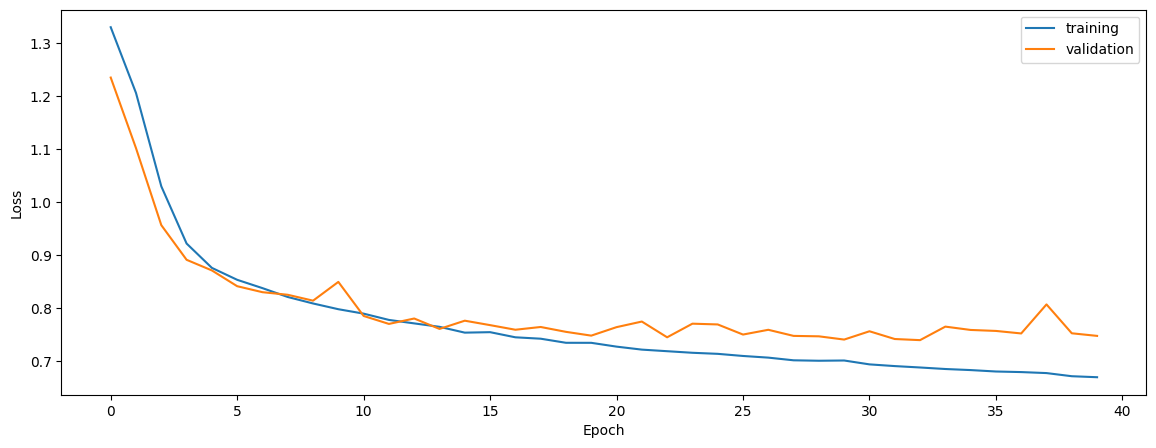

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuarcy(train[1],train_pred))
print(getAccuarcy(val[1],val_pred))
print(getAccuarcy(test[1],test_pred))

train
0.7187509709894253
0.7144832490518331
0.7299773481109942


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('normalized')
print(getAccuarcy(train2[1],train_pred2))
print(getAccuarcy(val2[1],val_pred2))
print(getAccuarcy(test2[1],test_pred2))

normalized
0.7187509709894253
0.7144832490518331
0.7299773481109942


In [9]:
print('native')
print(getAccuarcy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuarcy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuarcy(test2[1][test2[2]],test_pred2[test2[2]]))

native
0.7140090579654369
0.7216113744075829
0.7298473257088449


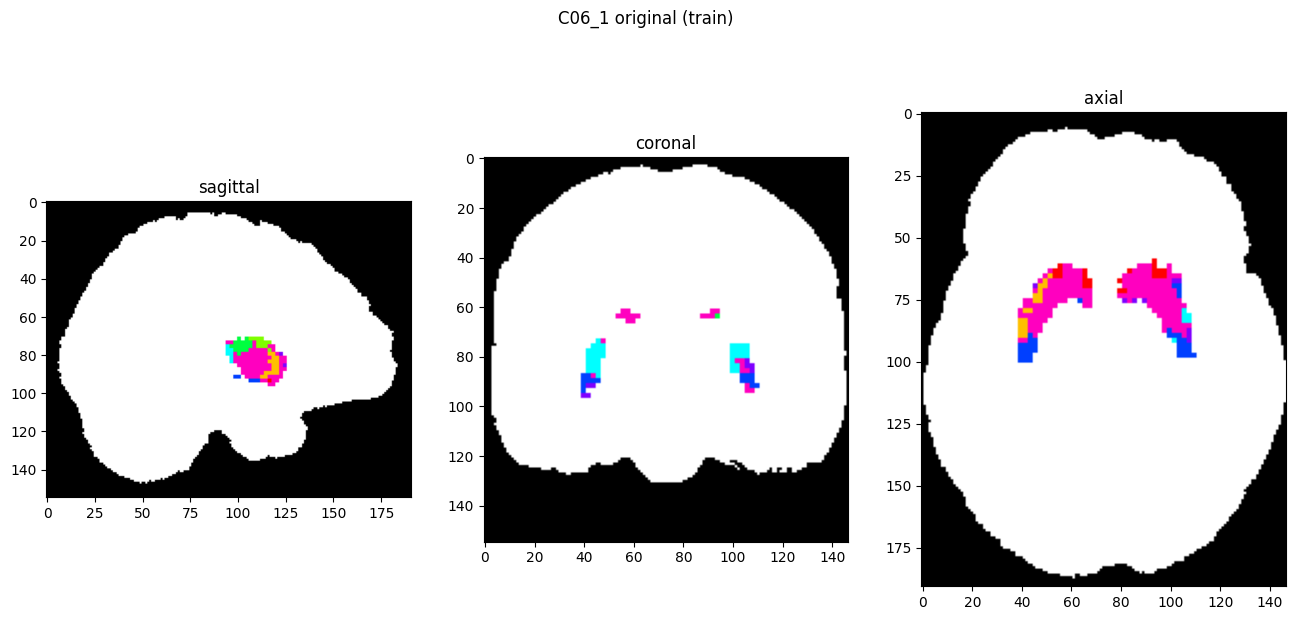

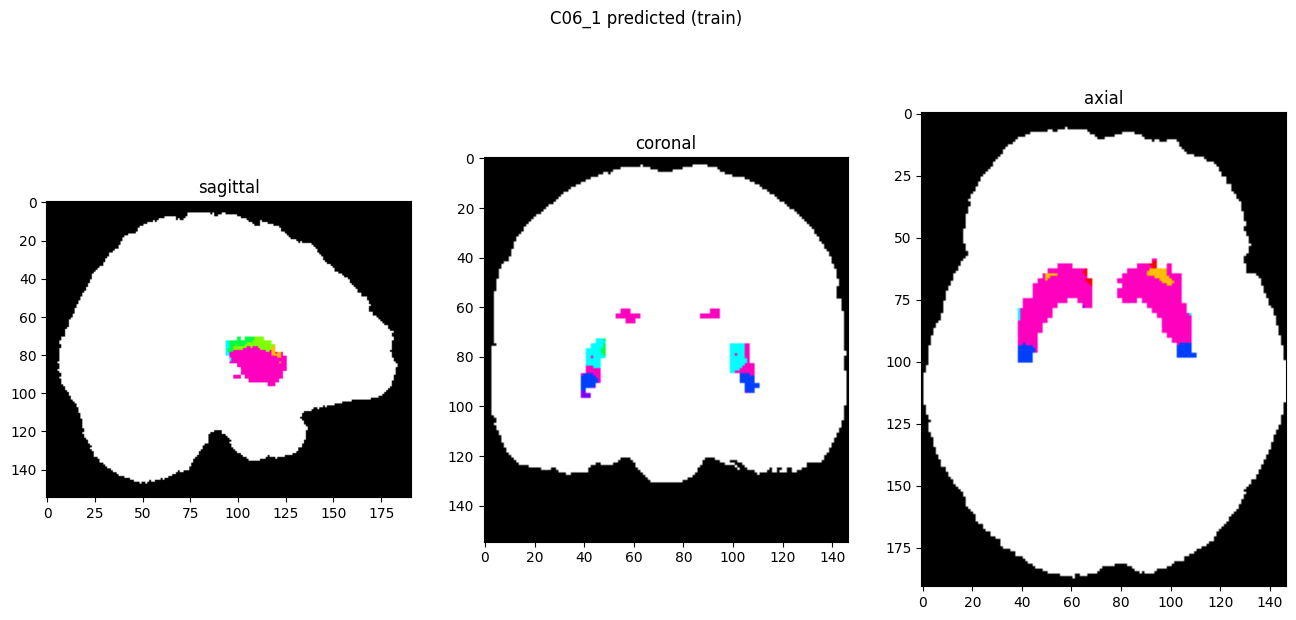

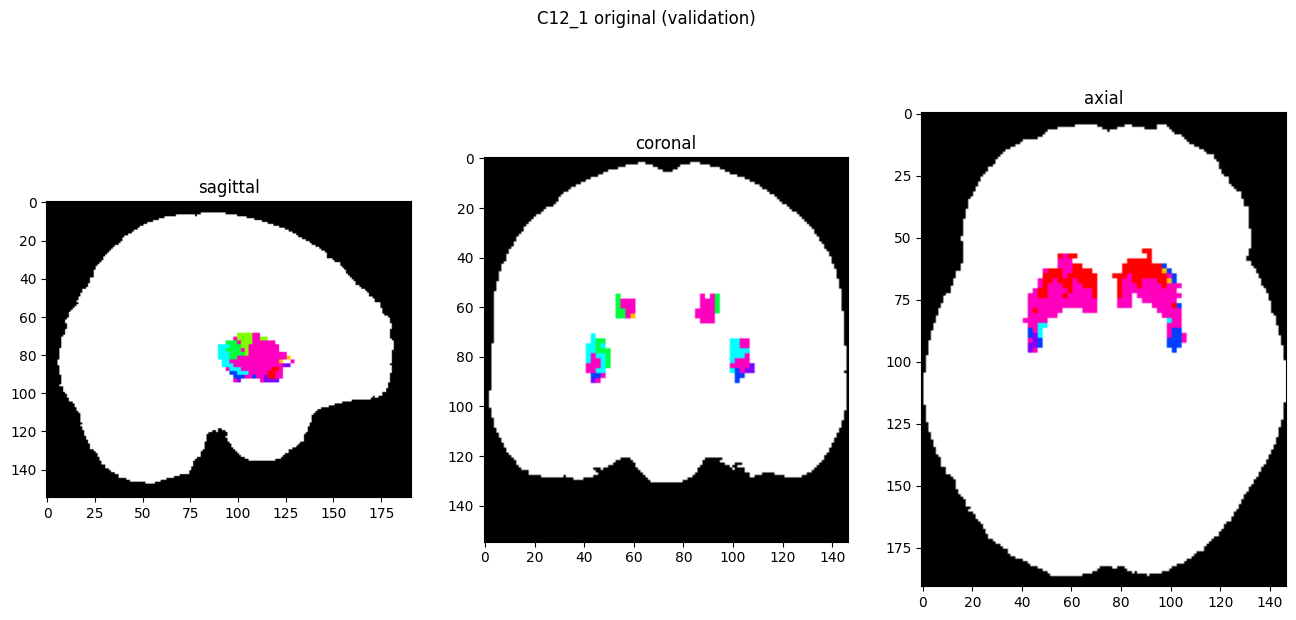

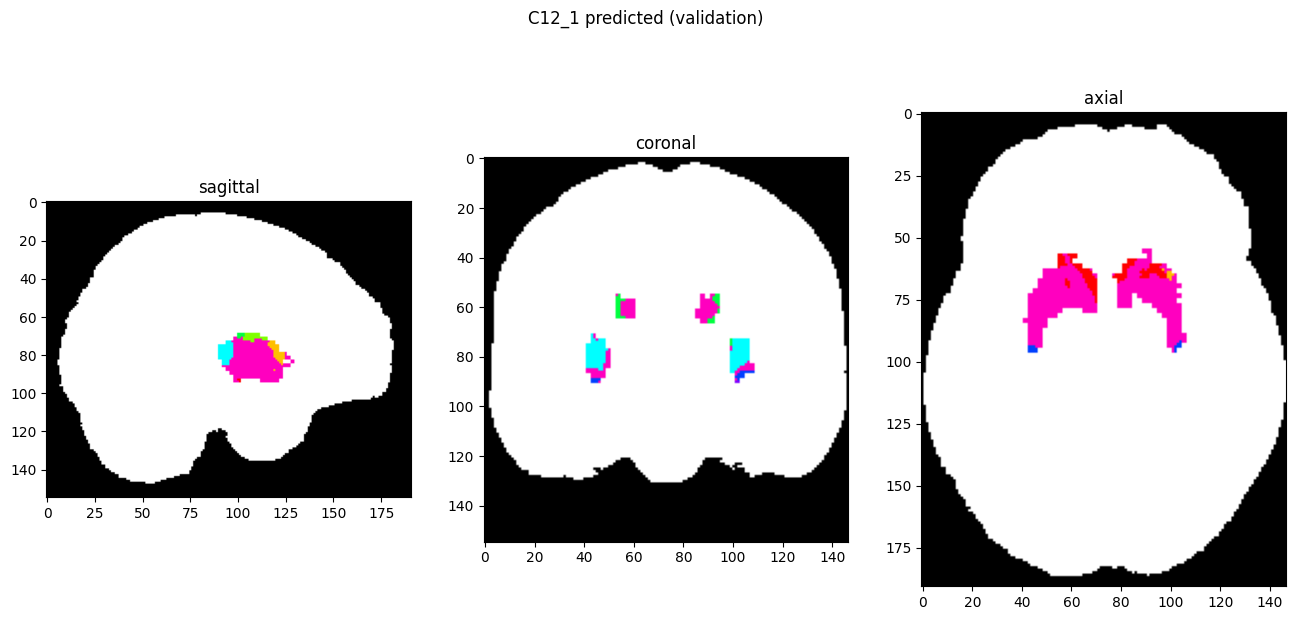

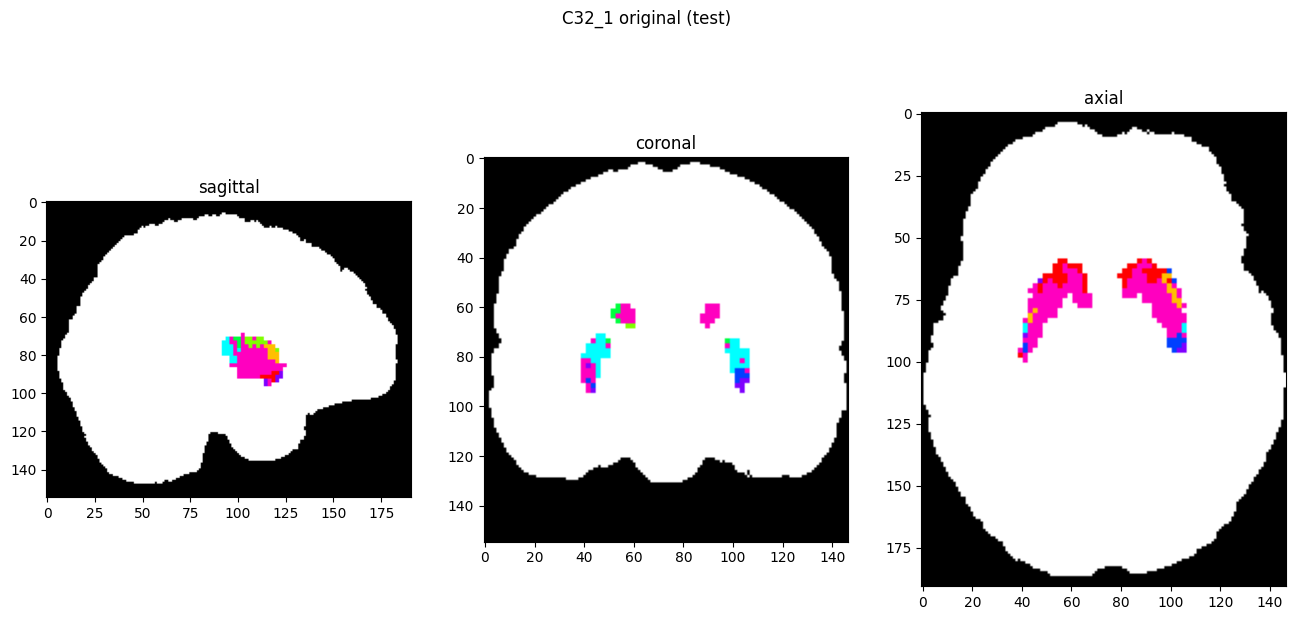

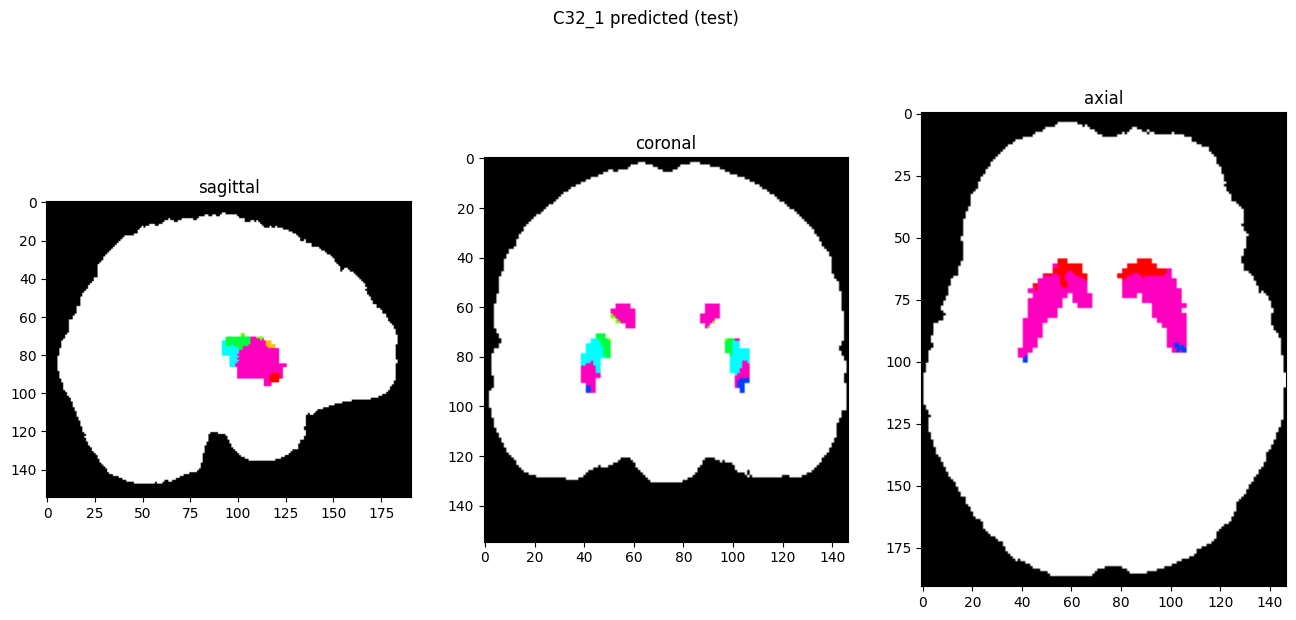

In [10]:
showResults(model, gen, threshold=0)